In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

In [ ]:
'https://data.worldbank.org/indicator/NY.GDP.MKTP.CD'
'https://data.worldbank.org/indicator/SP.POP.TOTL'
'https://datahub.io/core/co2-fossil-by-nation#python'

### Import Emissions Data

In [2]:
emissions_df = pd.read_csv('Data_Files/fossil-fuel-co2-emissions-by-nation_csv.csv')
emissions_df.head()

Year         Country  Total  Solid Fuel  Liquid Fuel  Gas Fuel  Cement  \
0  1751  UNITED KINGDOM   2552        2552            0         0       0   
1  1752  UNITED KINGDOM   2553        2553            0         0       0   
2  1753  UNITED KINGDOM   2553        2553            0         0       0   
3  1754  UNITED KINGDOM   2554        2554            0         0       0   
4  1755  UNITED KINGDOM   2555        2555            0         0       0   

   Gas Flaring  Per Capita  Bunker fuels (Not in Total)  
0            0         0.0                            0  
1            0         0.0                            0  
2            0         0.0                            0  
3            0         0.0                            0  
4            0         0.0                            0

In [3]:
def russia_combine(x):
    country_name = None
    if x == 'RUSSIAN FEDERATION' or x == 'USSR':
        country_name = 'RUSSIA'
    else:
        country_name = x
    return country_name

In [4]:
emissions_df.Country = emissions_df.Country.apply(lambda x: russia_combine(x))

In [5]:
emissions_df[emissions_df.Country == 'RUSSIA']

Year Country   Total  Solid Fuel  Liquid Fuel  Gas Fuel  Cement  \
269    1830  RUSSIA       5           5            0         0       0   
281    1831  RUSSIA       6           6            0         0       0   
292    1832  RUSSIA       4           4            0         0       0   
303    1833  RUSSIA       5           5            0         0       0   
517    1850  RUSSIA      31          31            0         0       0   
...     ...     ...     ...         ...          ...       ...     ...   
16300  2010  RUSSIA  455558      107603        93687    239553    6854   
16517  2011  RUSSIA  480885      109218       108312    247327    7643   
16737  2012  RUSSIA  499272      124583       115878    241786    8391   
16957  2013  RUSSIA  485018      114984       105329    246808    9044   
17177  2014  RUSSIA  465052      110403       107368    232204    9322   

       Gas Flaring  Per Capita  Bunker fuels (Not in Total)  
269              0        0.00                            0  
281              0        0.00                            0  
292              0        0.00                            0  
303              0        0.00                            0  
517              0        0.00                            0  
...            ...         ...                          ...  
16300         7861        3.18                         6514  
16517         8385        3.36                         7962  
16737         8635        3.48                         7034  
16957         8853        3.38                         9524  
17177         5755        3.24                        17585  

[163 rows x 10 columns]

In [6]:
emissions_df.drop(labels = ['Solid Fuel', 'Liquid Fuel', 'Gas Fuel', 'Cement', 'Gas Flaring',
                            'Per Capita', 'Bunker fuels (Not in Total)'], axis = 1, inplace = True)
emissions_df.columns = ['Year', 'Country', 'Fossil_Fuel_CO2_Emissions']
emissions_df.head()

Year         Country  Fossil_Fuel_CO2_Emissions
0  1751  UNITED KINGDOM                       2552
1  1752  UNITED KINGDOM                       2553
2  1753  UNITED KINGDOM                       2553
3  1754  UNITED KINGDOM                       2554
4  1755  UNITED KINGDOM                       2555

In [7]:
emissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17232 entries, 0 to 17231
Data columns (total 3 columns):
Year                         17232 non-null int64
Country                      17232 non-null object
Fossil_Fuel_CO2_Emissions    17232 non-null int64
dtypes: int64(2), object(1)
memory usage: 404.0+ KB


In [8]:
emissions_df.Year.max()

2014

In [9]:
emissions_df.Country.nunique()

255

In [10]:
country_df_names = []
for country in emissions_df.Country.unique():
    df_name = f"{country}_df"
    country_df_names.append(df_name)

country_df_dict = {}
for df in country_df_names:
    country_df_dict[df] = emissions_df[emissions_df.Country == df[:-3]]
    

In [11]:
len(country_df_dict)

255

In [12]:
for key in list(country_df_dict.keys()):
    country_df_dict[key.replace(' ', '_')] = country_df_dict.pop(key)

In [13]:
for key in country_df_dict.keys():
    country_df_dict[key].Year = pd.to_datetime(country_df_dict[key].Year, format = '%Y')
    country_df_dict[key].drop('Country', axis = 1, inplace = True)
    country_df_dict[key].set_index('Year', inplace = True)

In [14]:
list(country_df_dict.items())[0:5]

[('UNITED_KINGDOM_df',             Fossil_Fuel_CO2_Emissions
  Year                                 
  1751-01-01                       2552
  1752-01-01                       2553
  1753-01-01                       2553
  1754-01-01                       2554
  1755-01-01                       2555
  ...                               ...
  2010-01-01                     134499
  2011-01-01                     122124
  2012-01-01                     127781
  2013-01-01                     124966
  2014-01-01                     114486
  
  [264 rows x 1 columns]), ('CANADA_df',             Fossil_Fuel_CO2_Emissions
  Year                                 
  1785-01-01                          1
  1786-01-01                          1
  1787-01-01                          1
  1788-01-01                          1
  1789-01-01                          1
  ...                               ...
  2010-01-01                     145806
  2011-01-01                     146472
  2012-01-01     

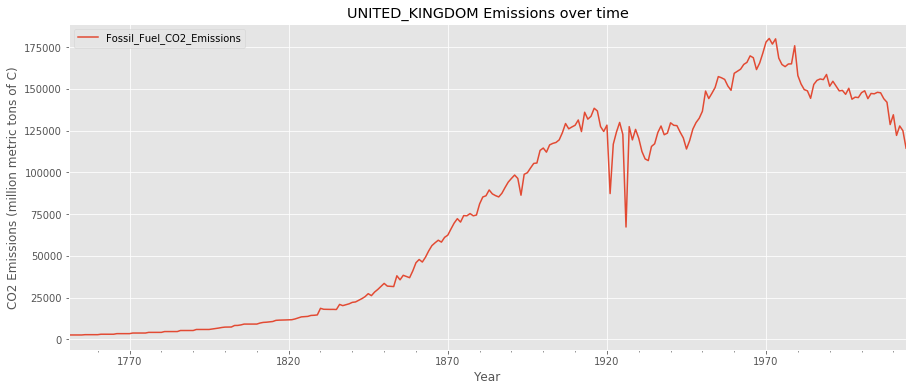

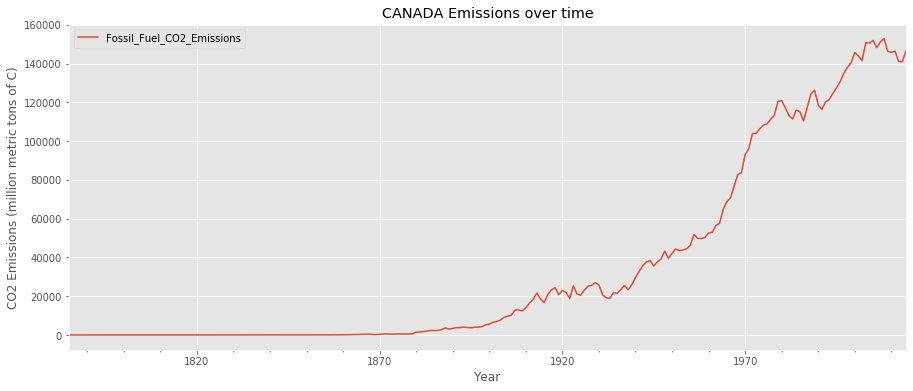

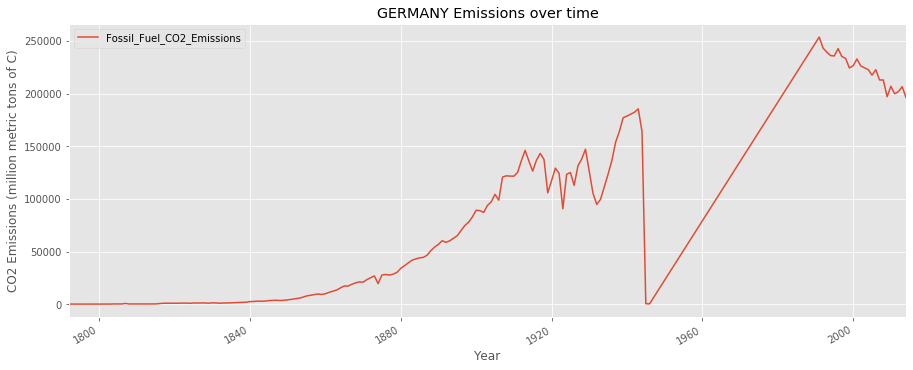

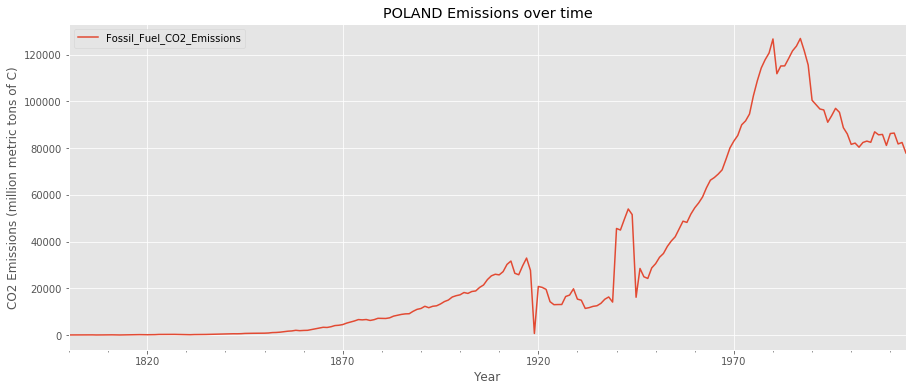

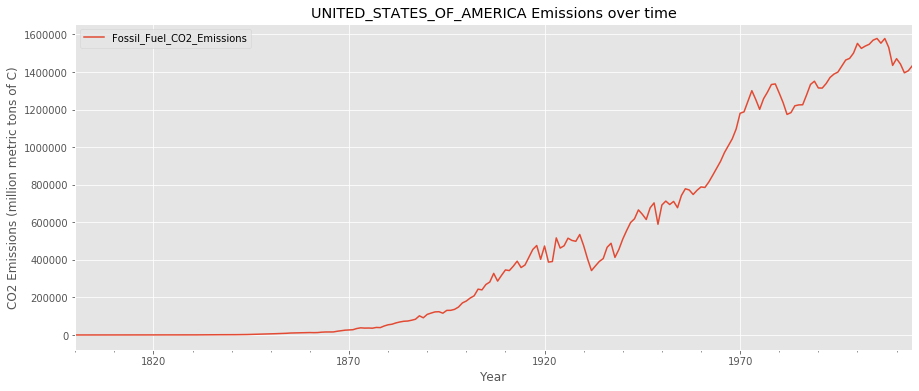

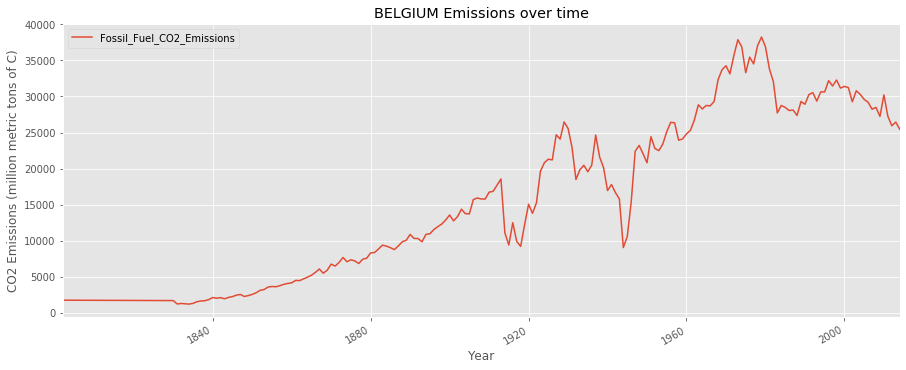

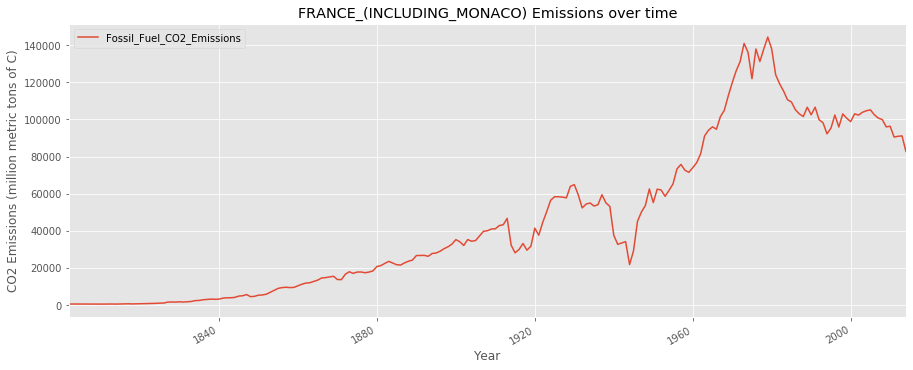

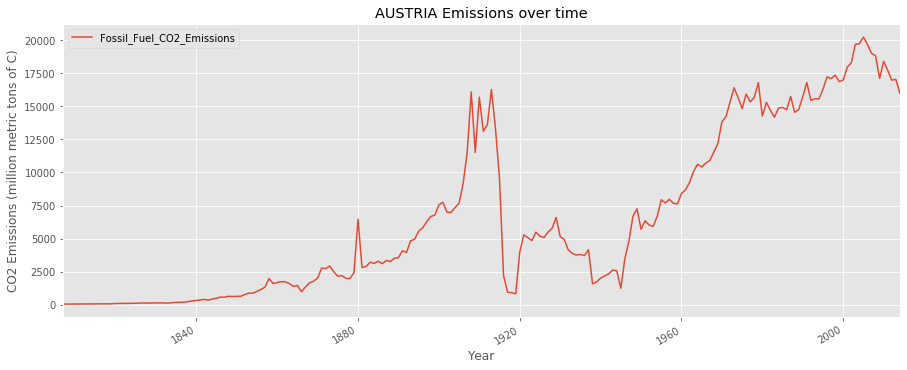

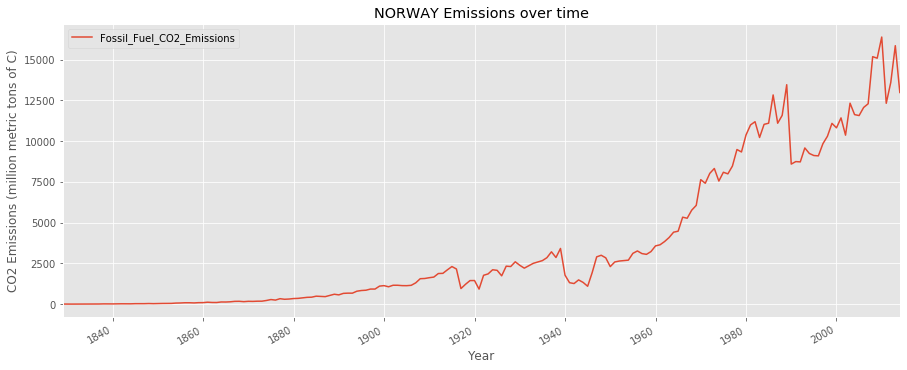

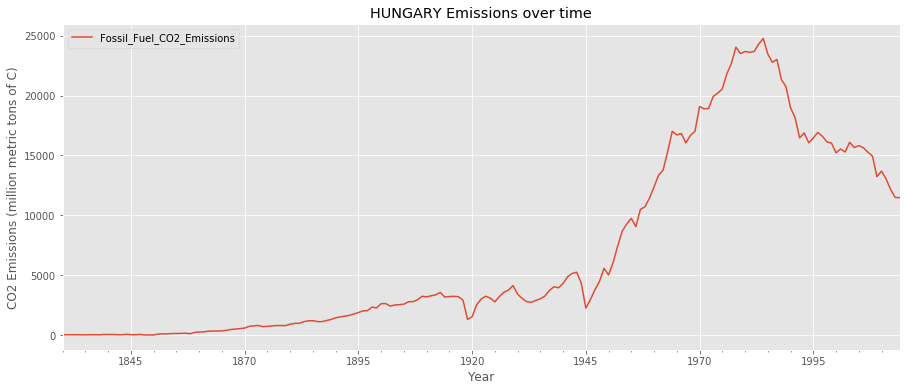

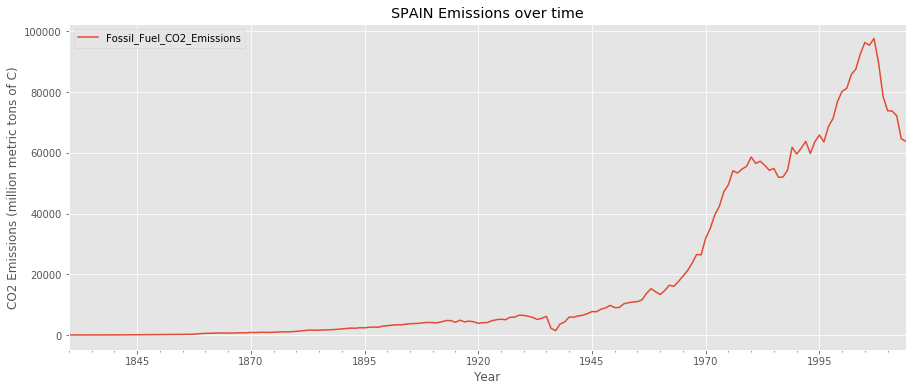

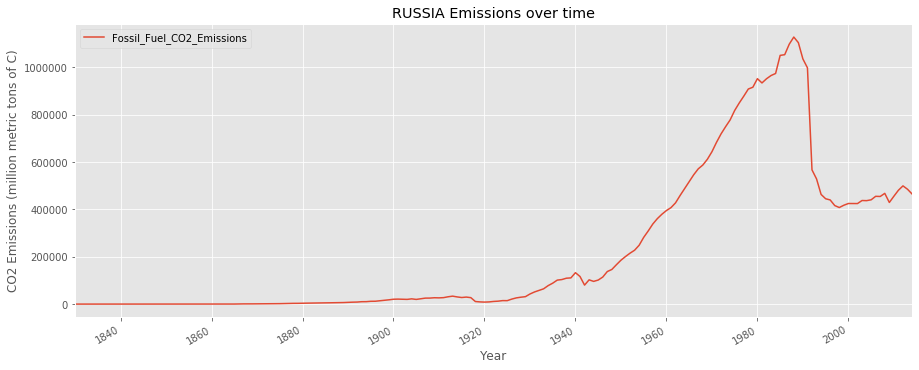

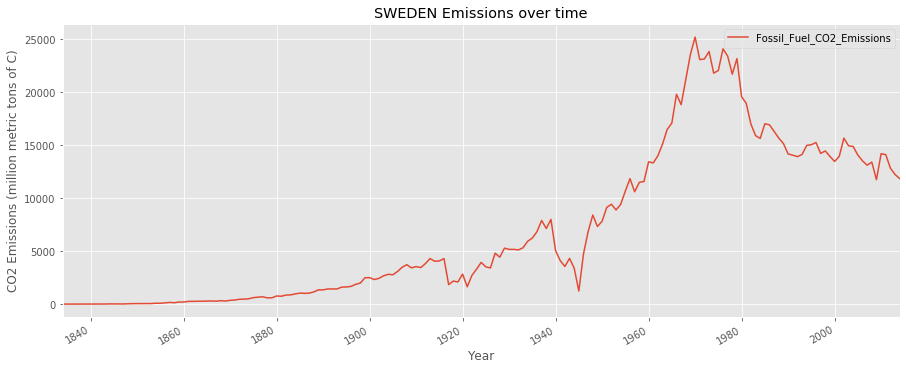

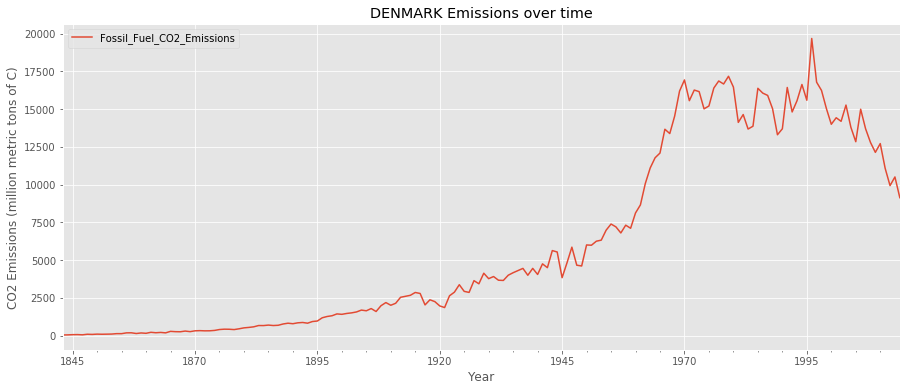

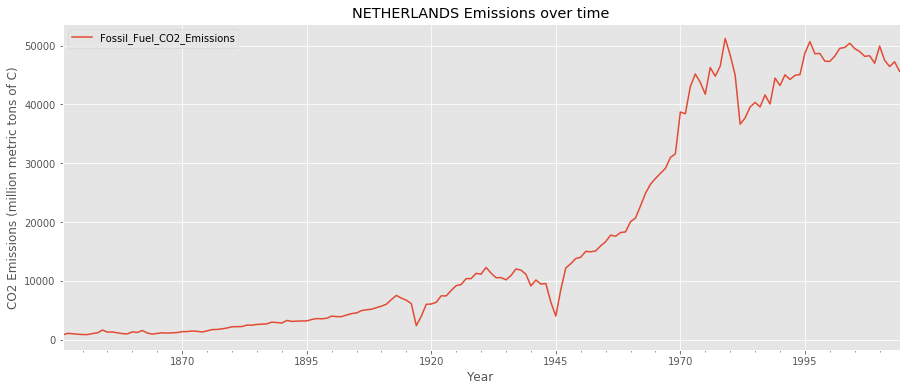

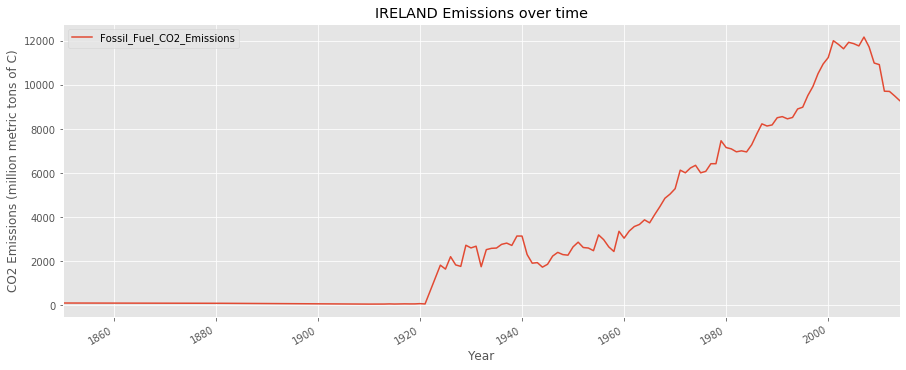

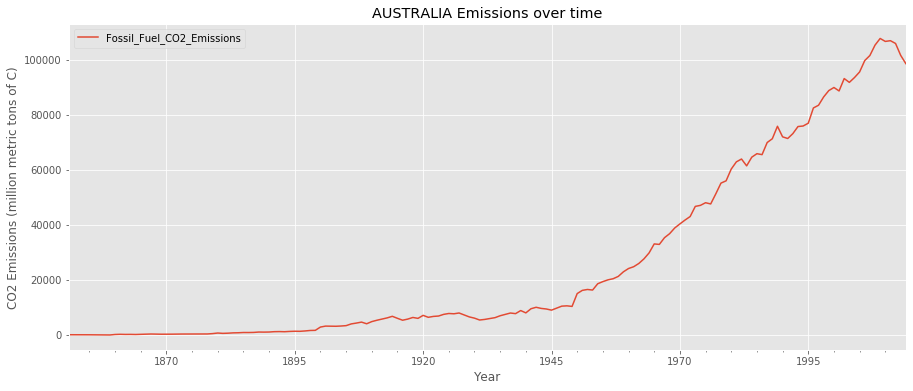

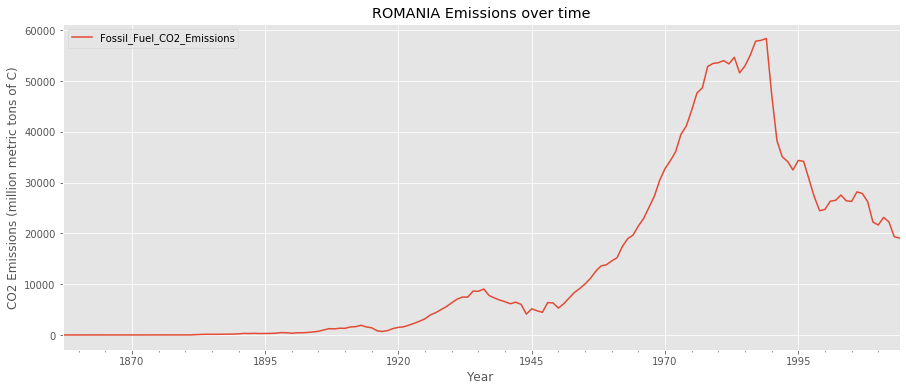

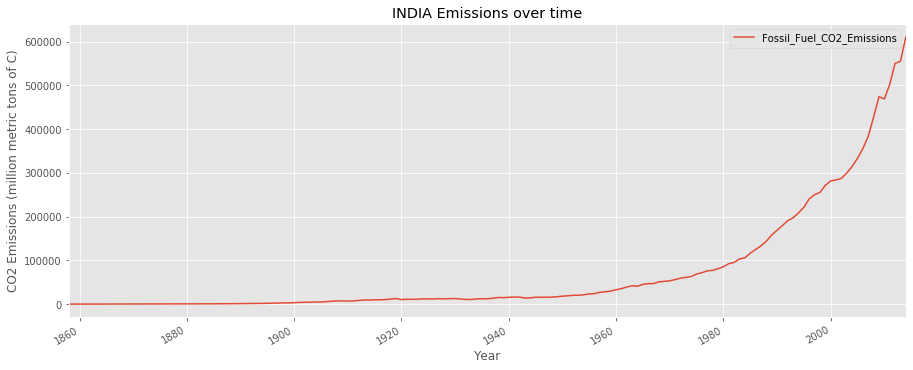

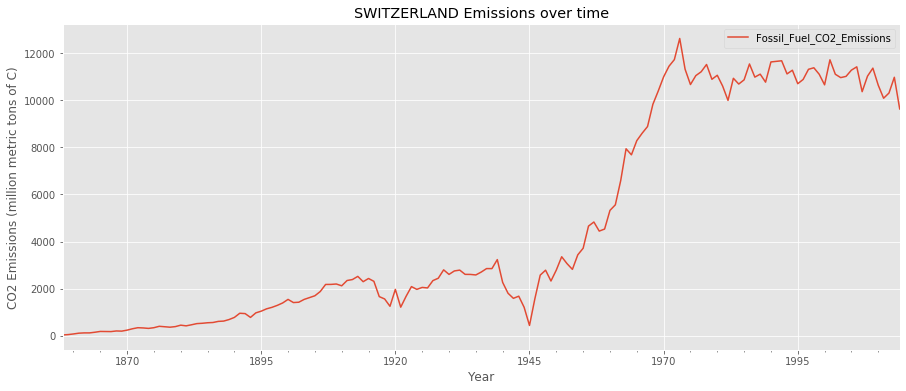

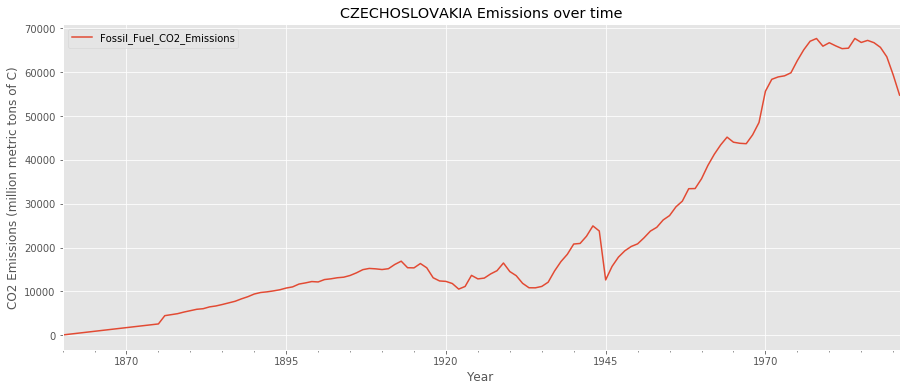

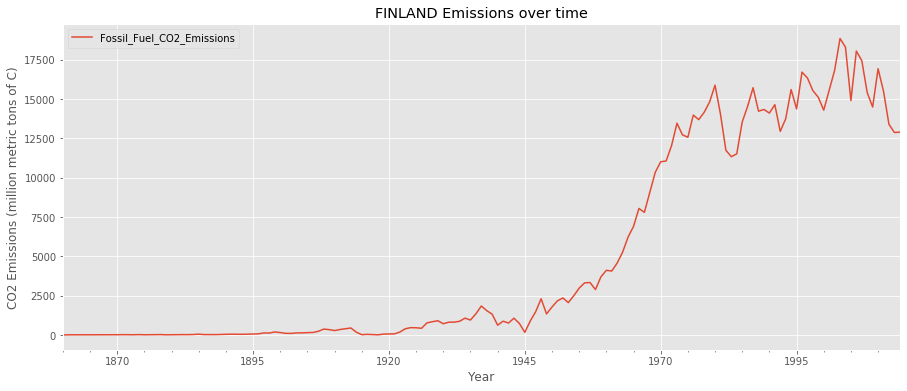

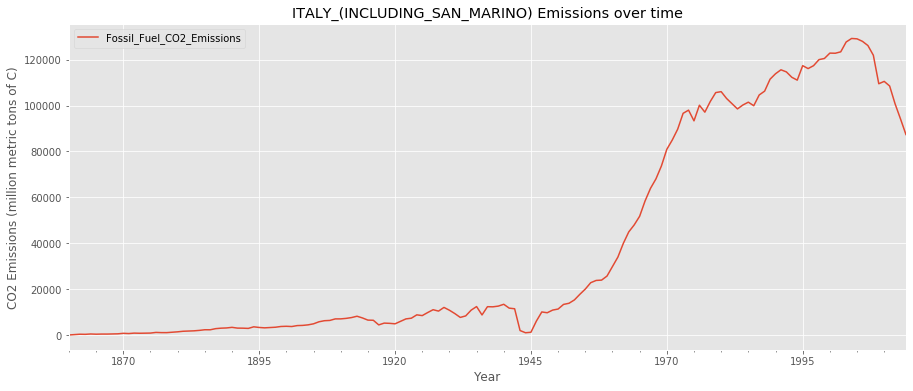

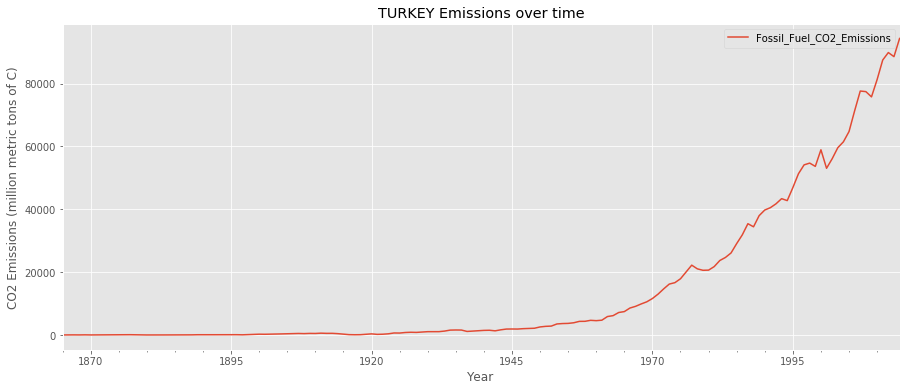

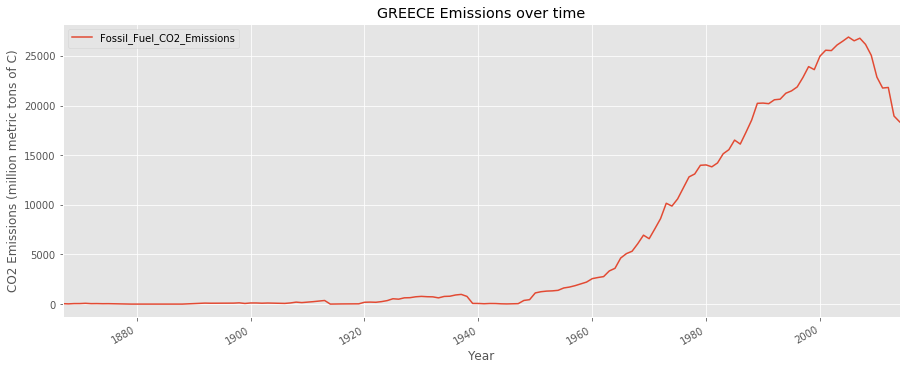

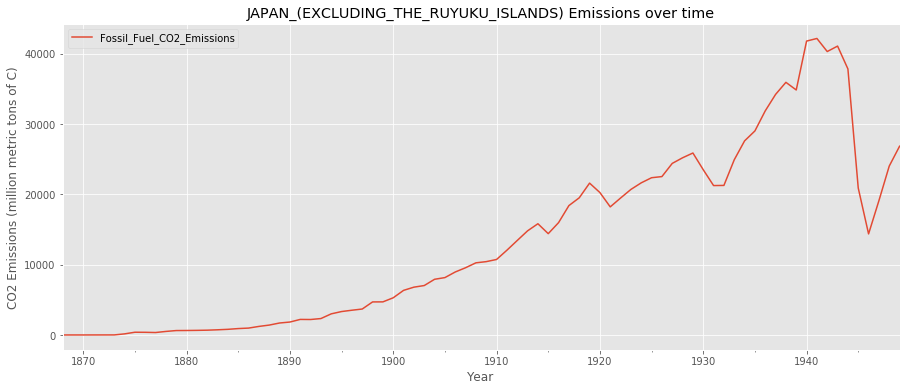

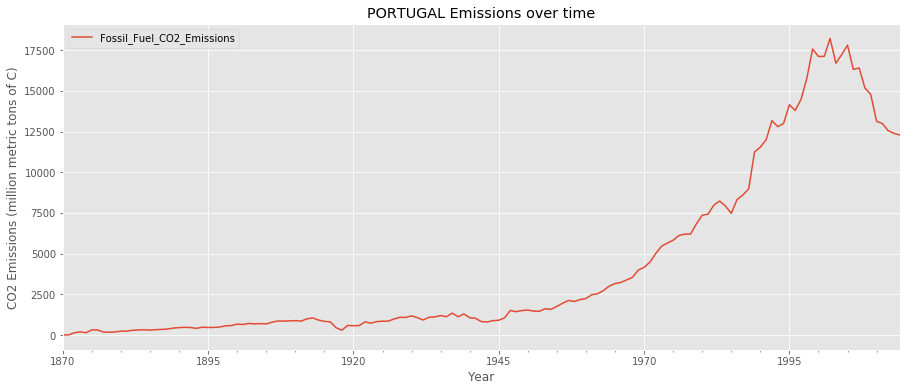

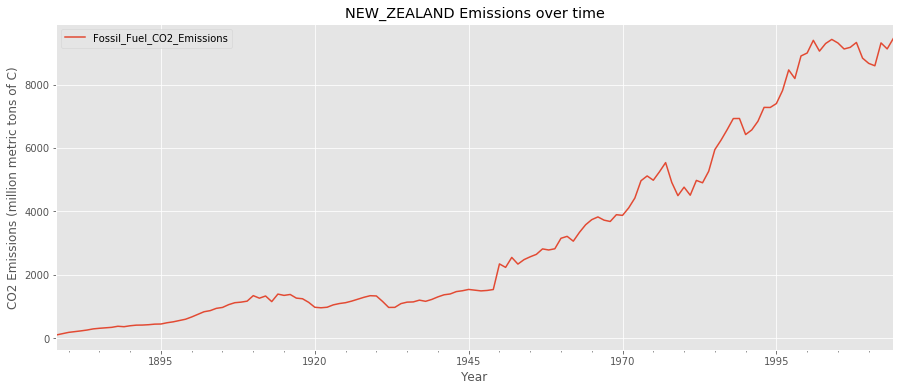

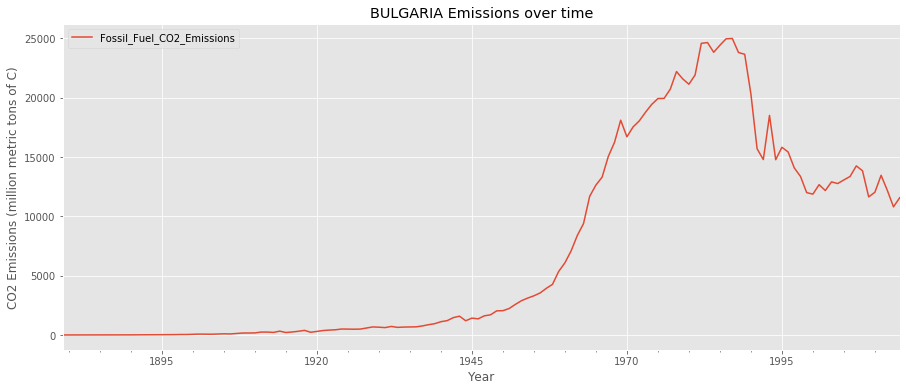

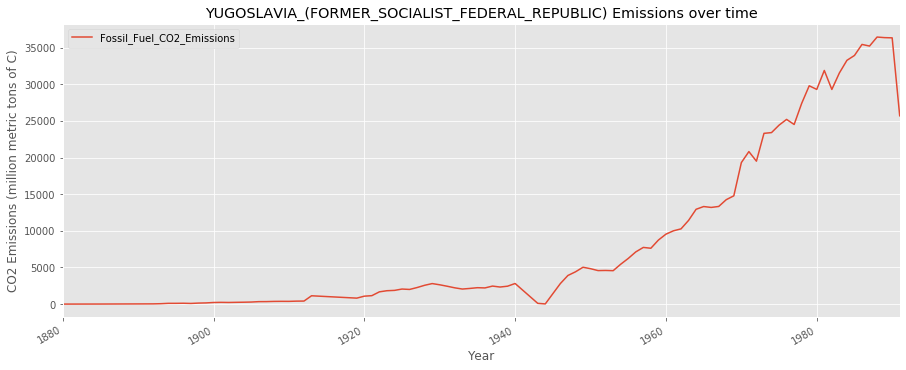

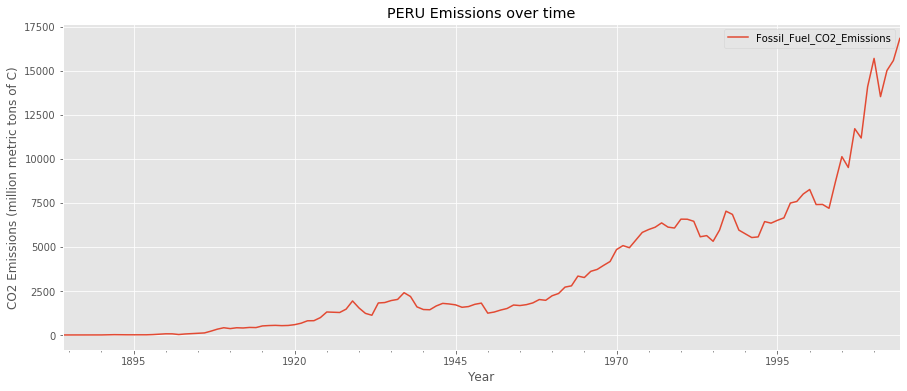

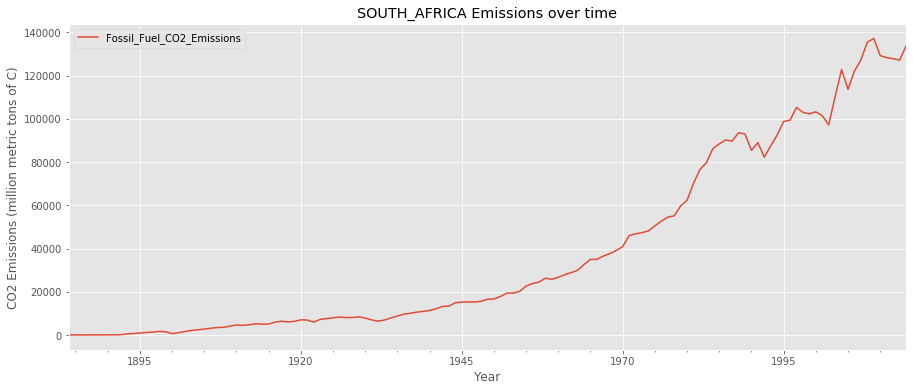

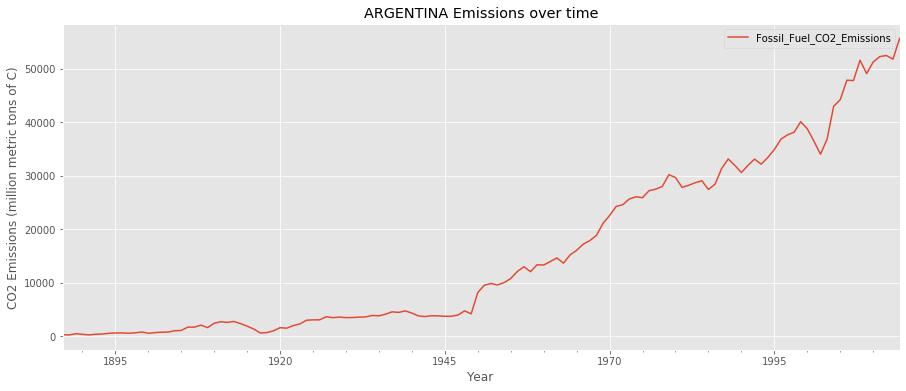

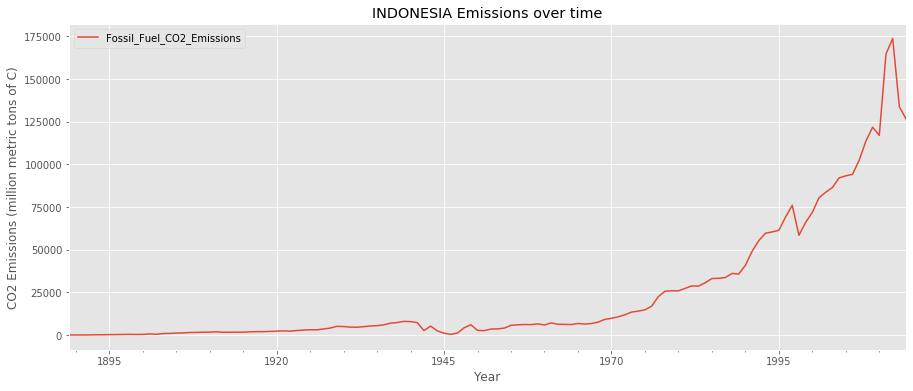

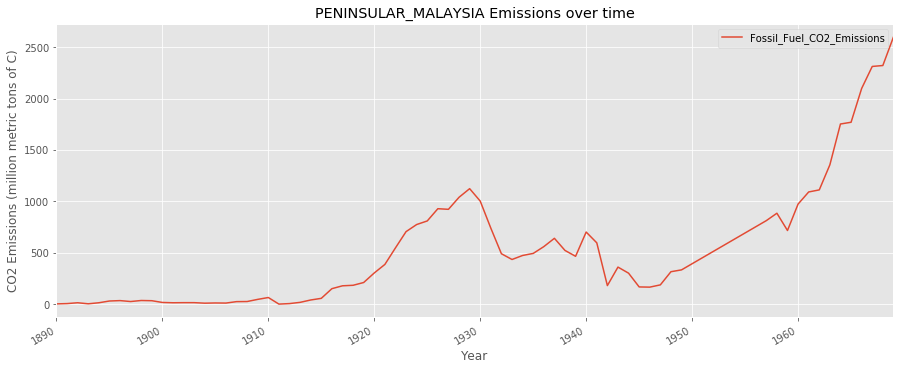

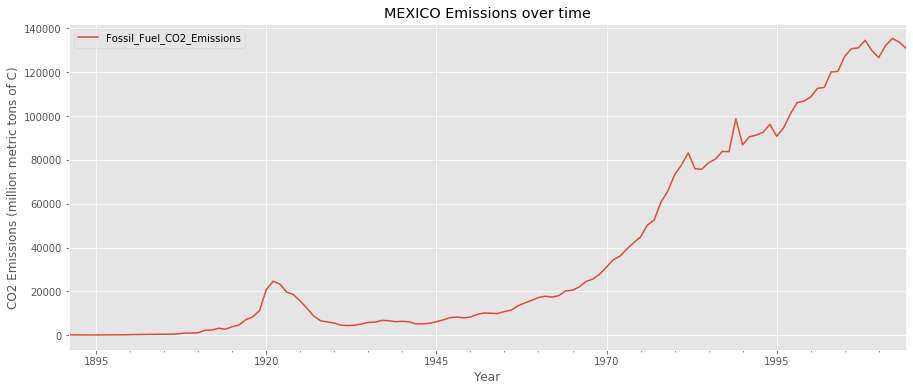

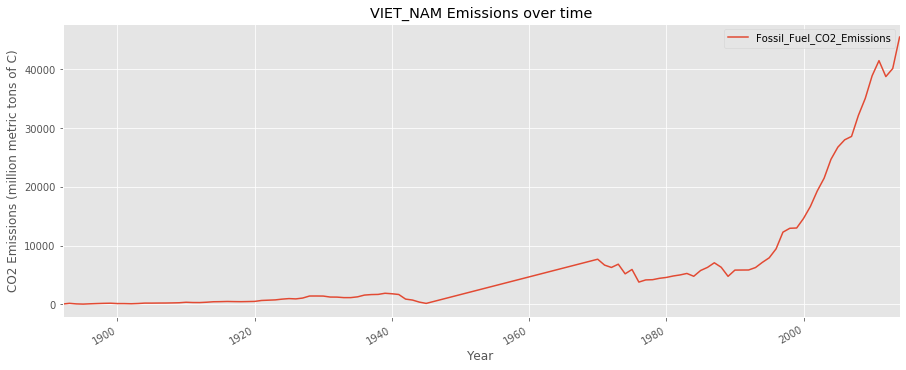

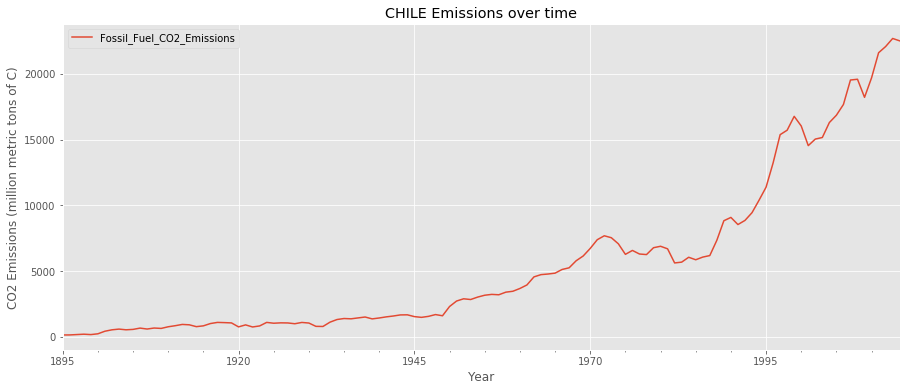

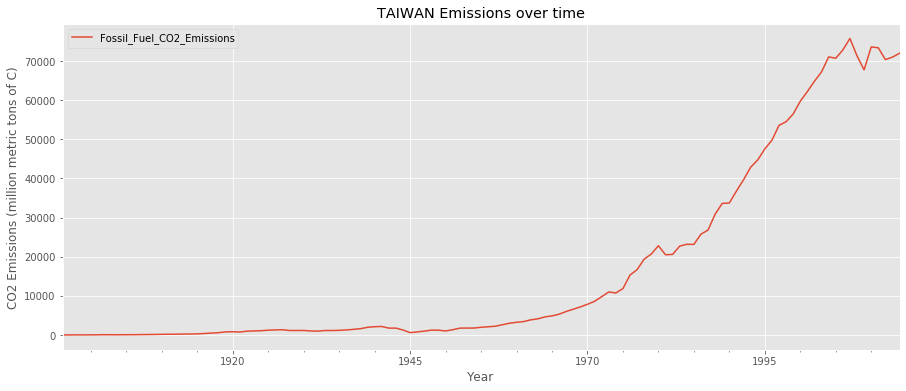

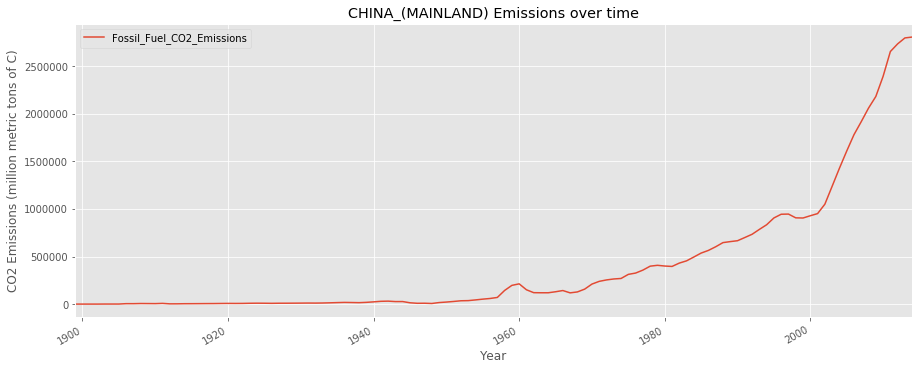

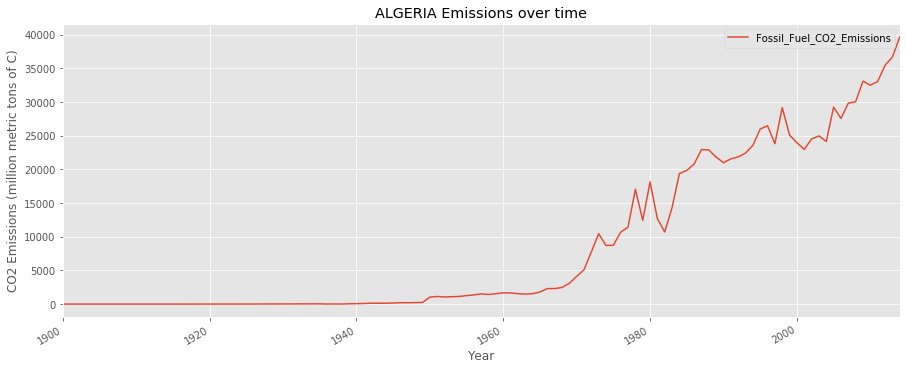

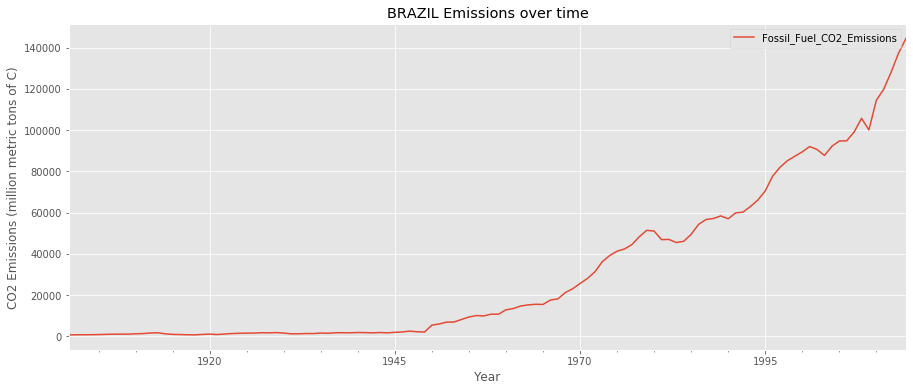

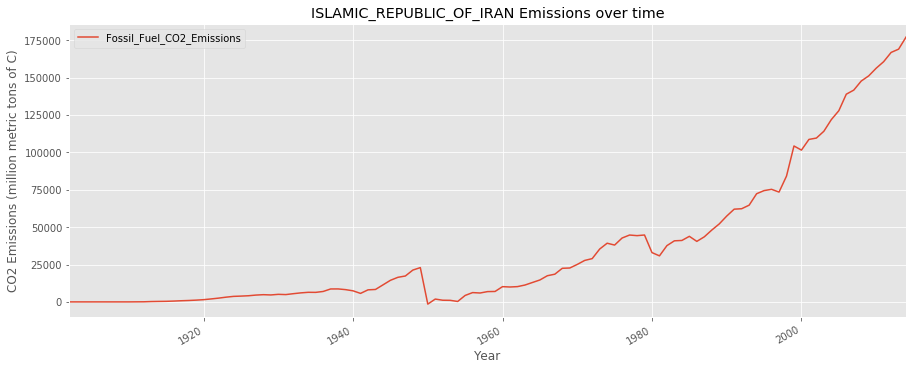

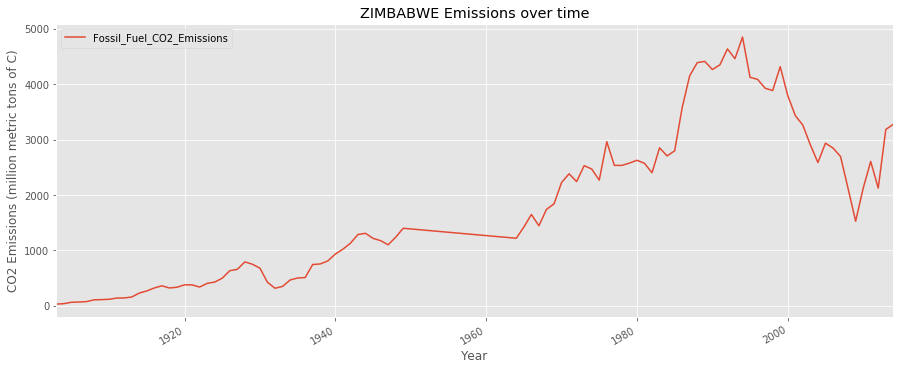

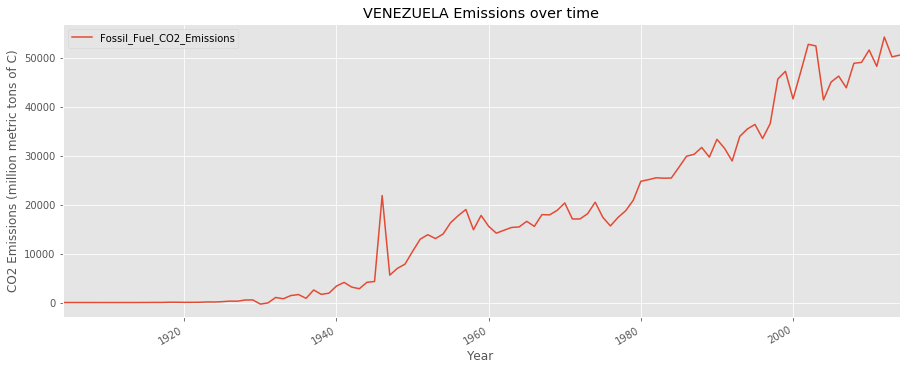

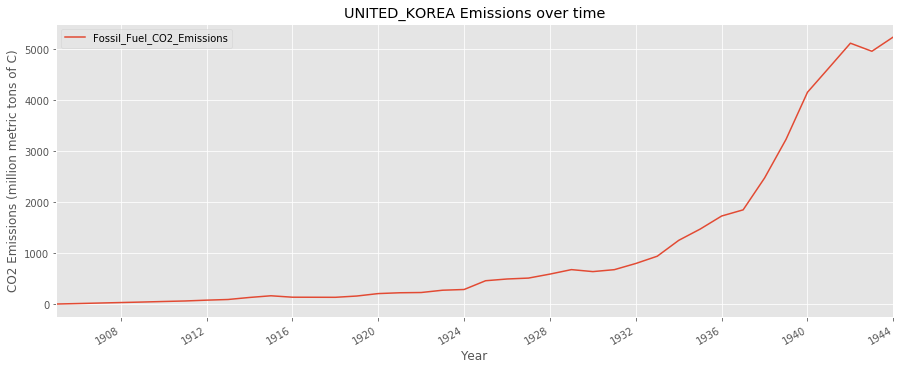

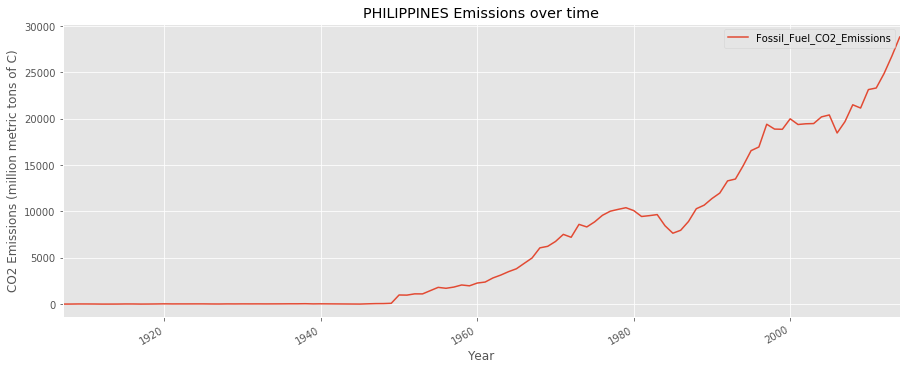

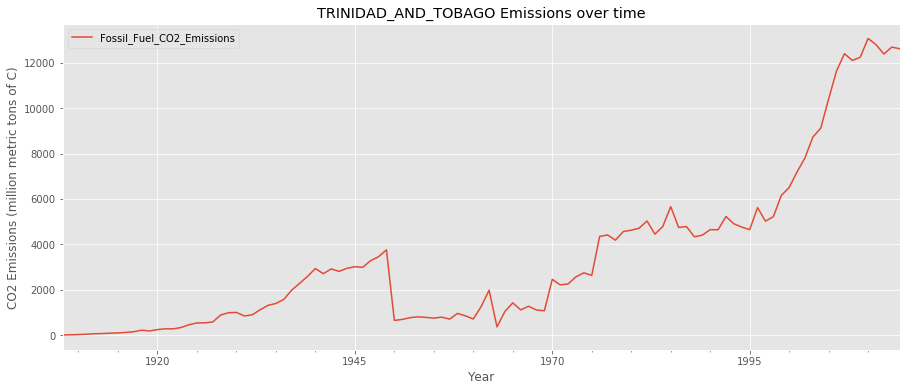

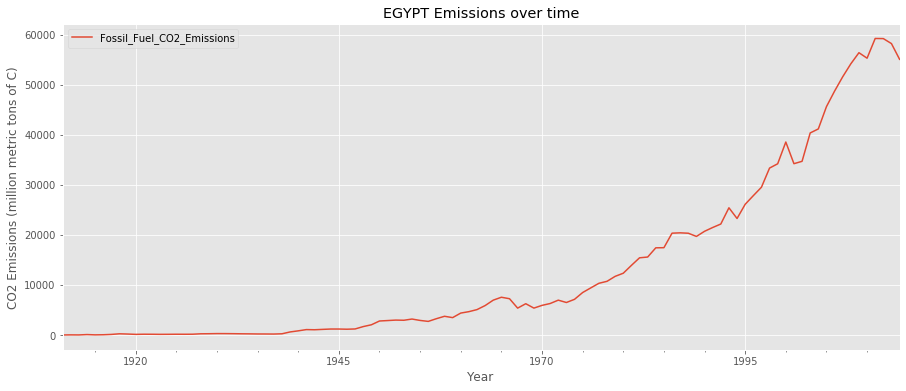

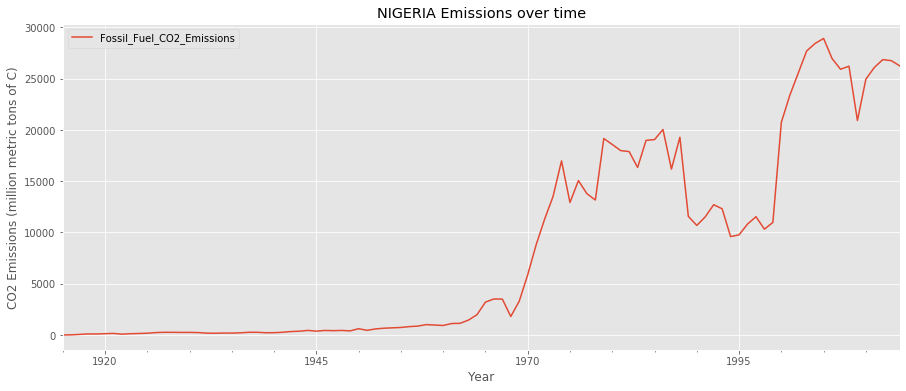

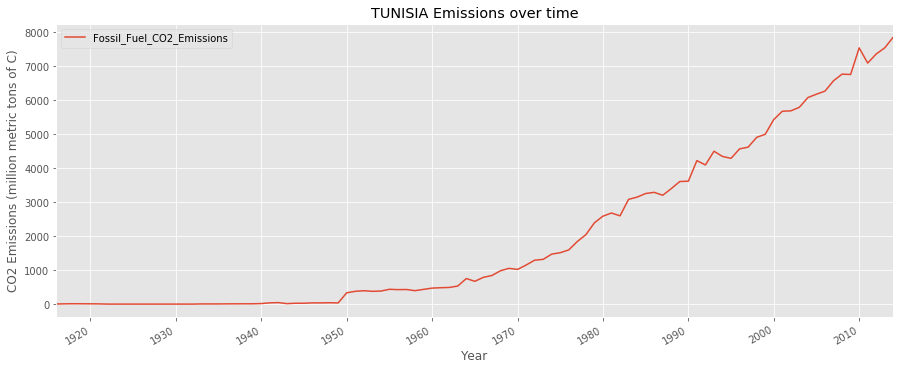

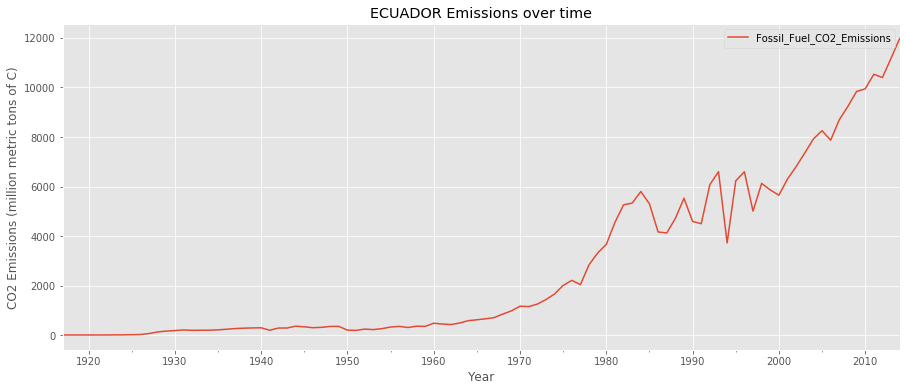

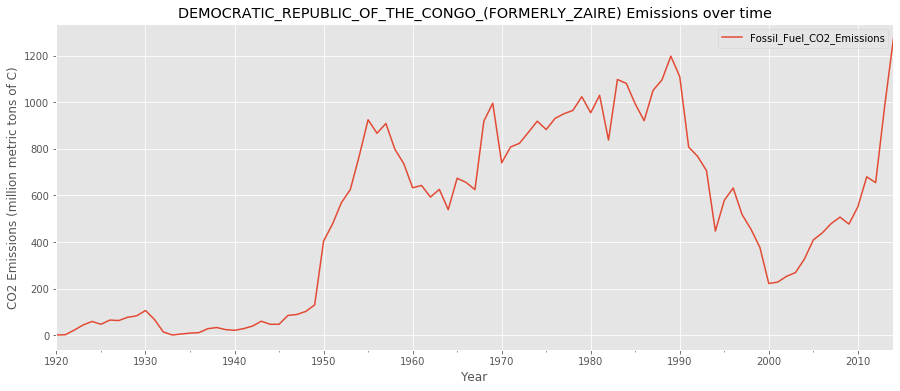

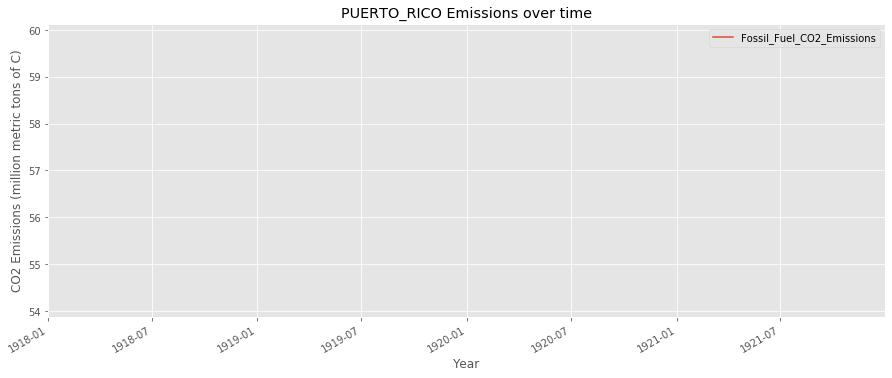

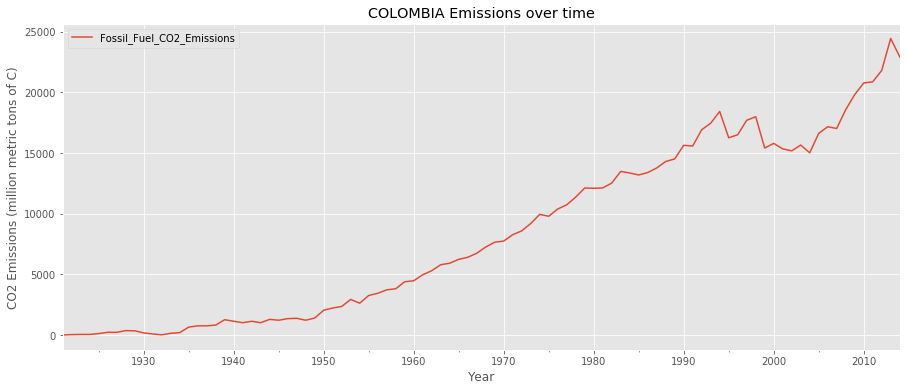

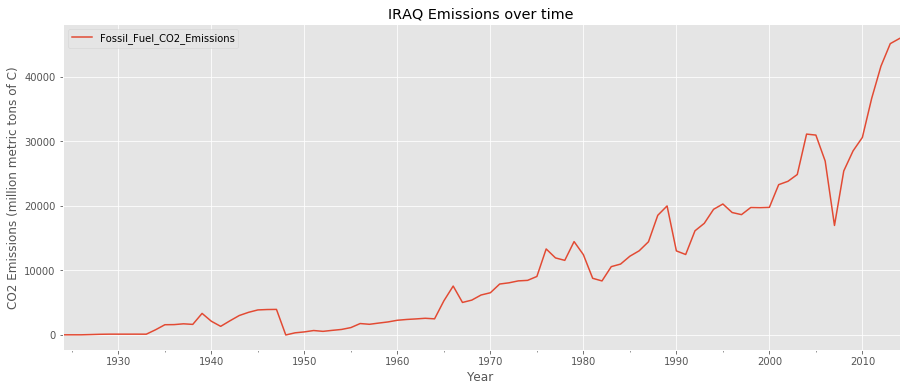

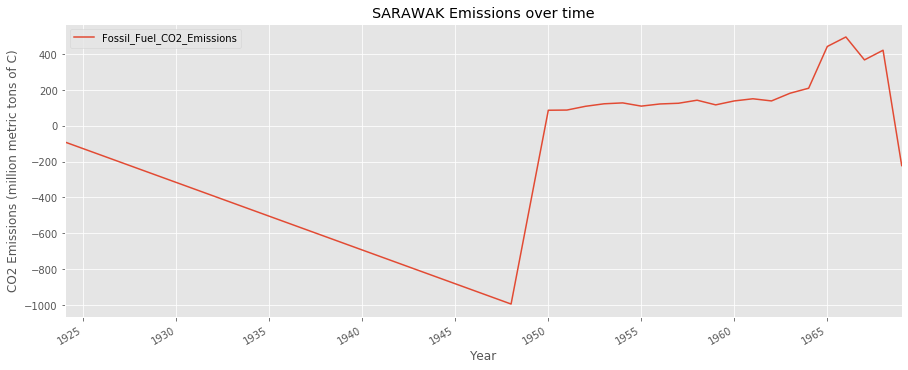

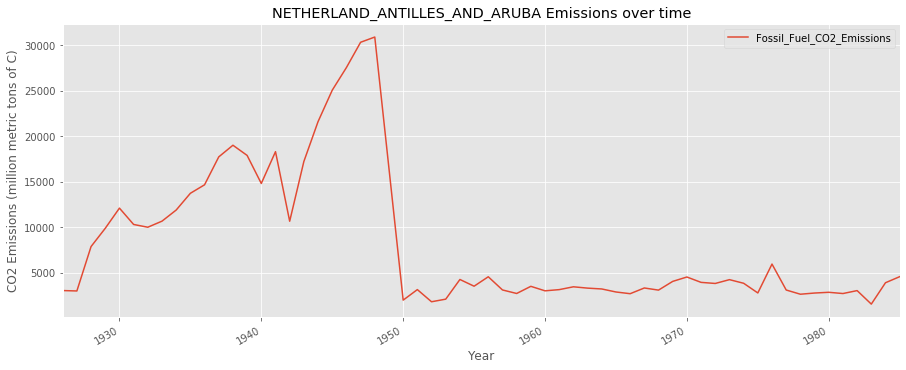

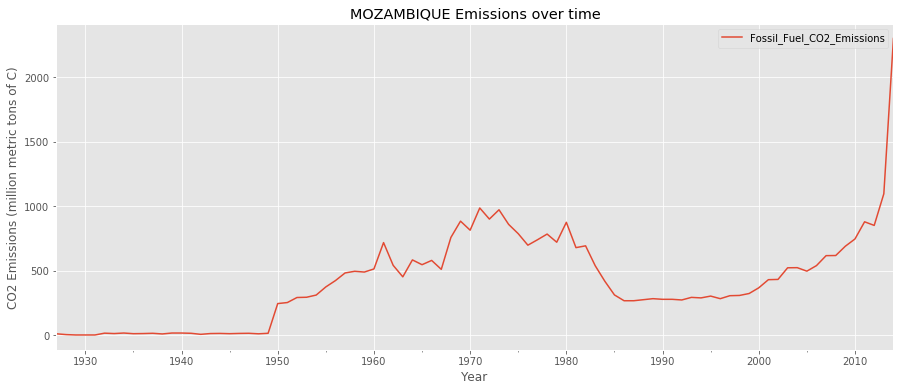

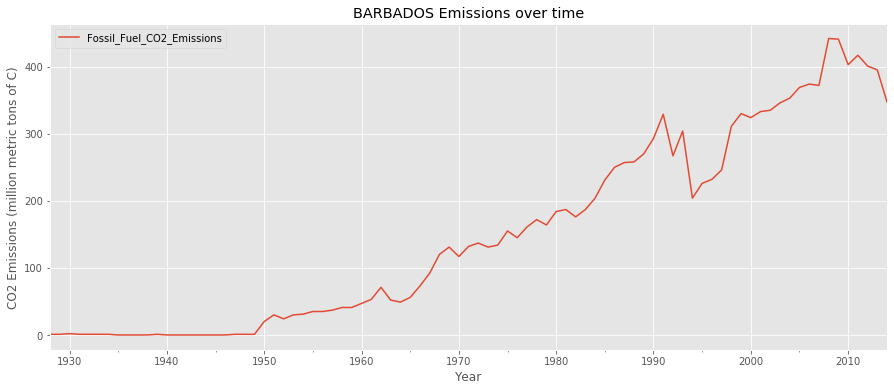

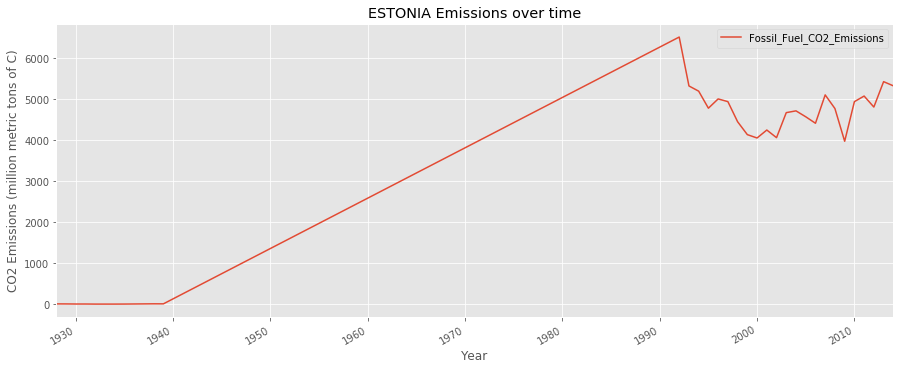

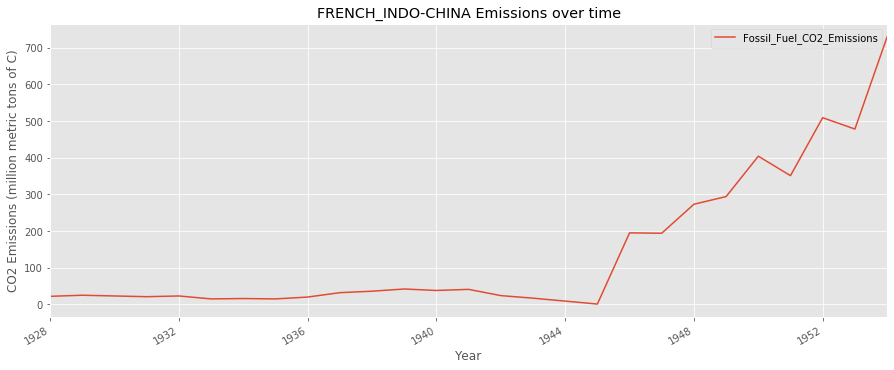

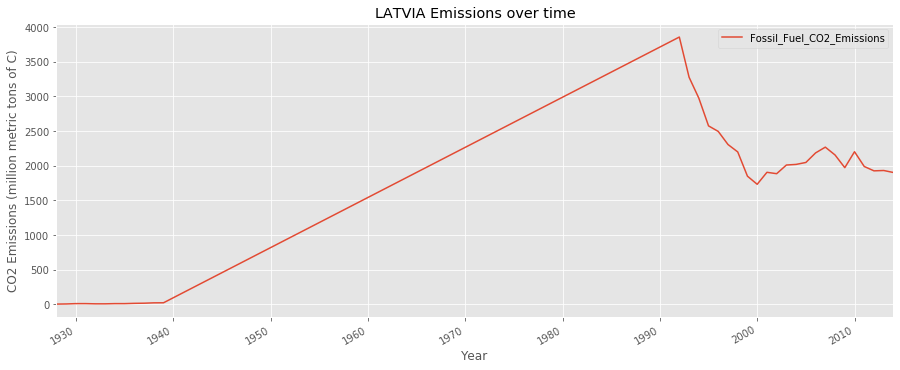

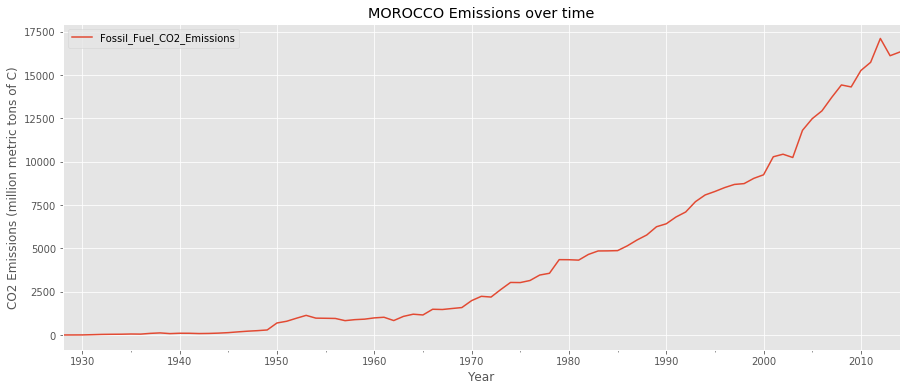

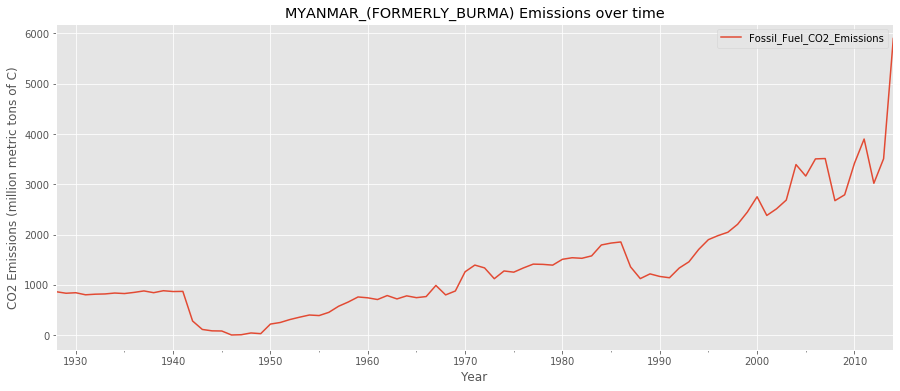

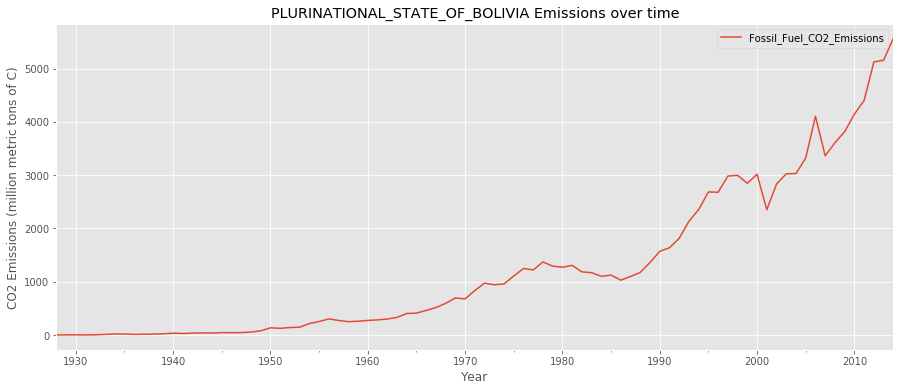

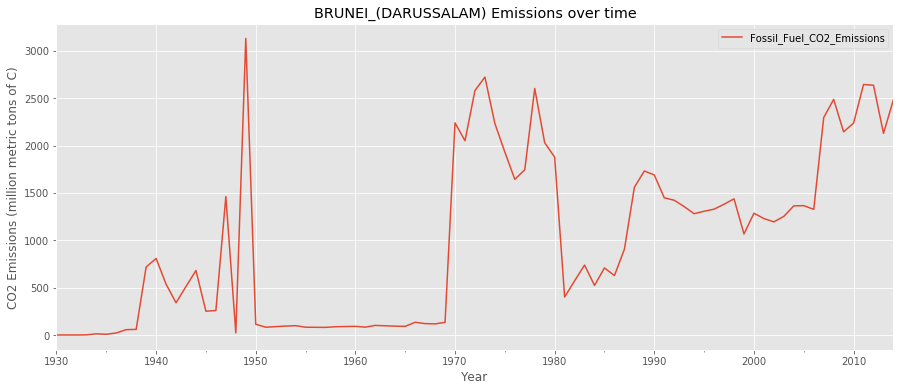

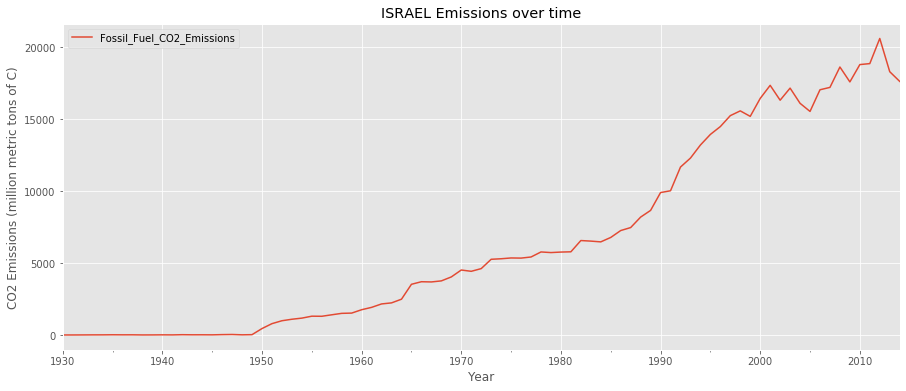

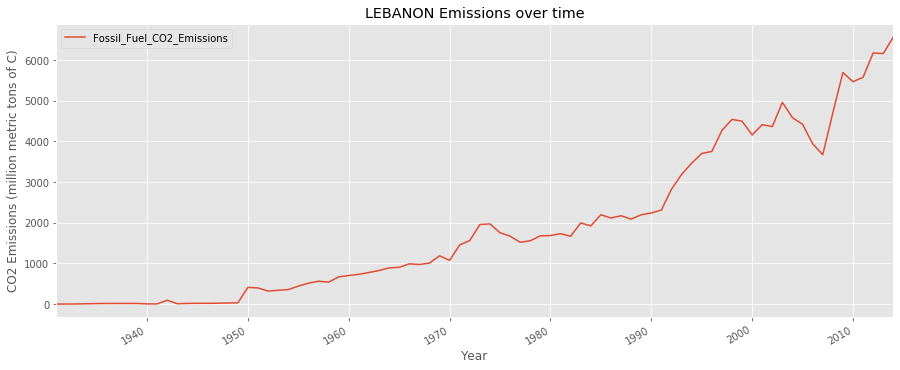

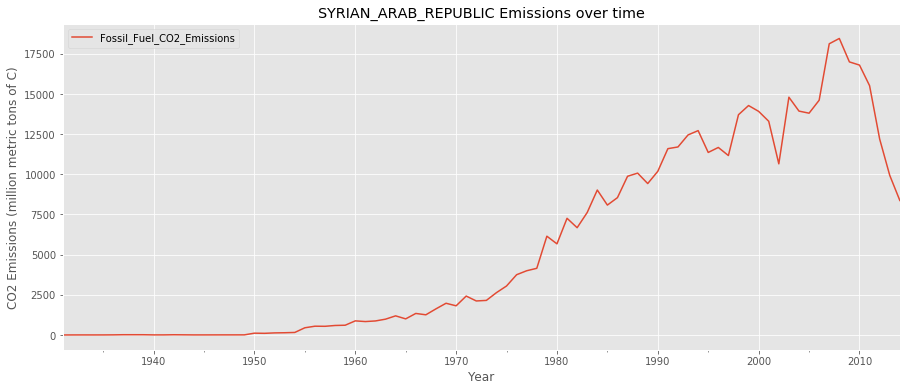

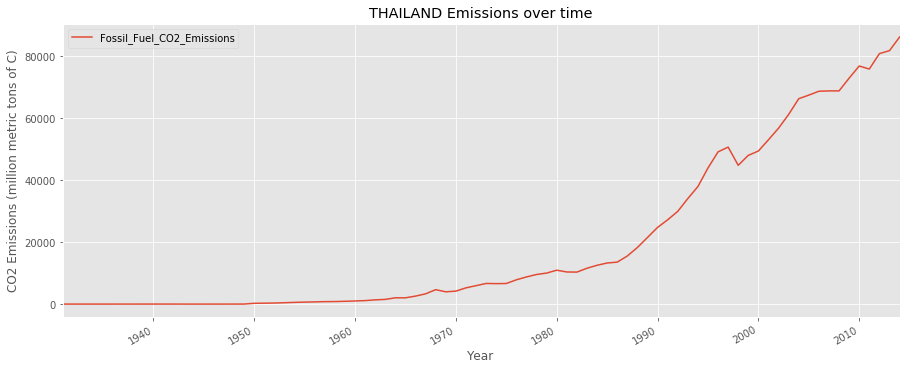

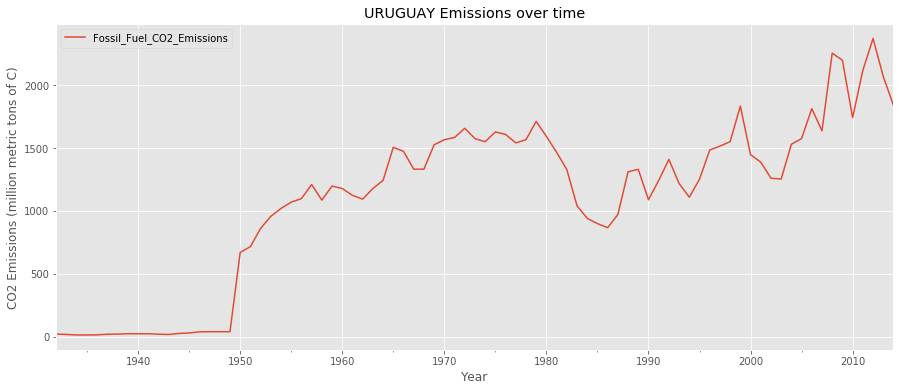

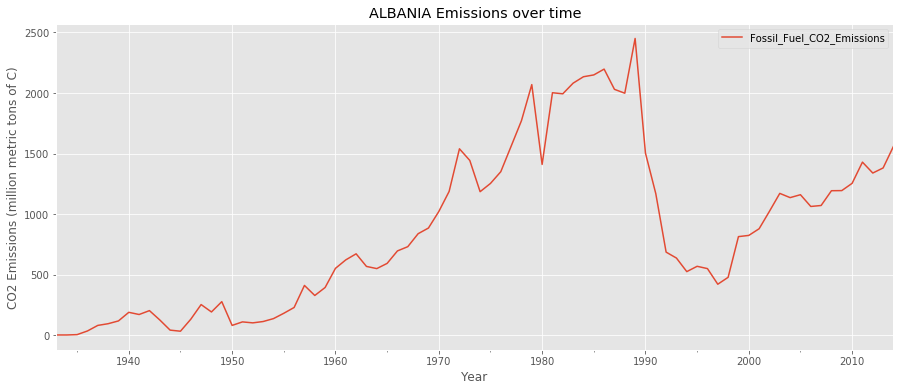

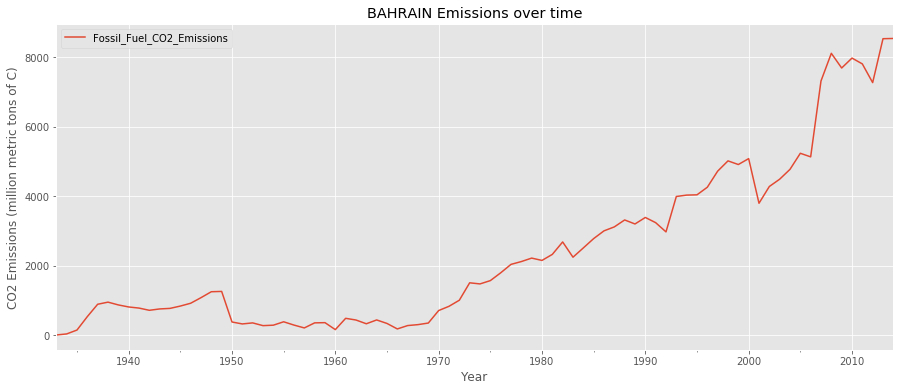

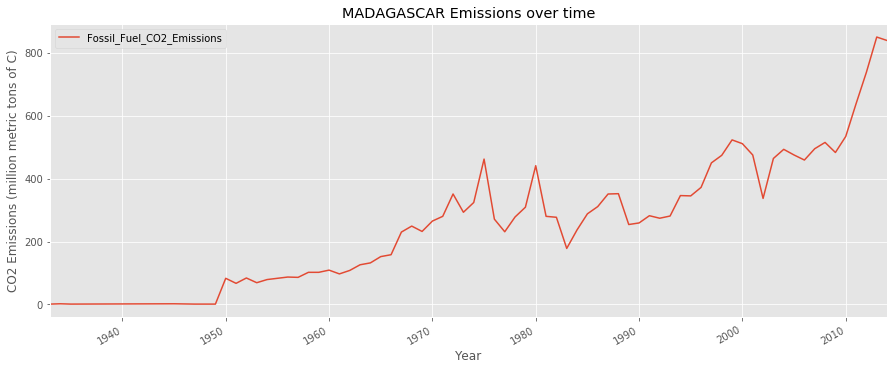

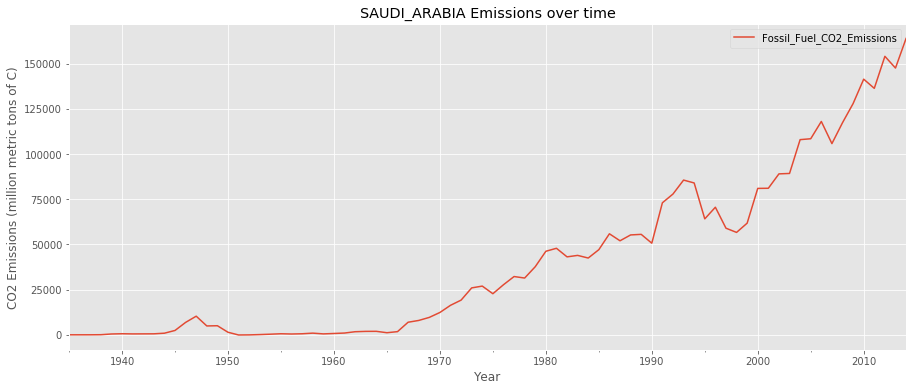

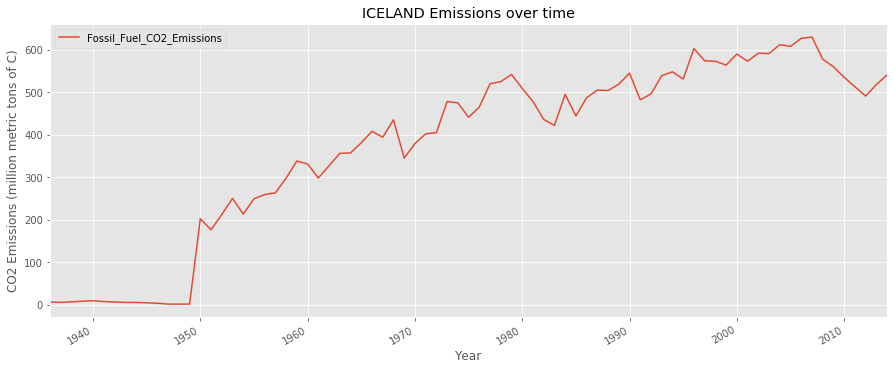

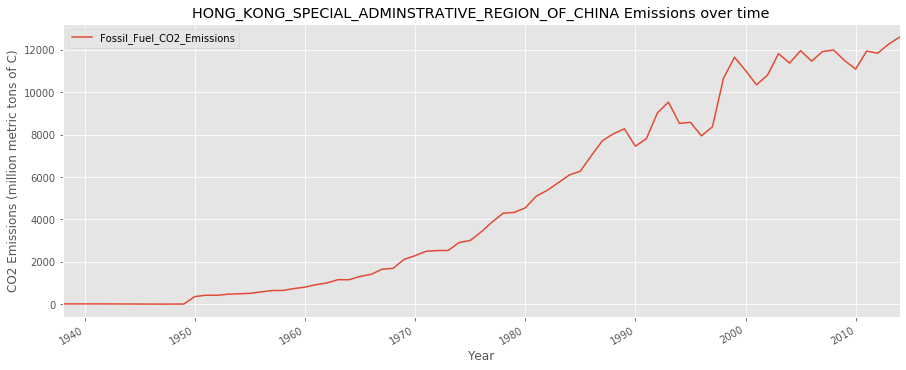

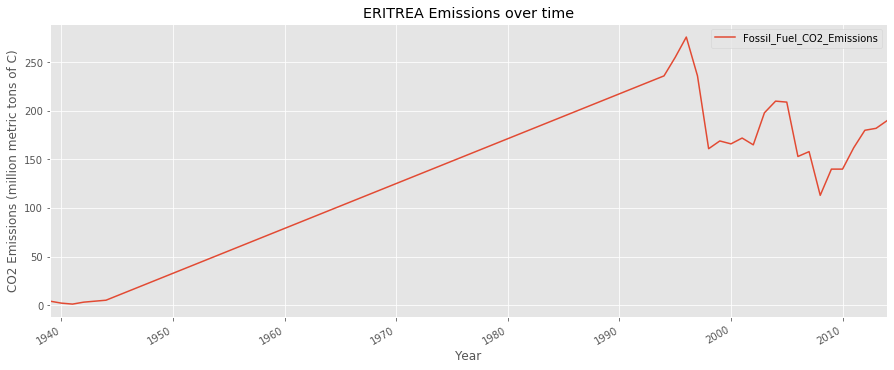

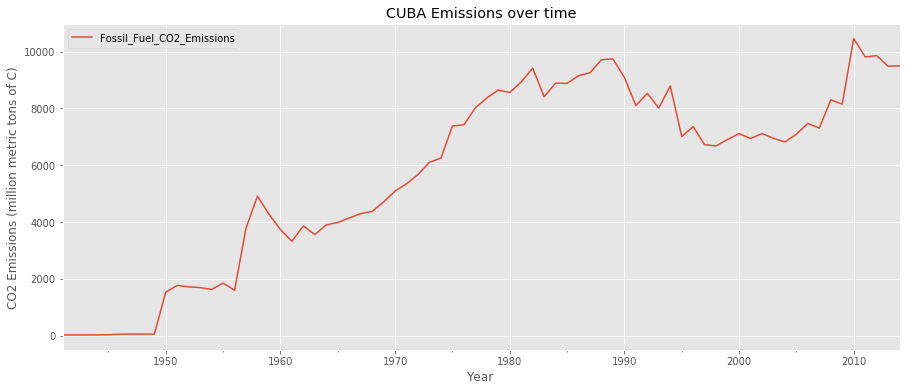

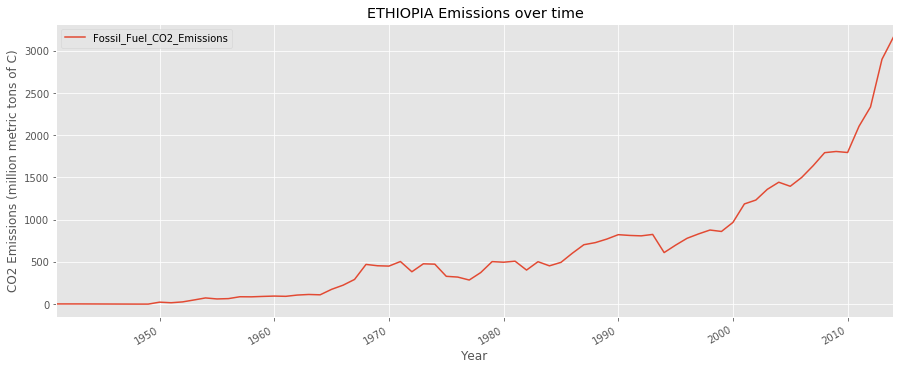

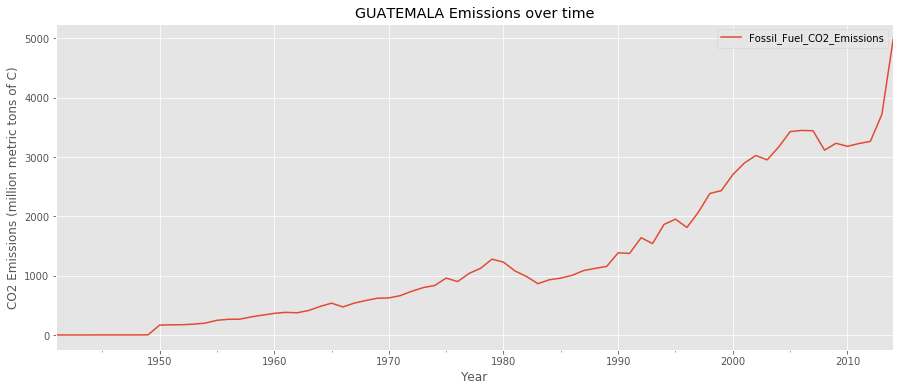

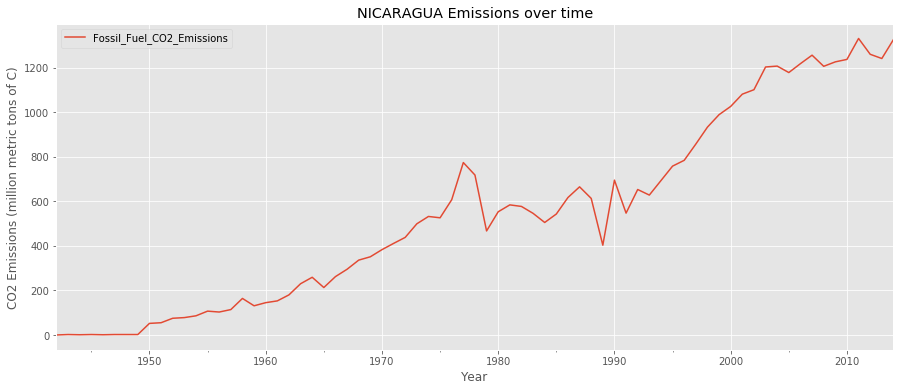

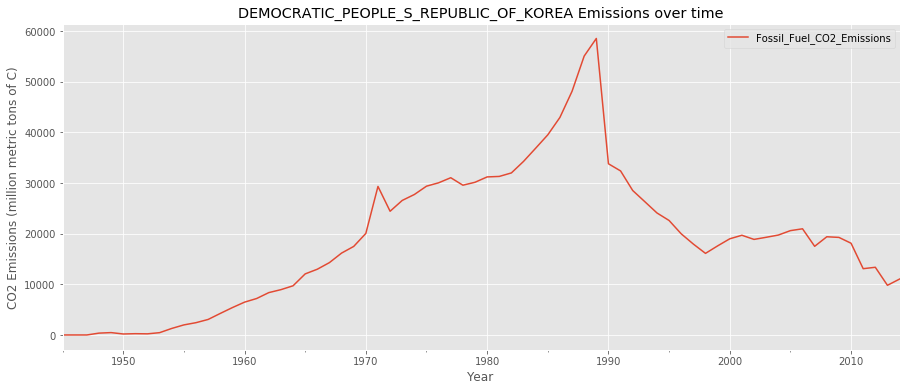

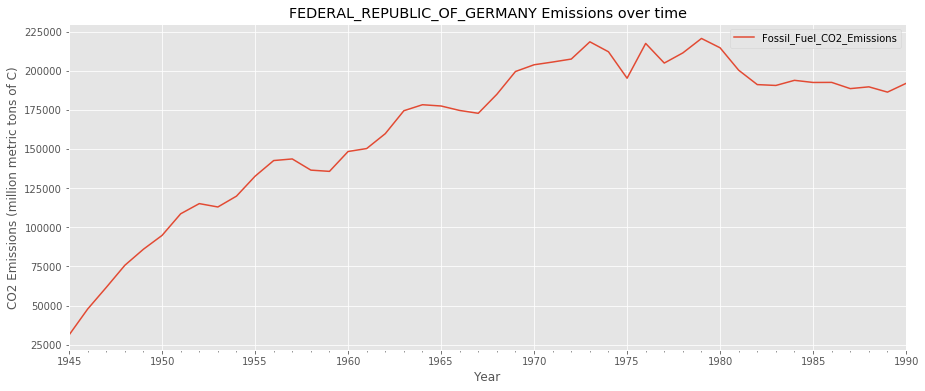

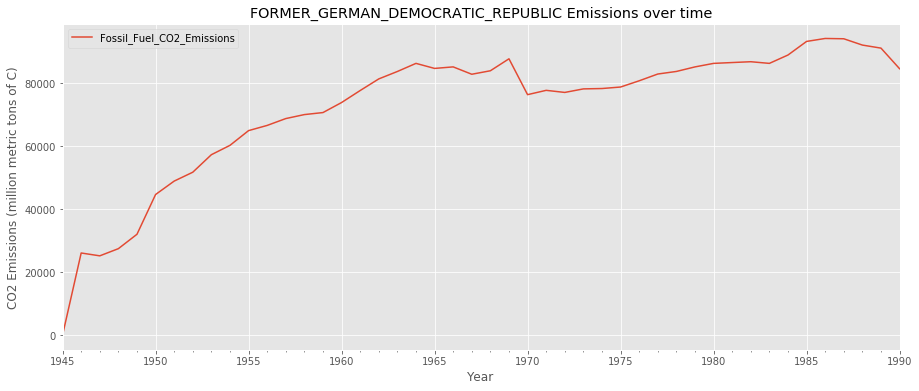

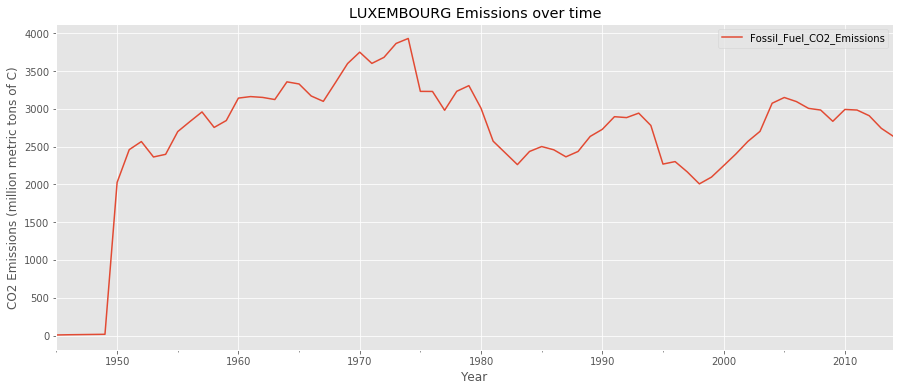

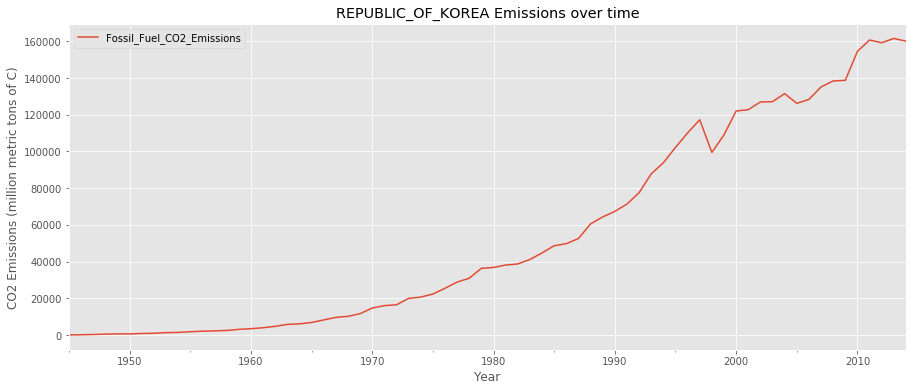

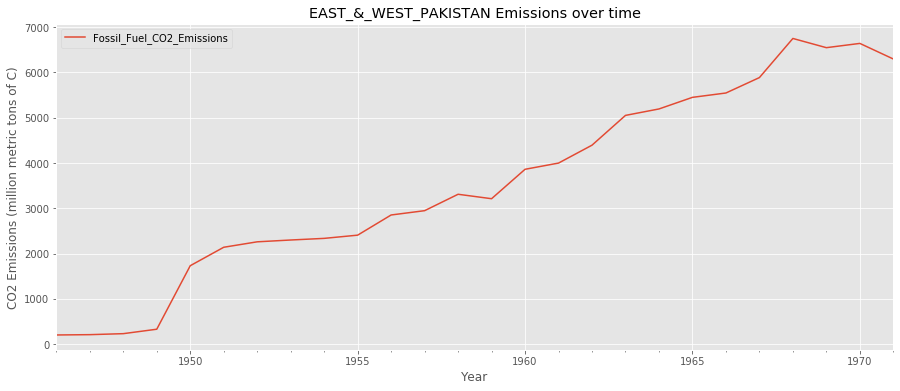

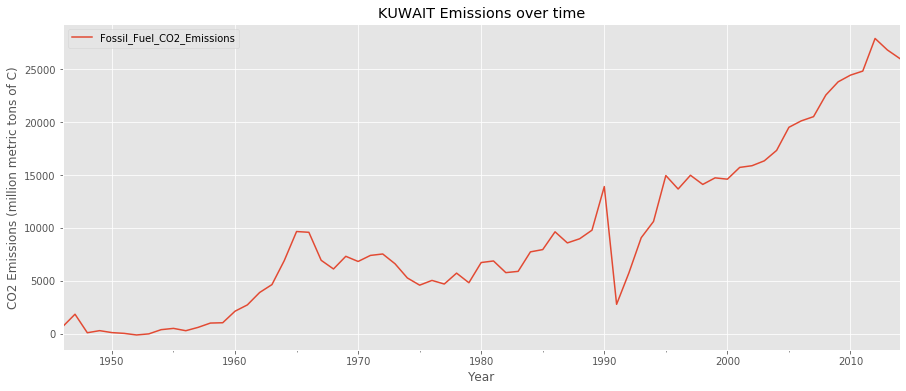

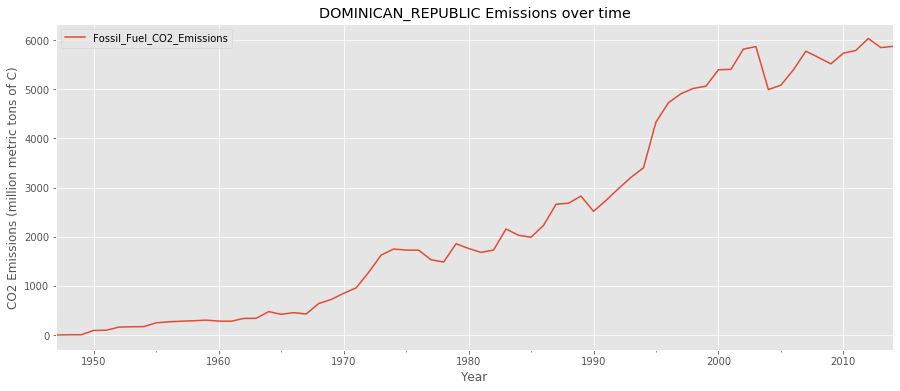

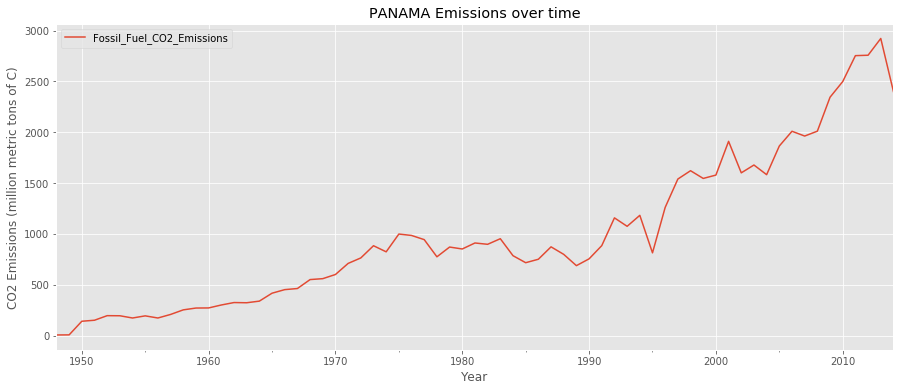

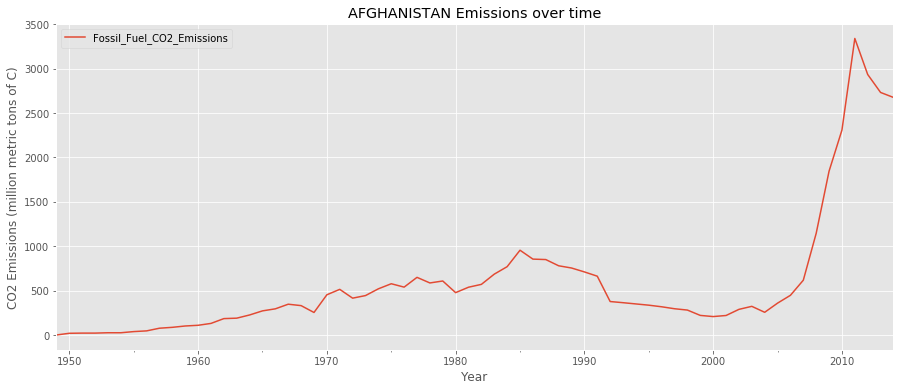

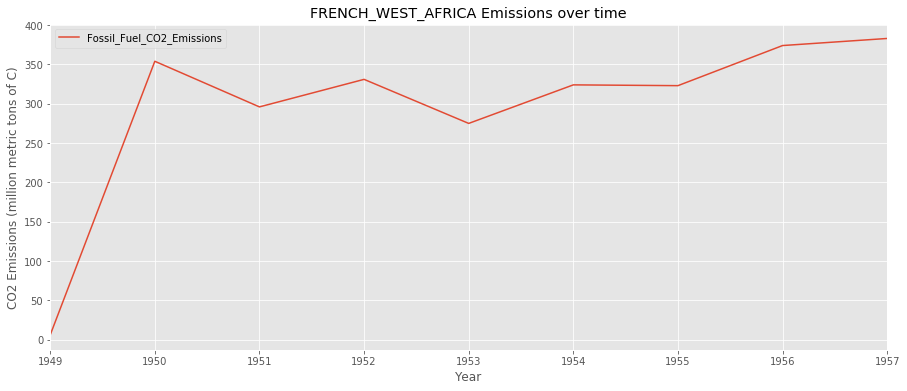

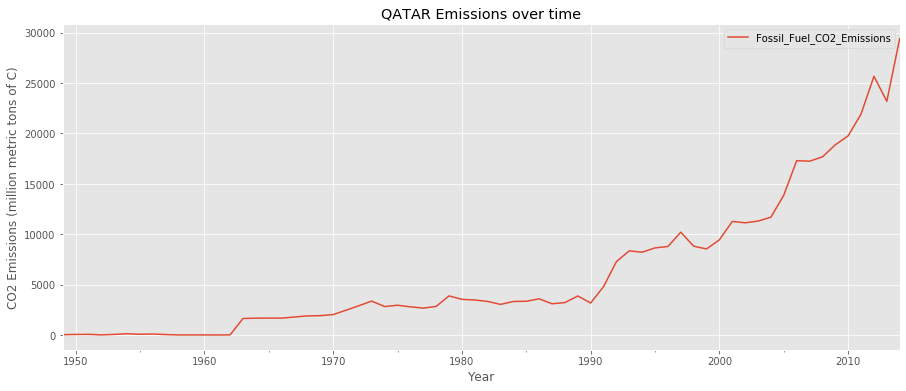

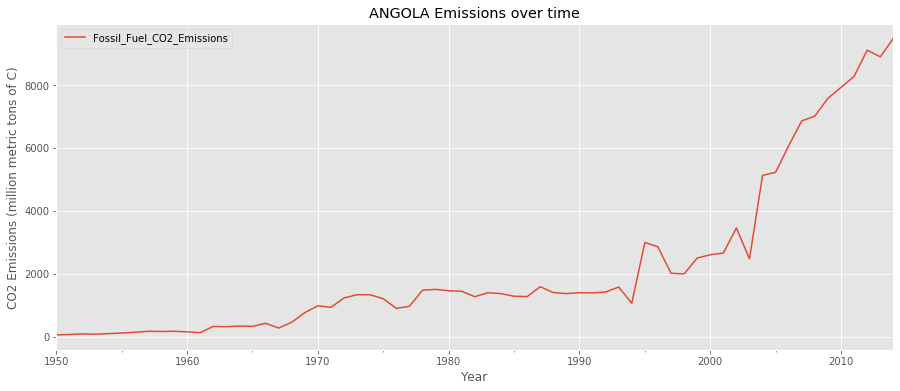

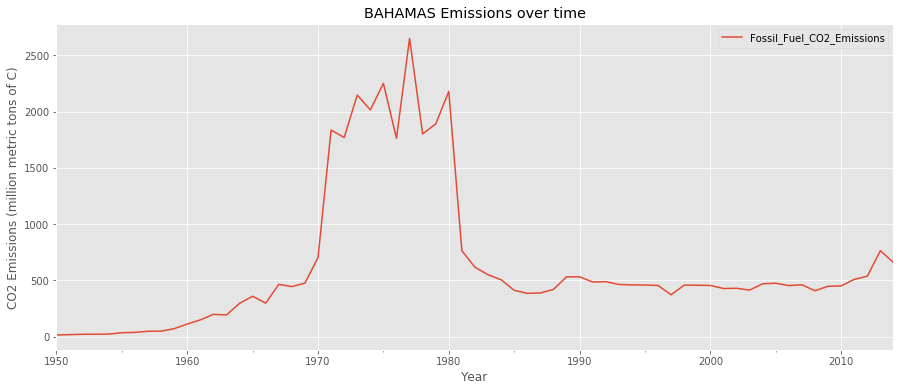

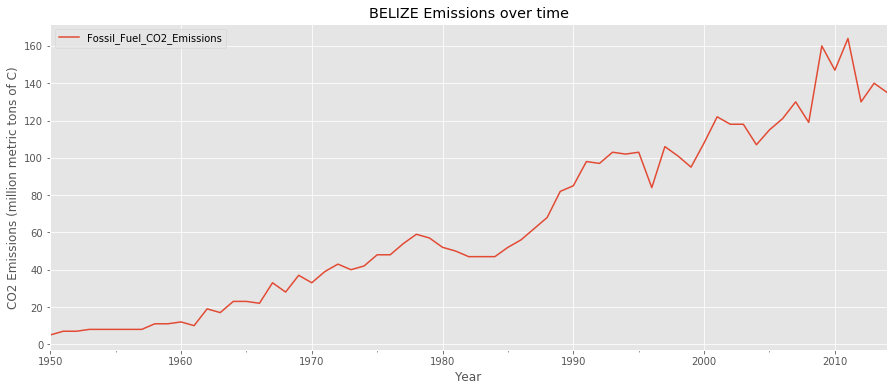

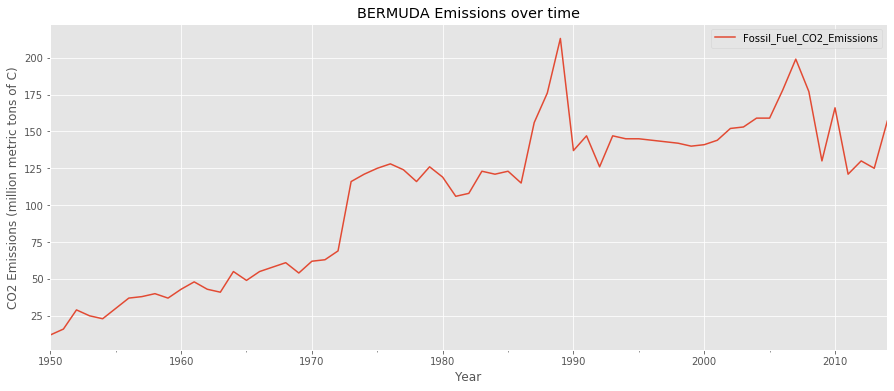

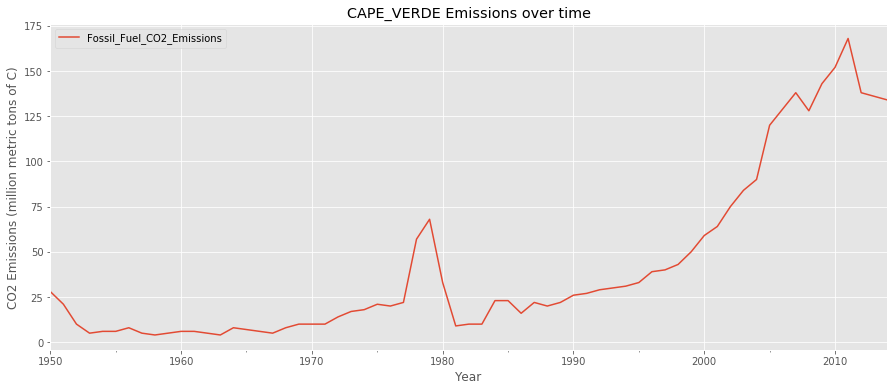

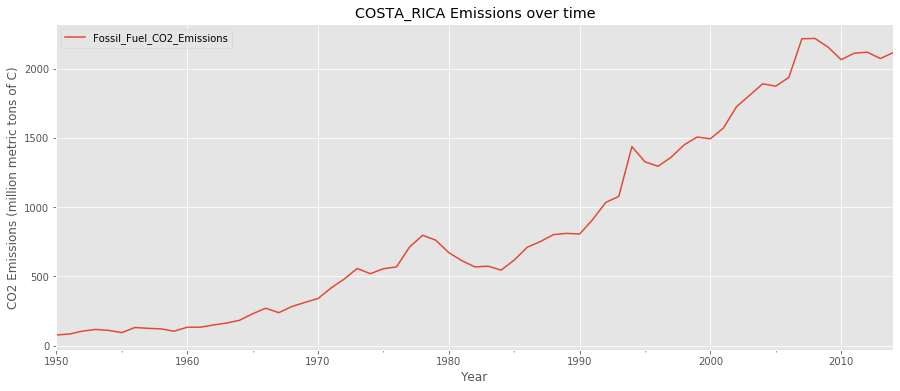

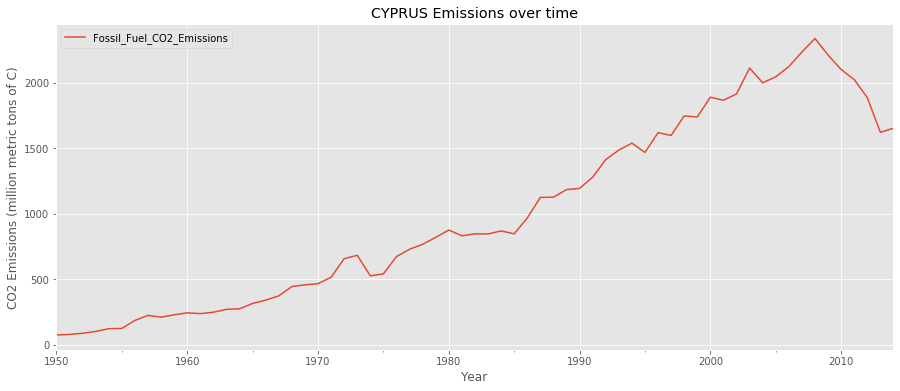

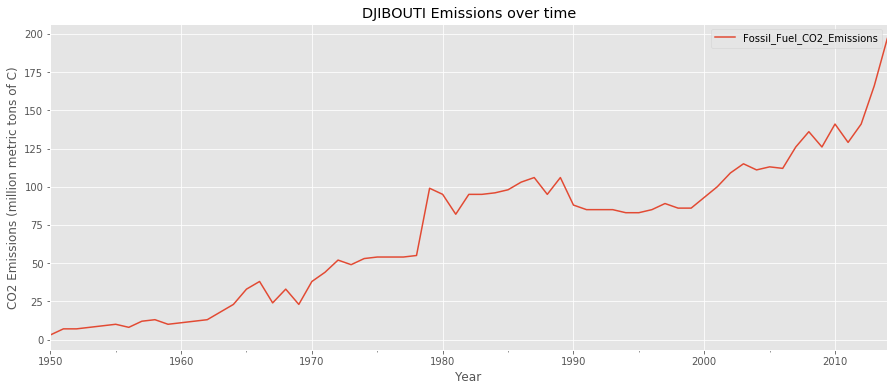

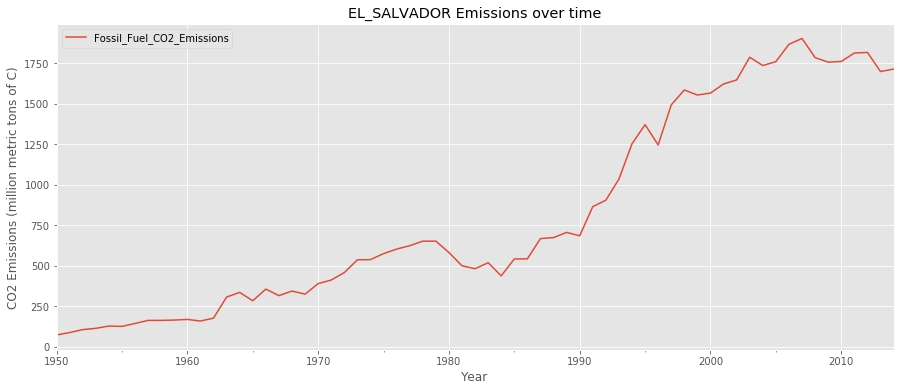

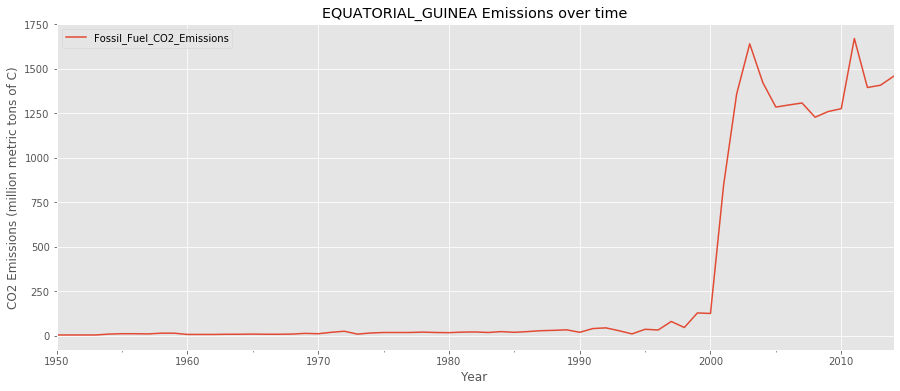

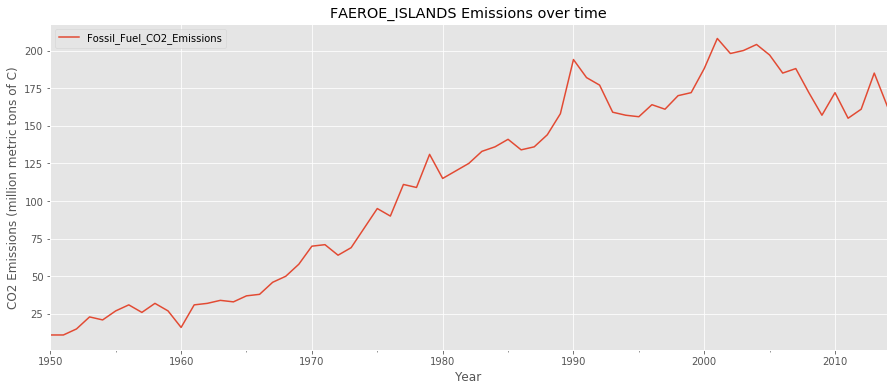

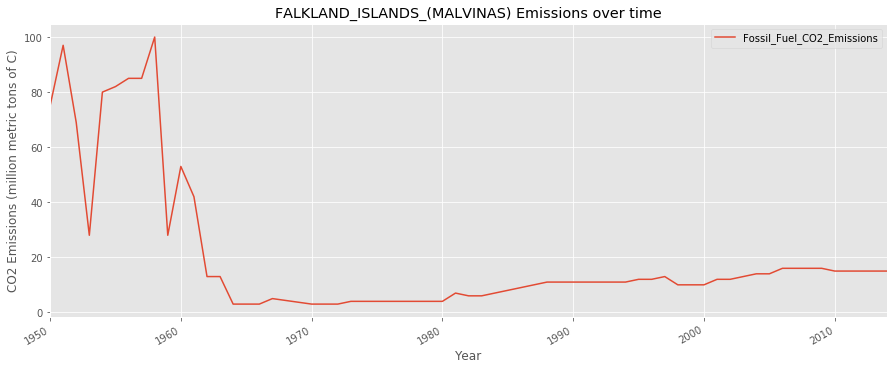

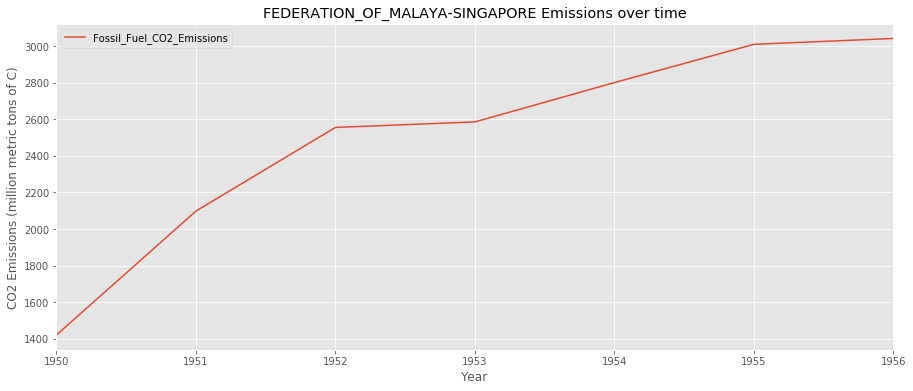

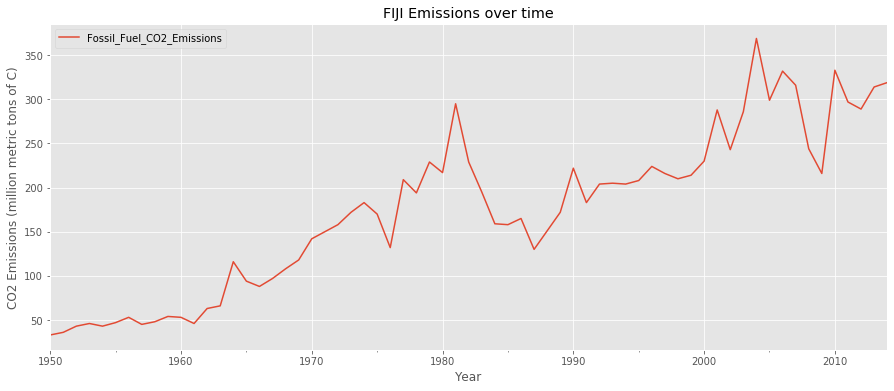

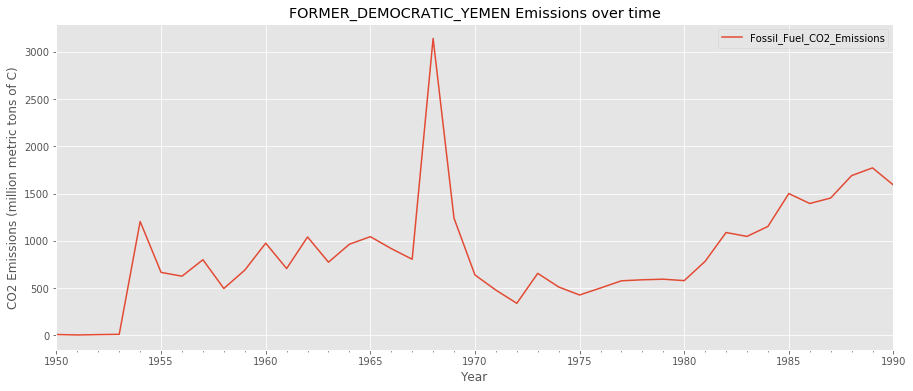

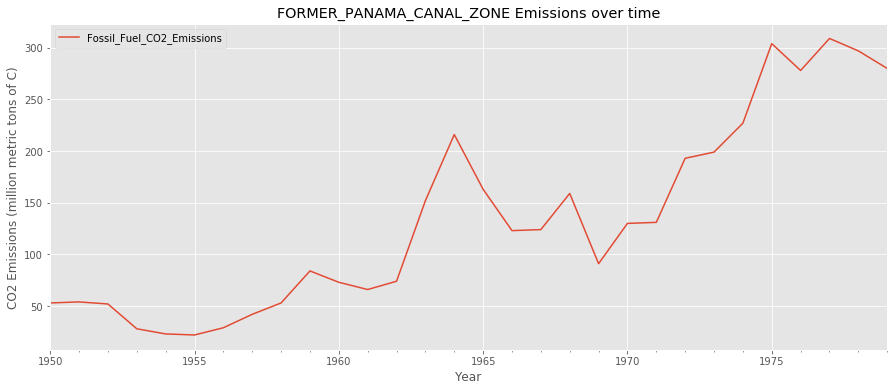

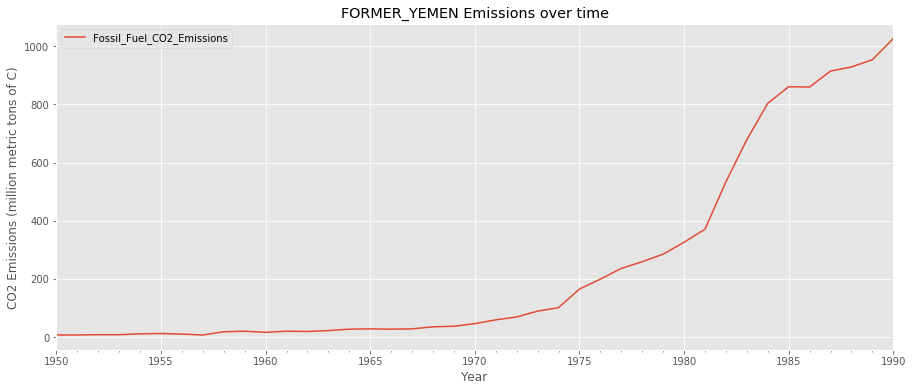

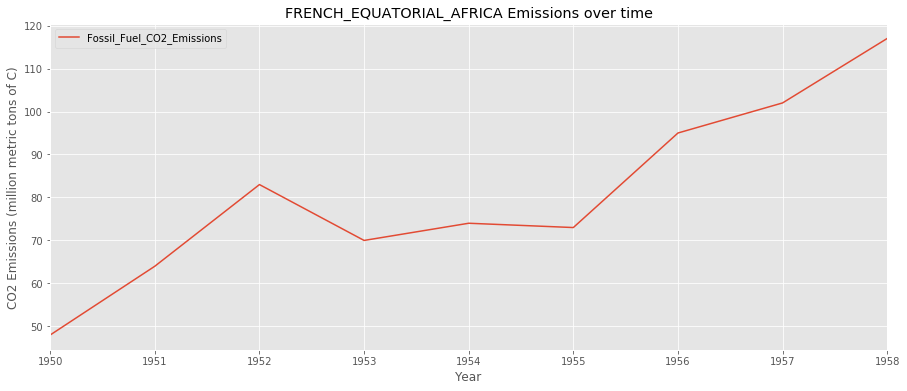

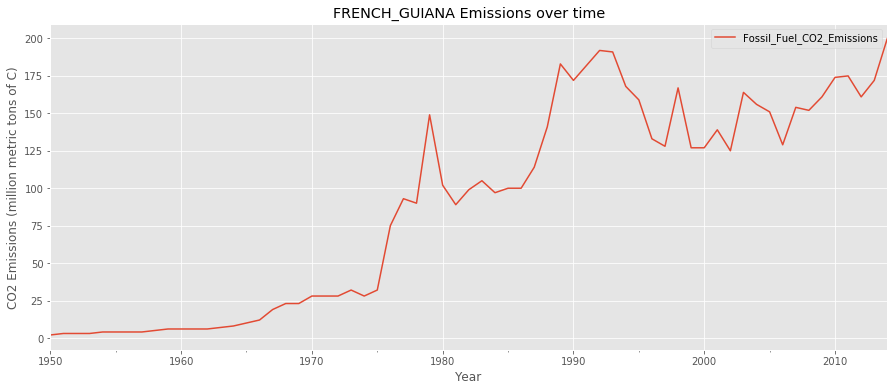

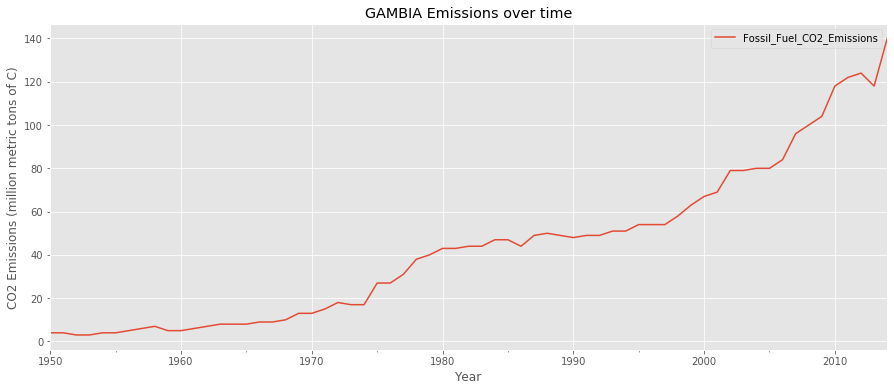

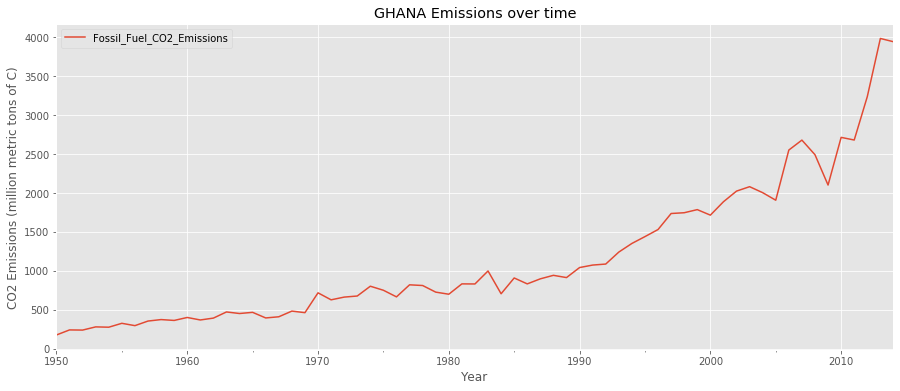

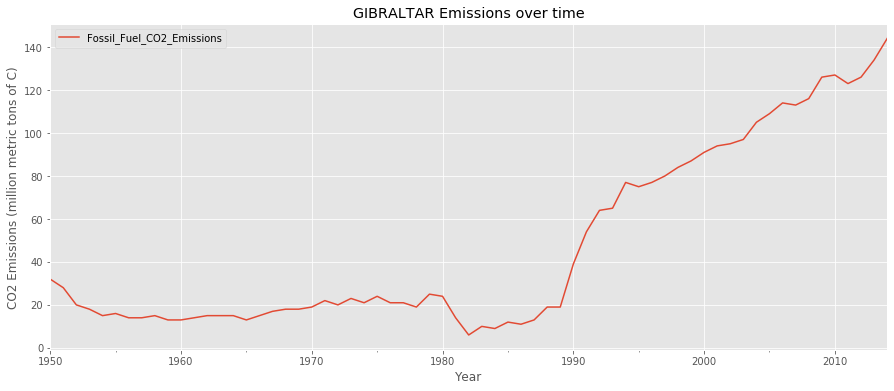

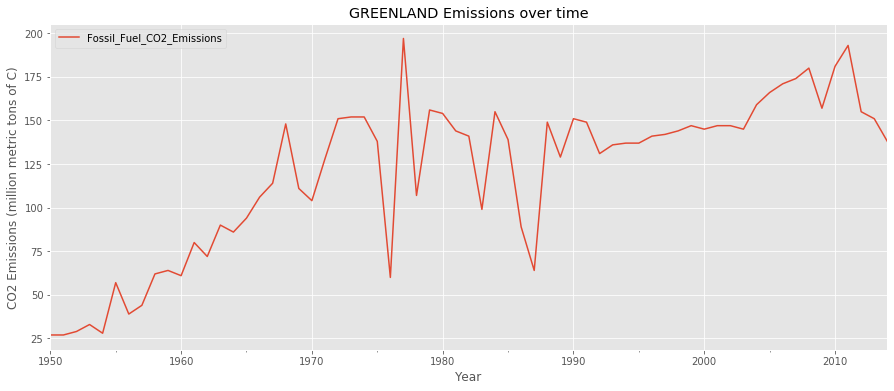

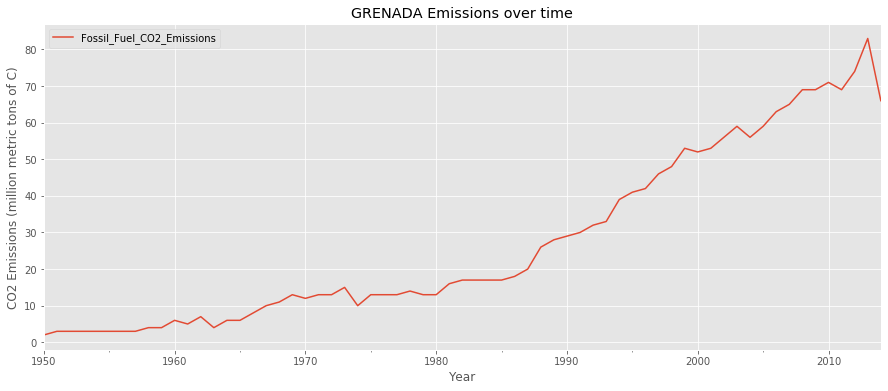

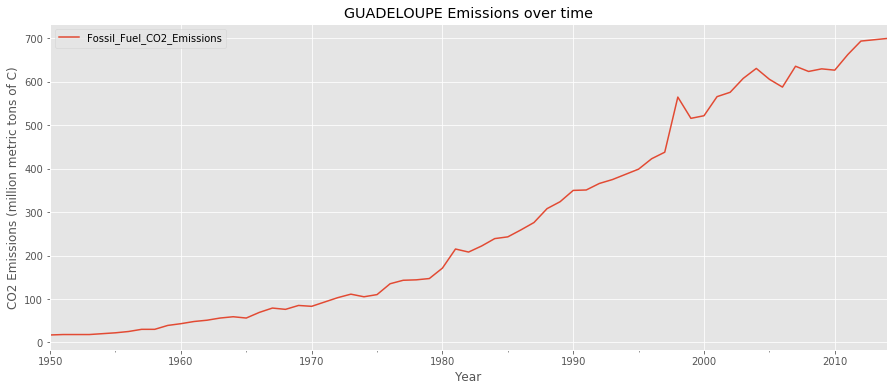

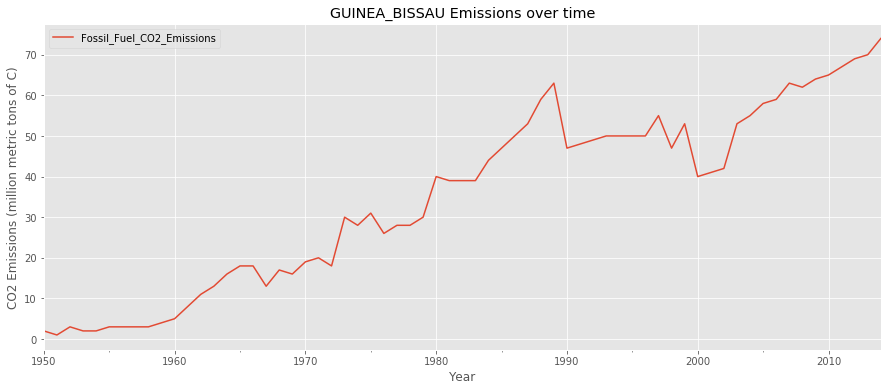

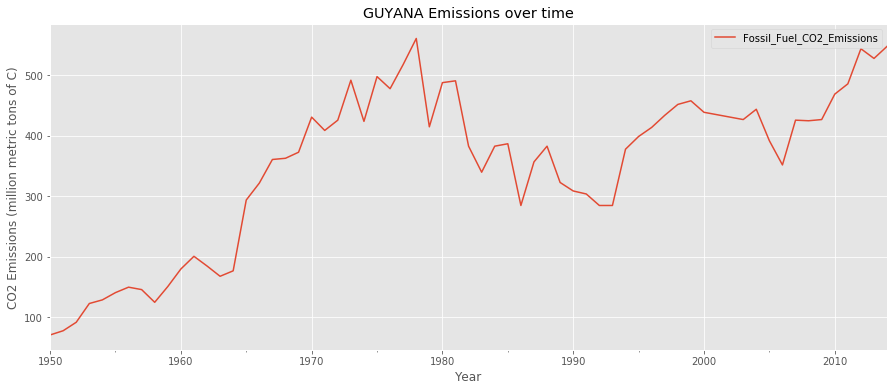

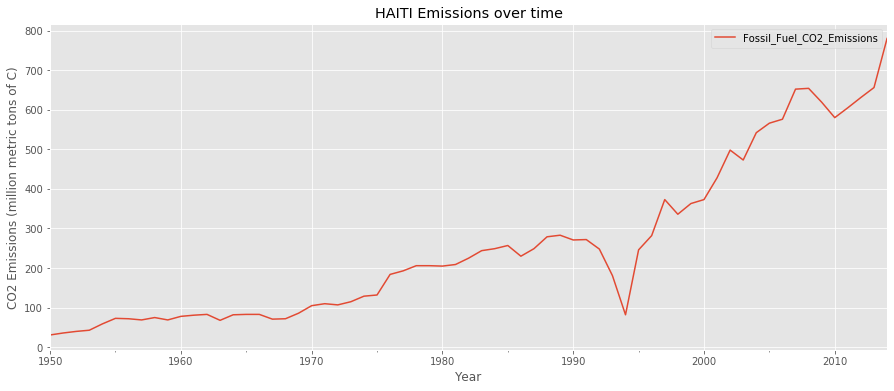

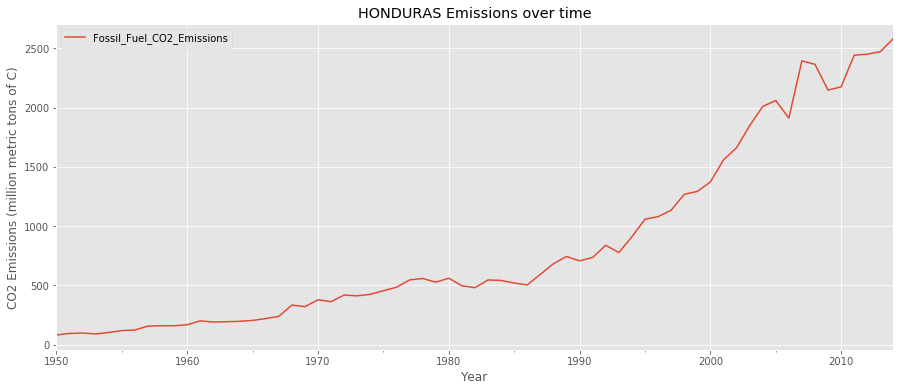

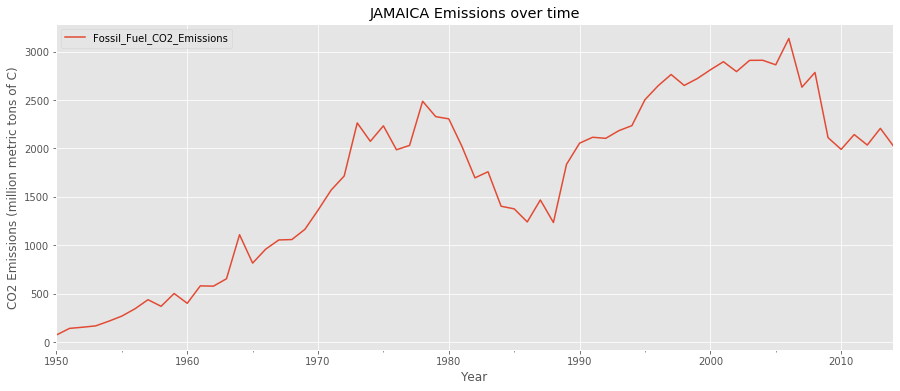

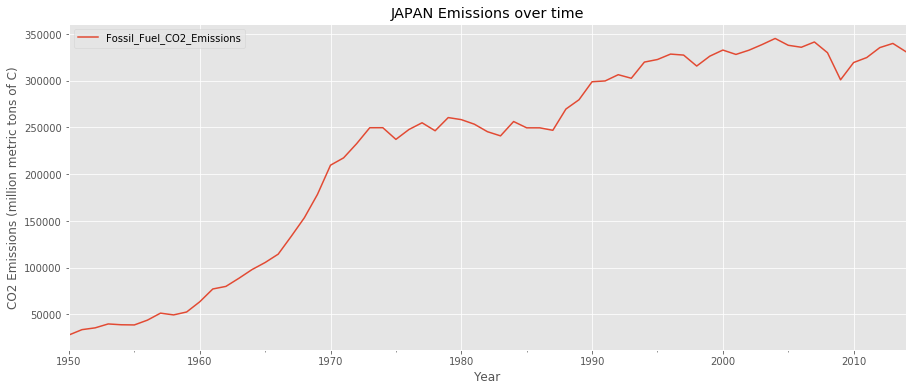

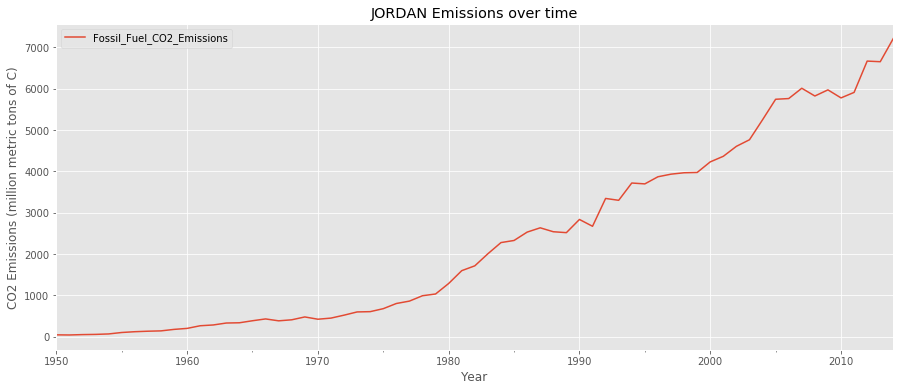

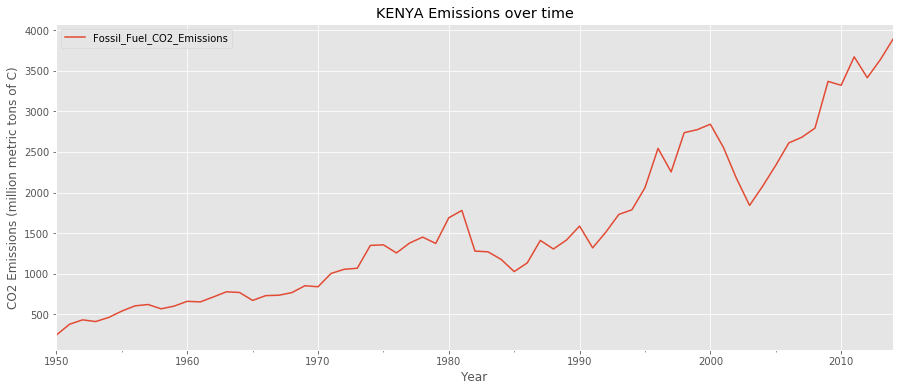

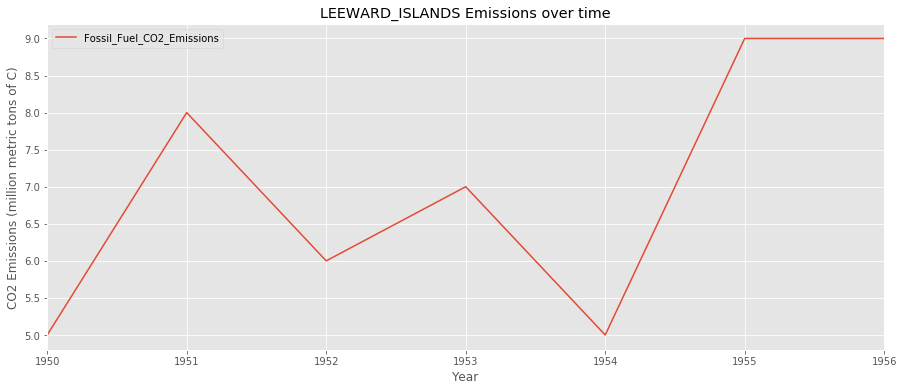

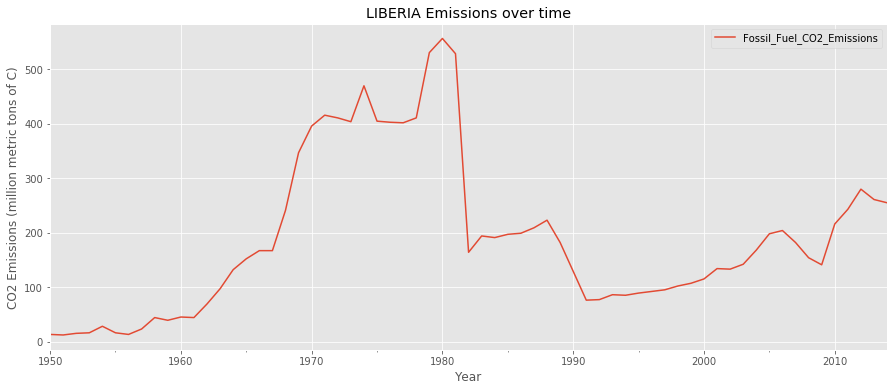

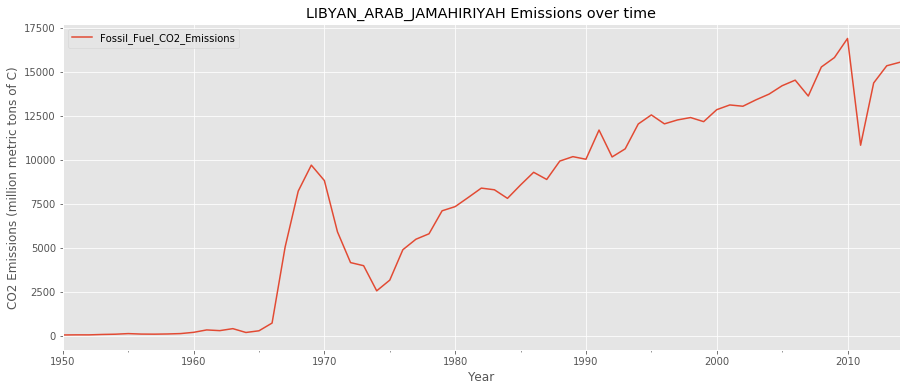

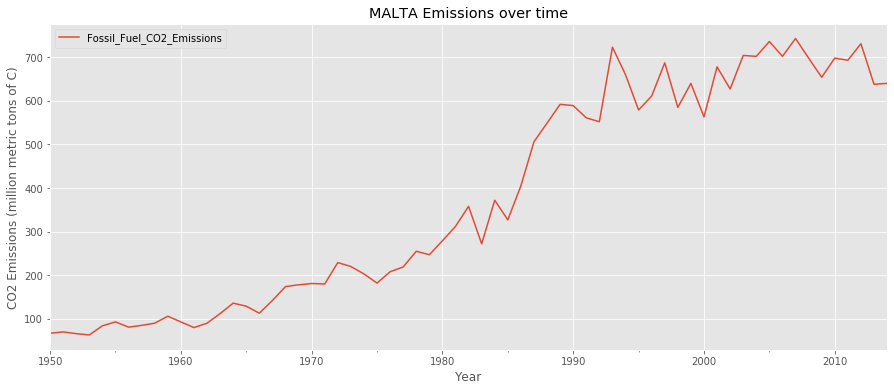

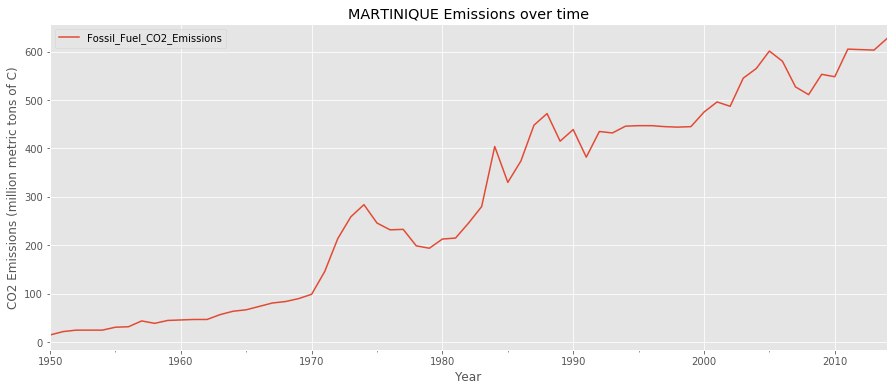

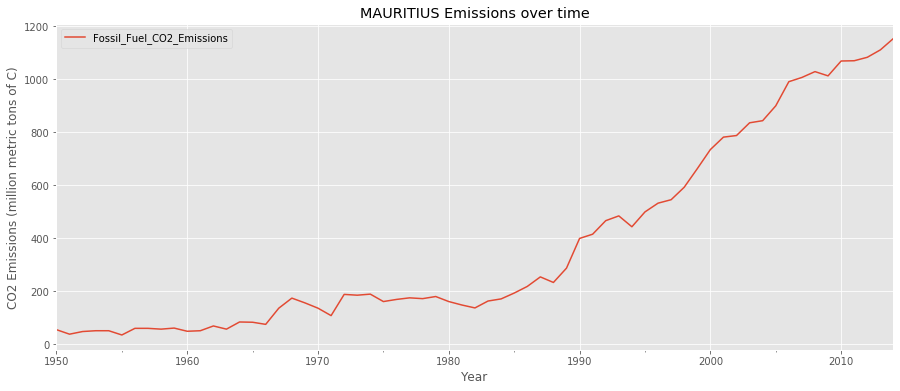

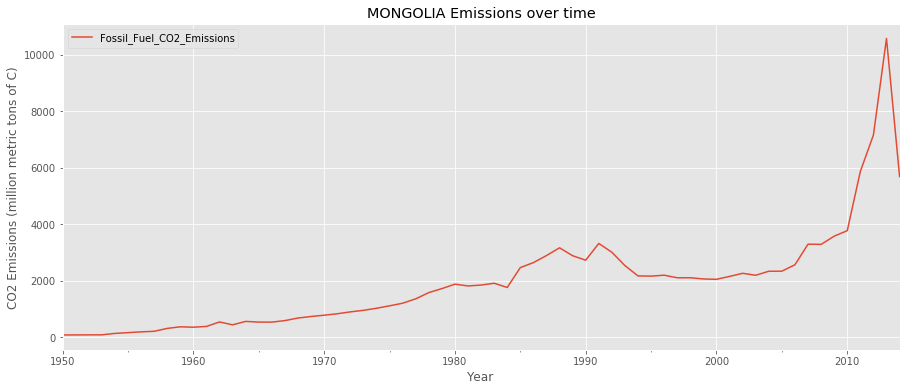

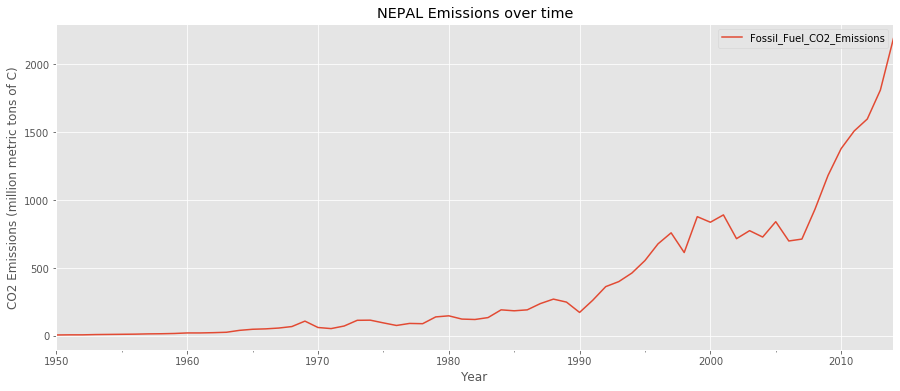

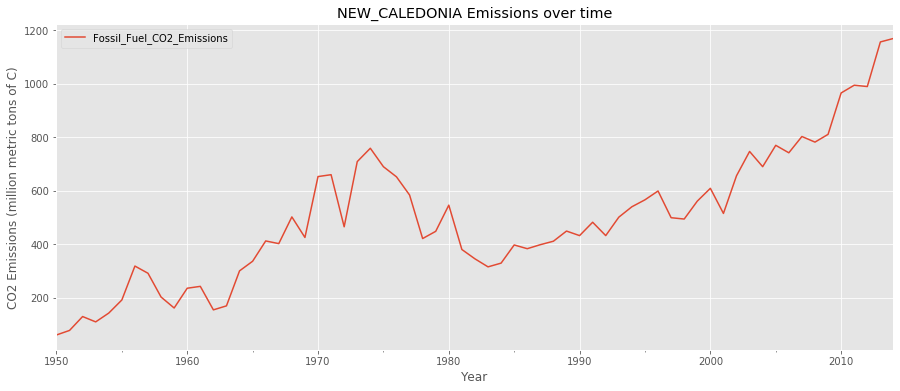

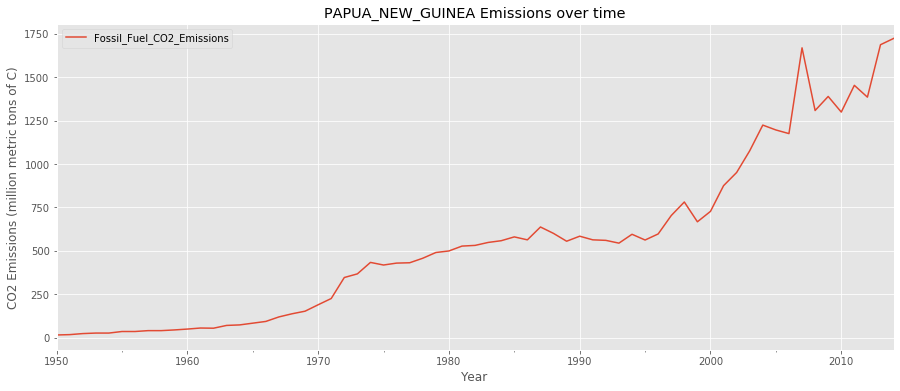

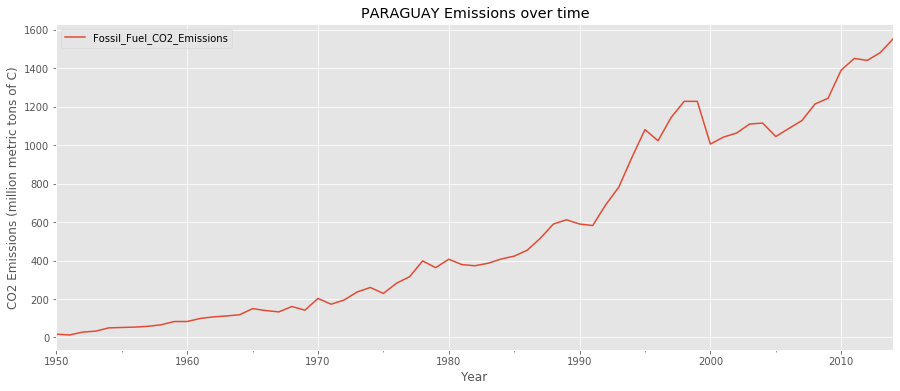

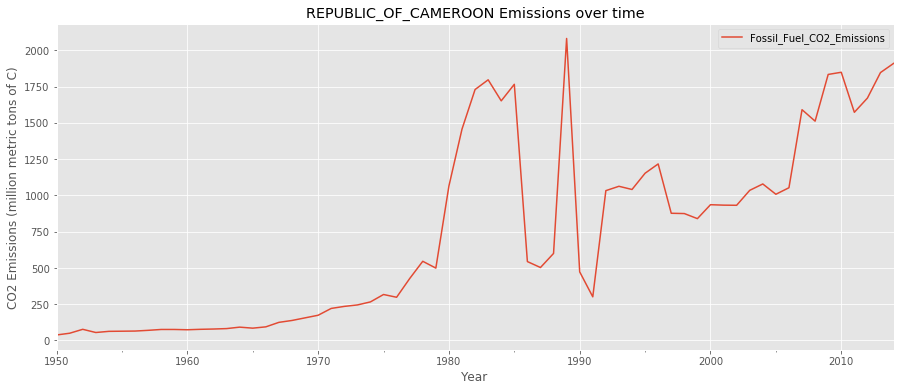

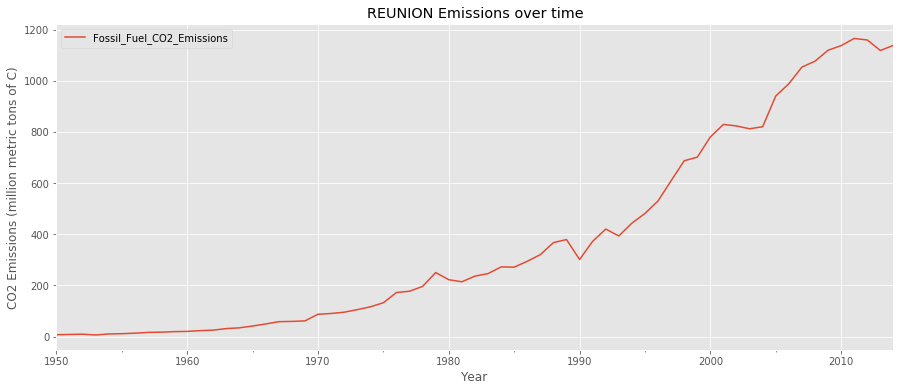

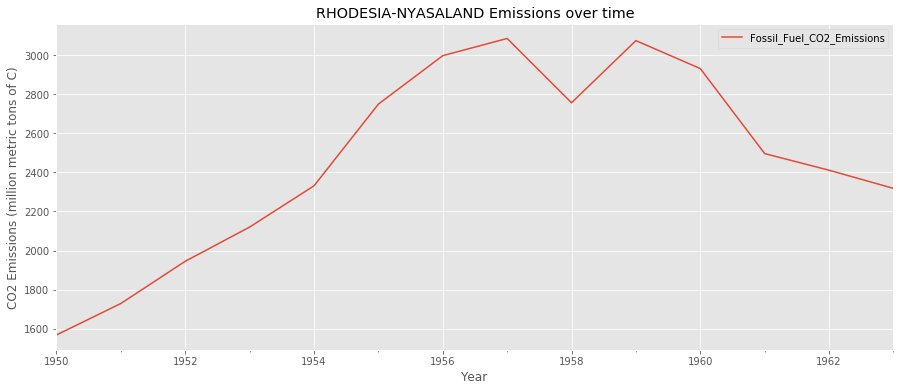

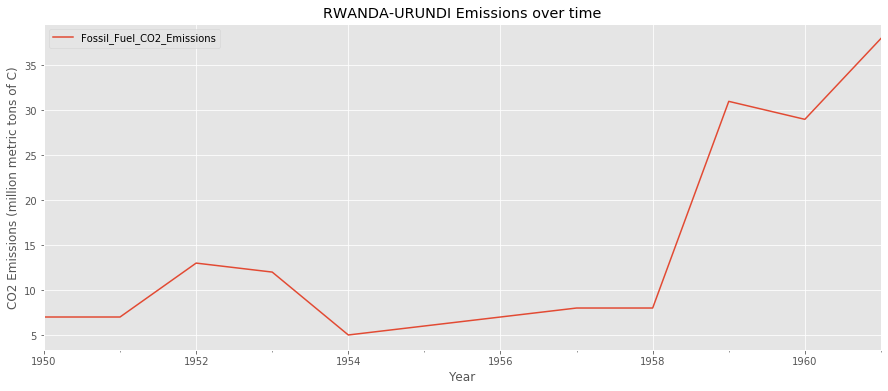

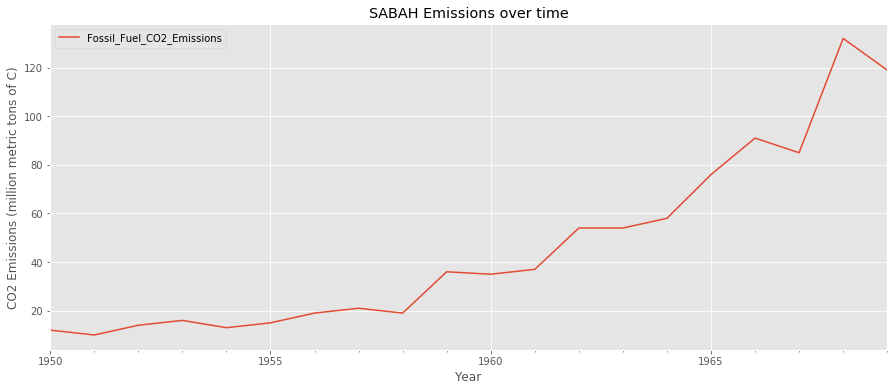

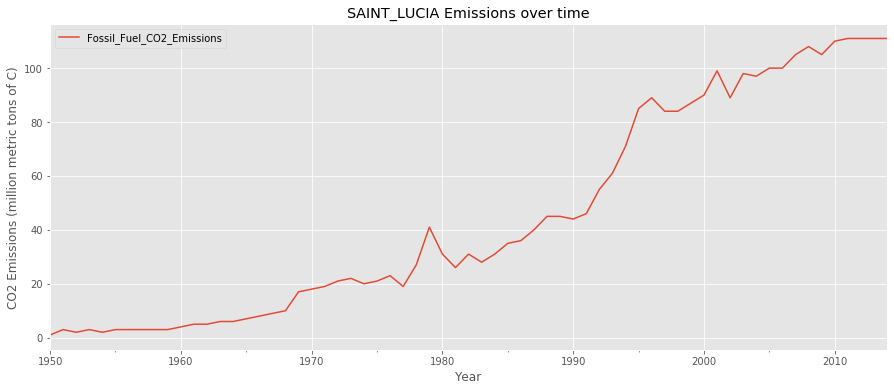

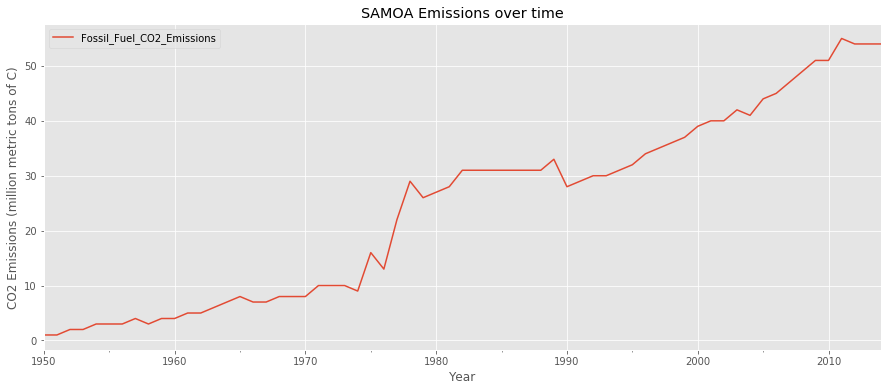

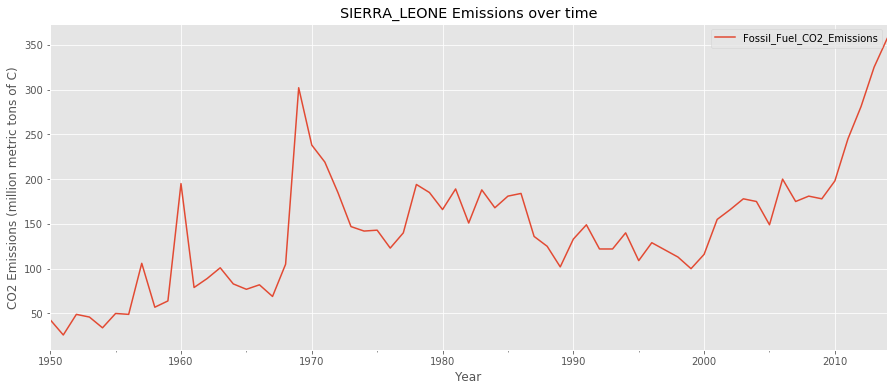

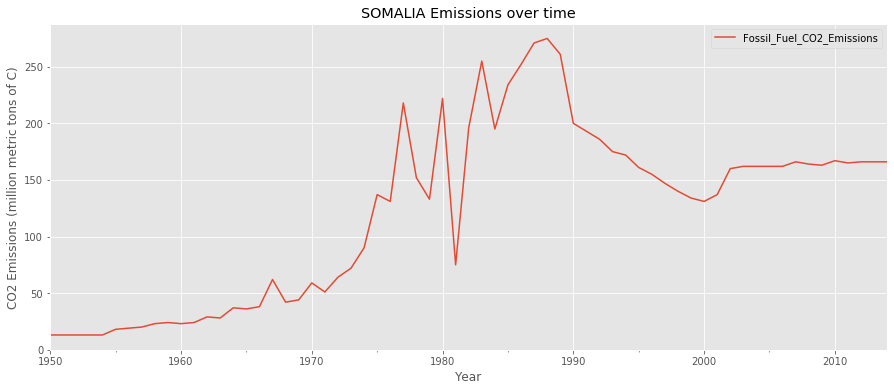

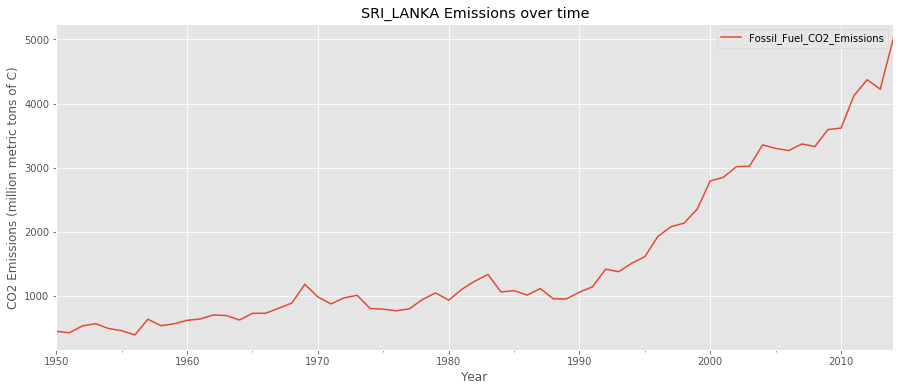

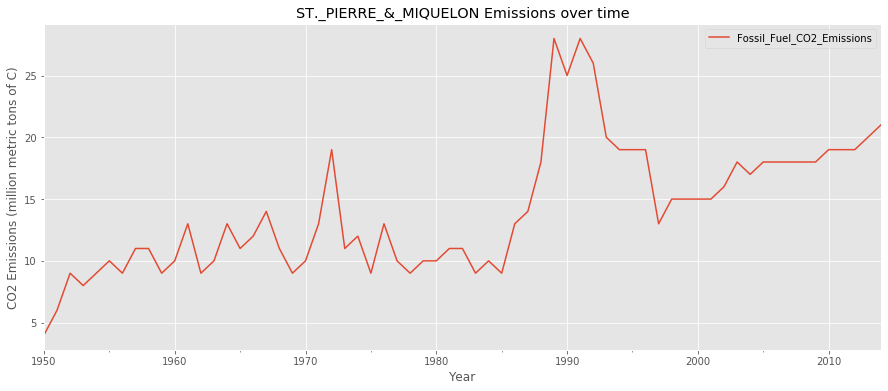

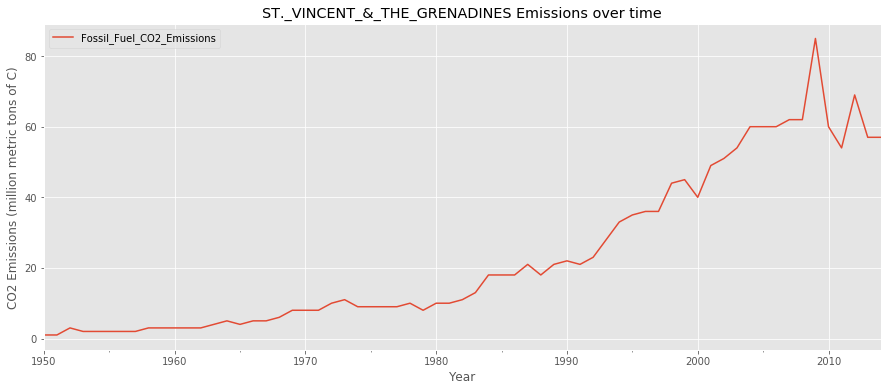

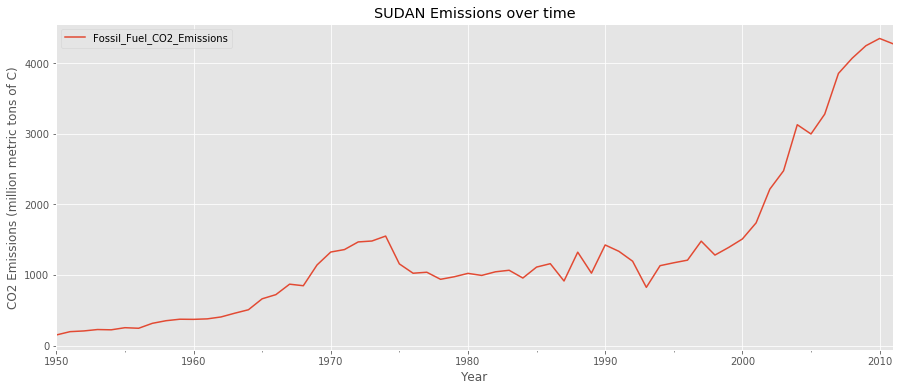

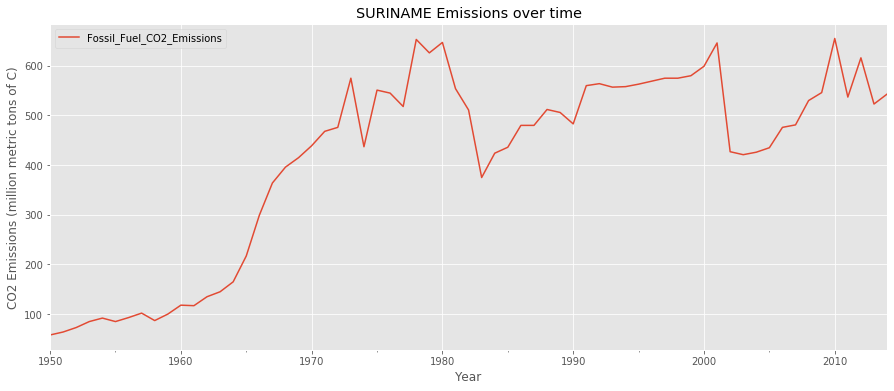

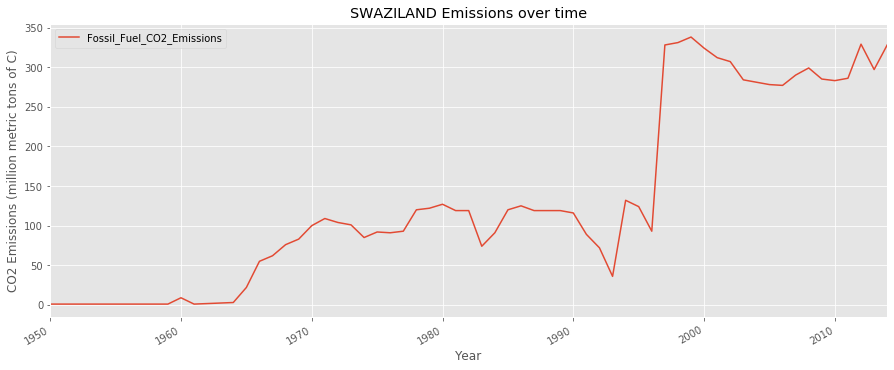

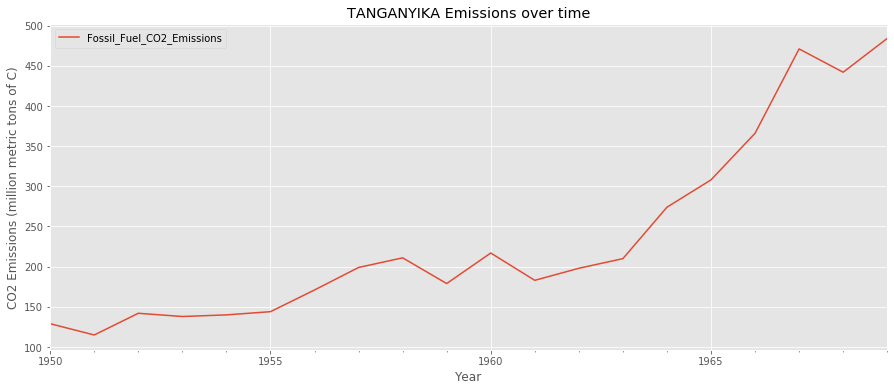

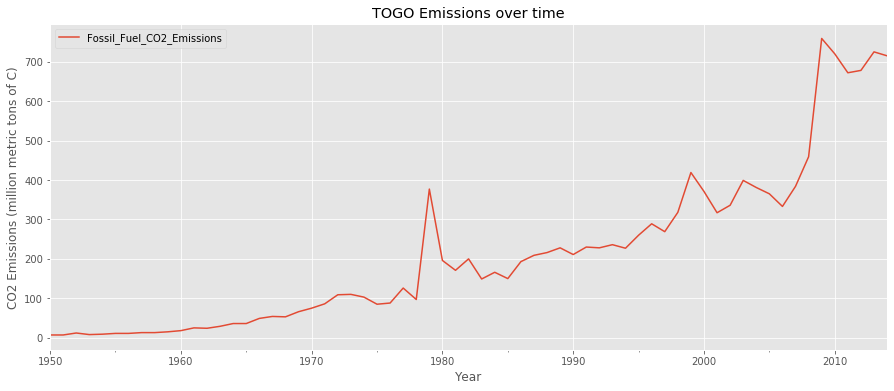

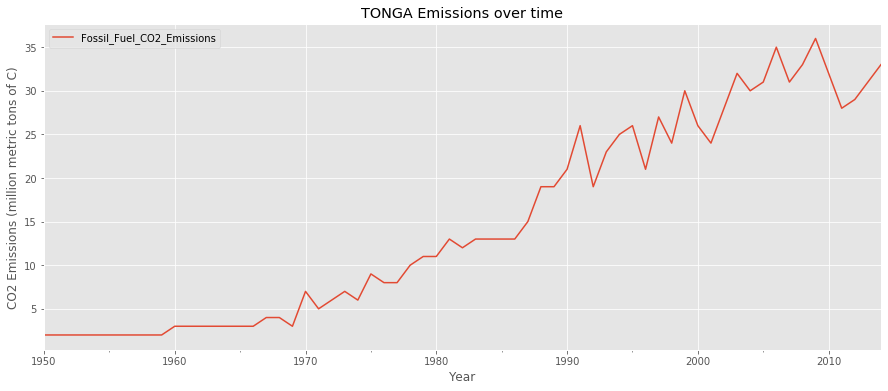

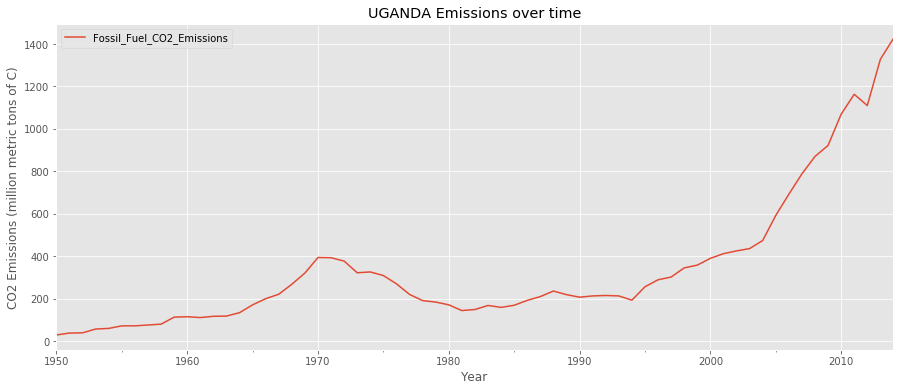

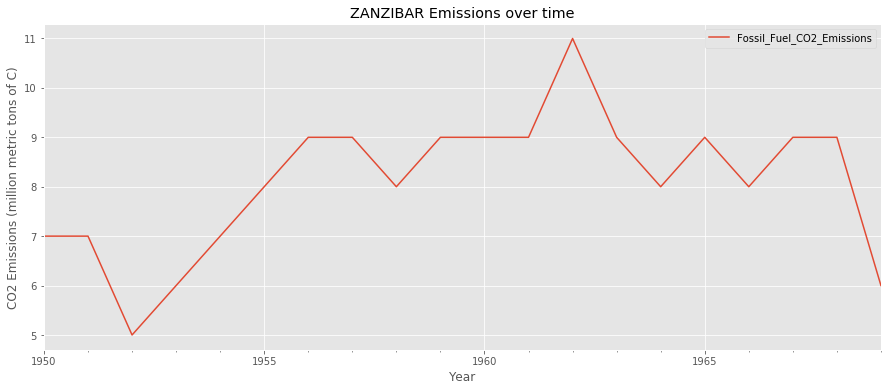

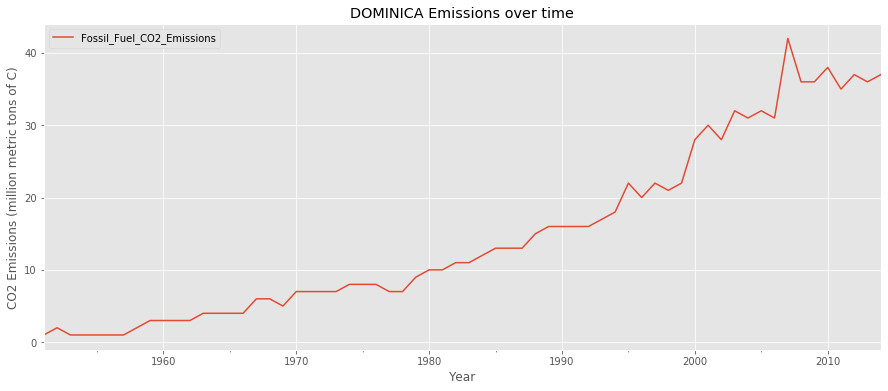

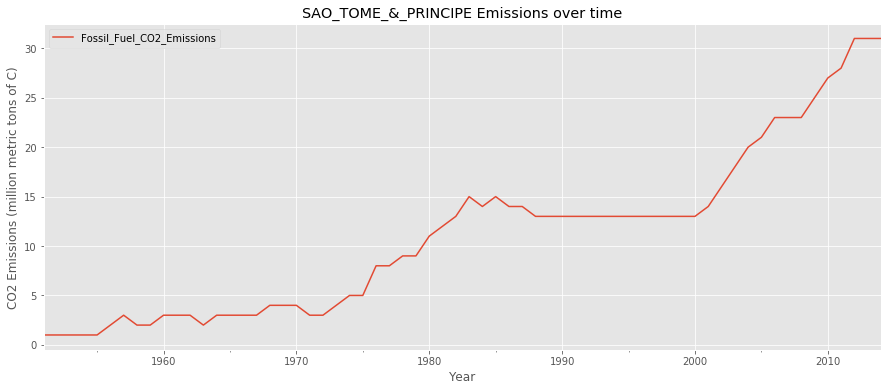

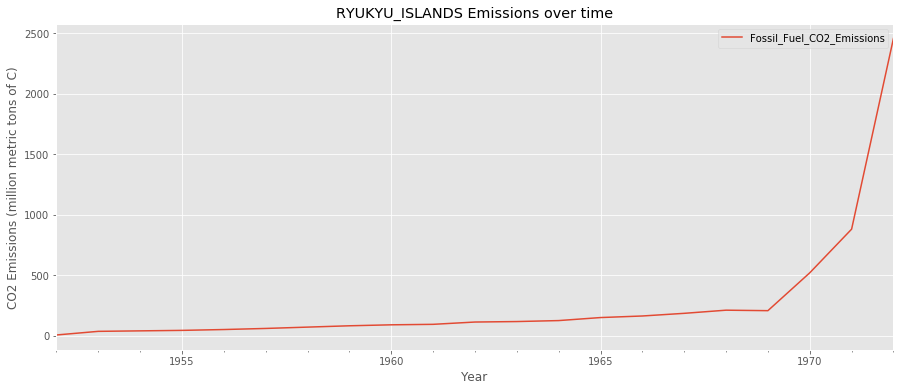

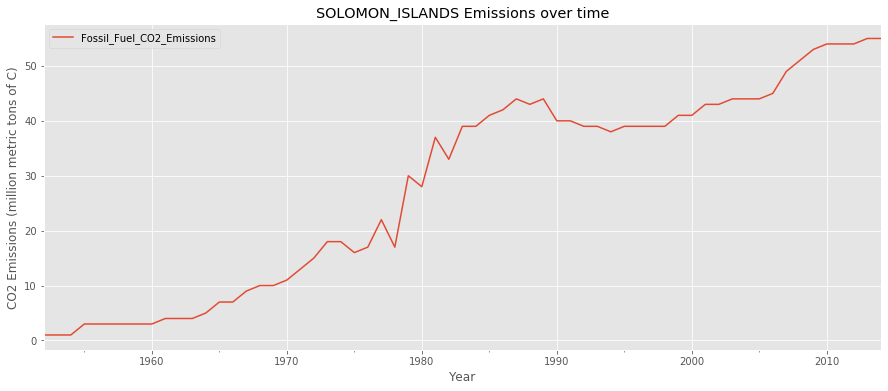

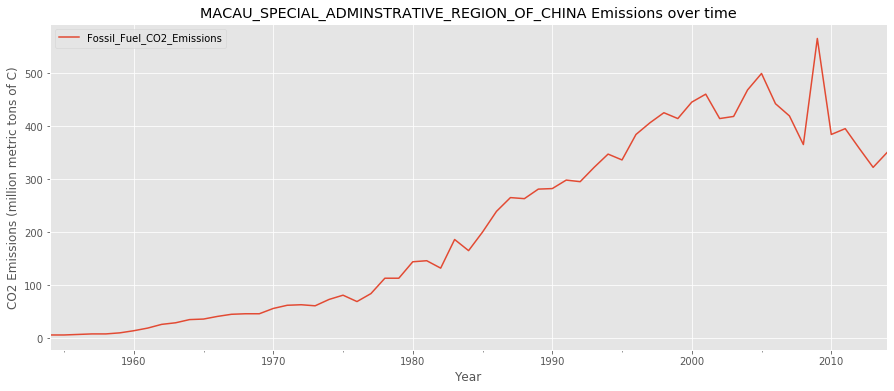

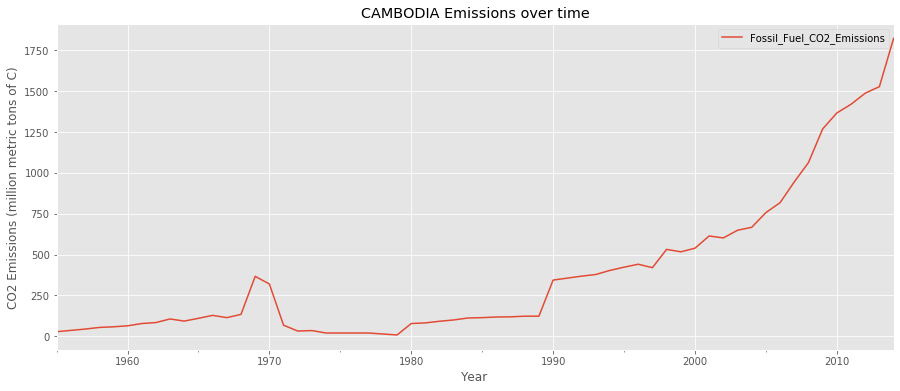

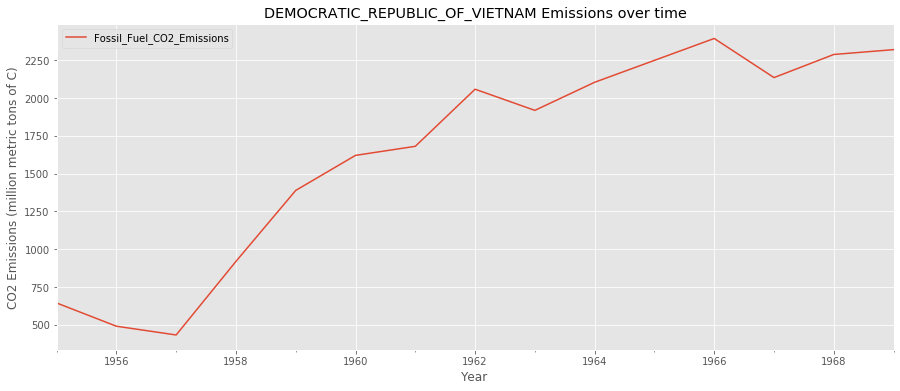

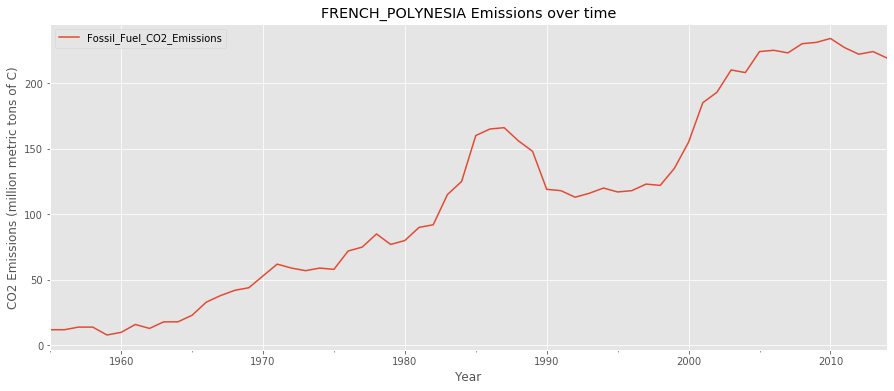

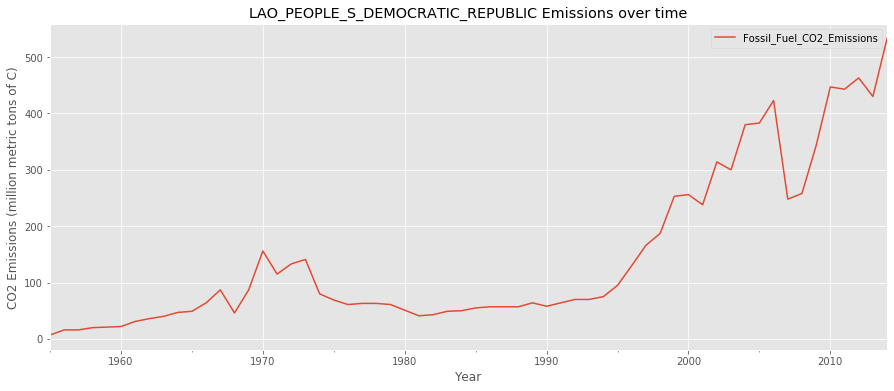

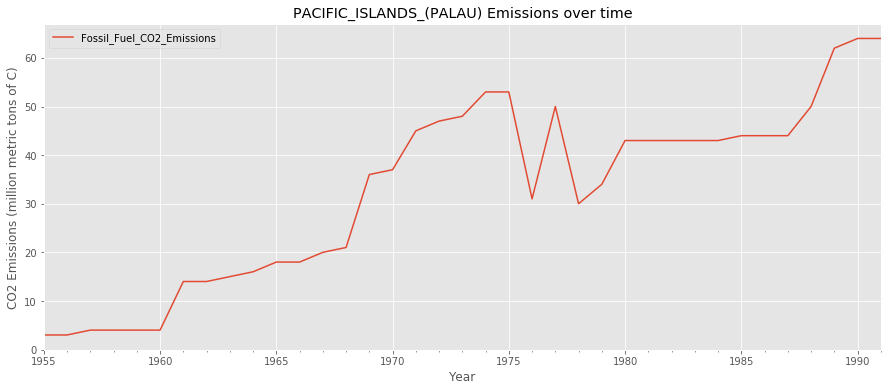

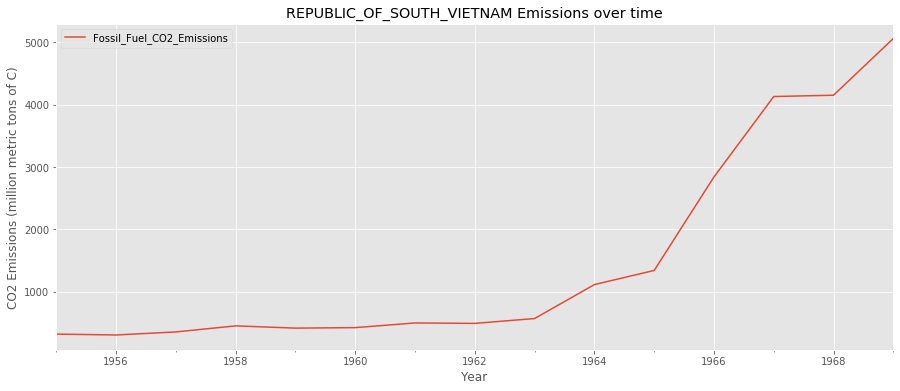

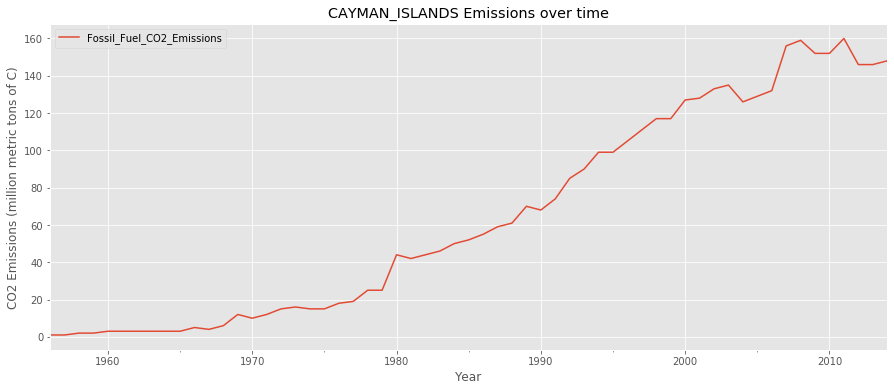

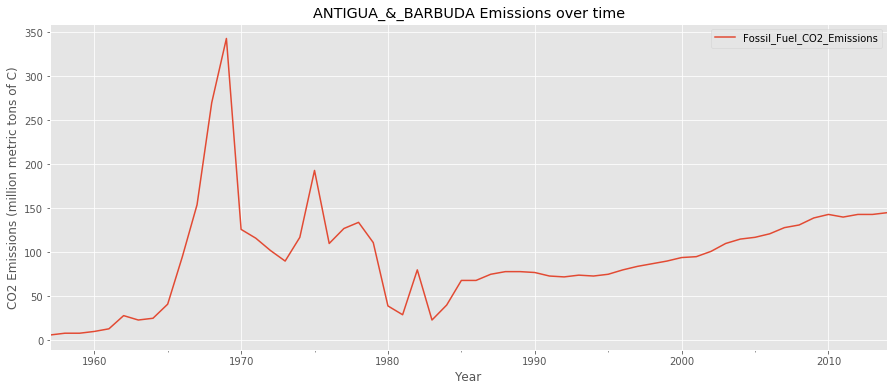

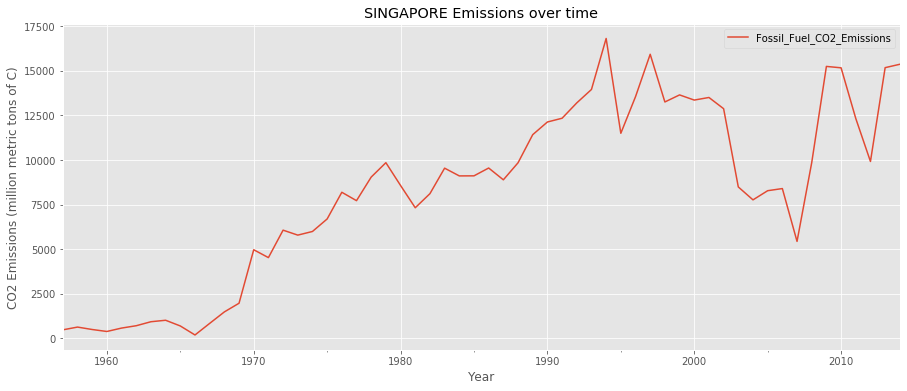

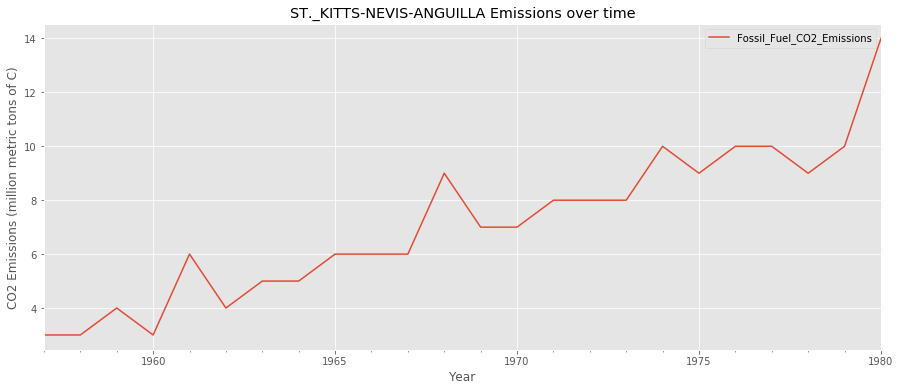

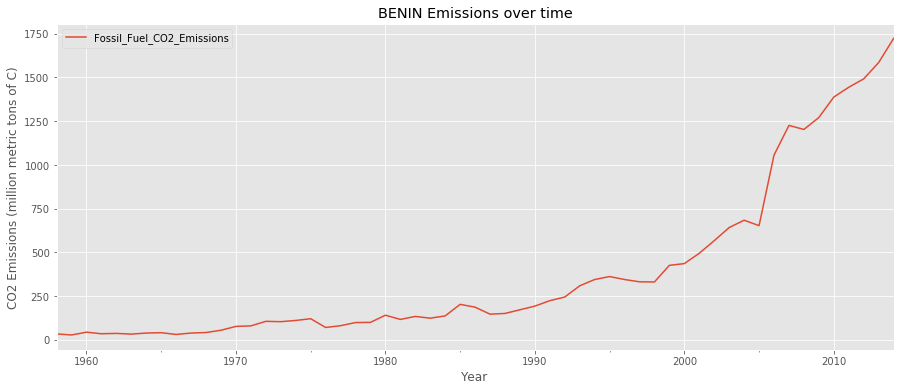

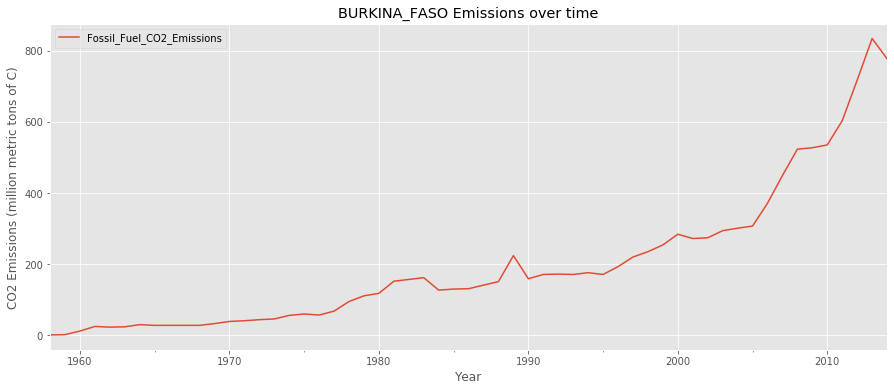

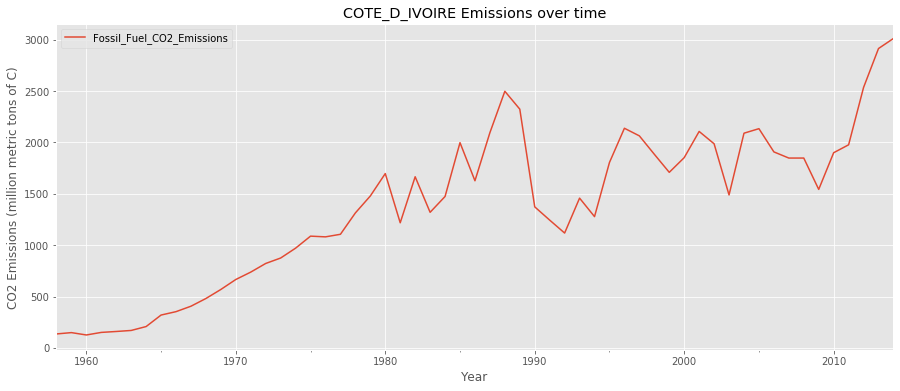

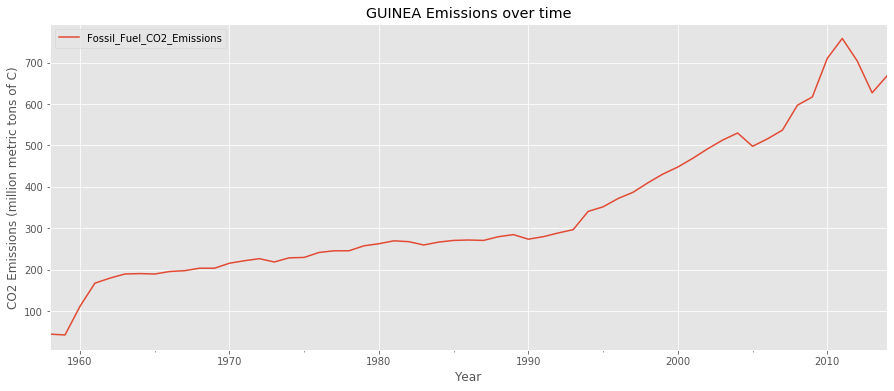

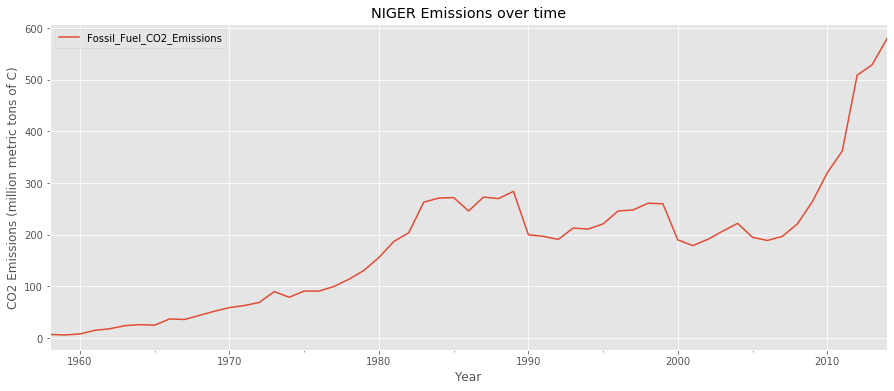

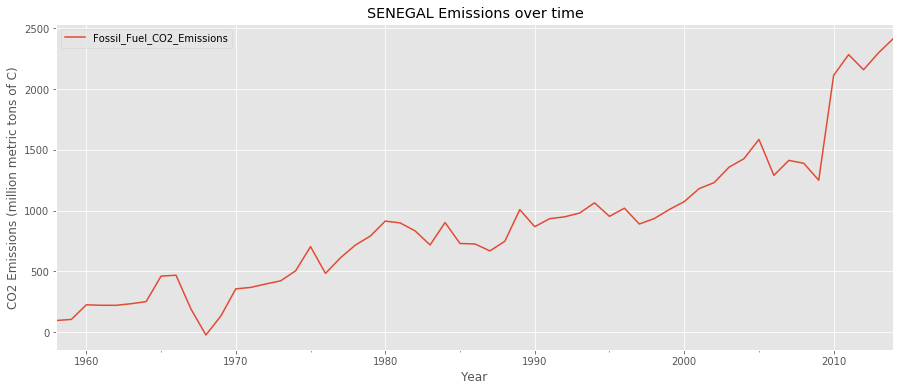

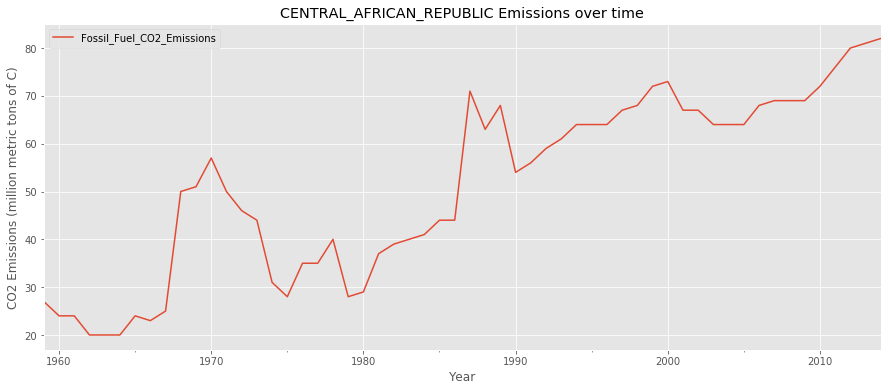

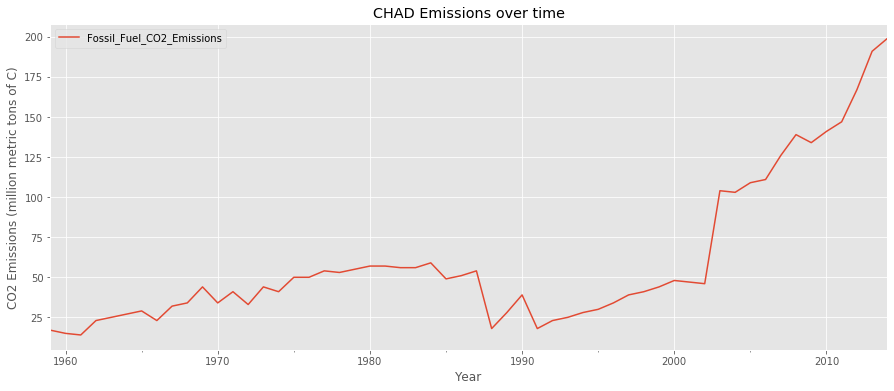

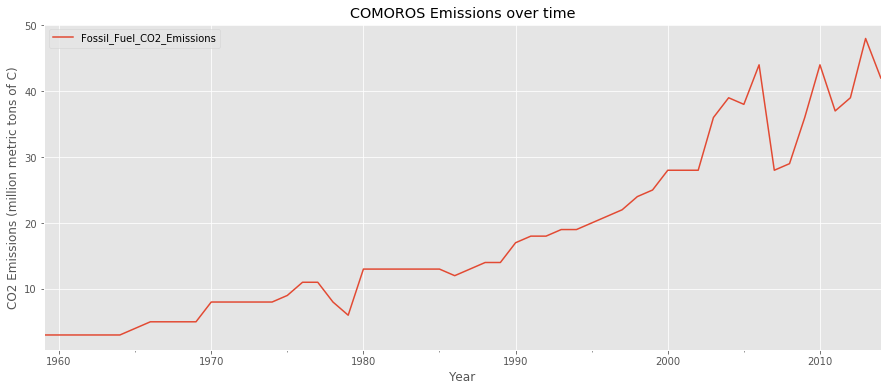

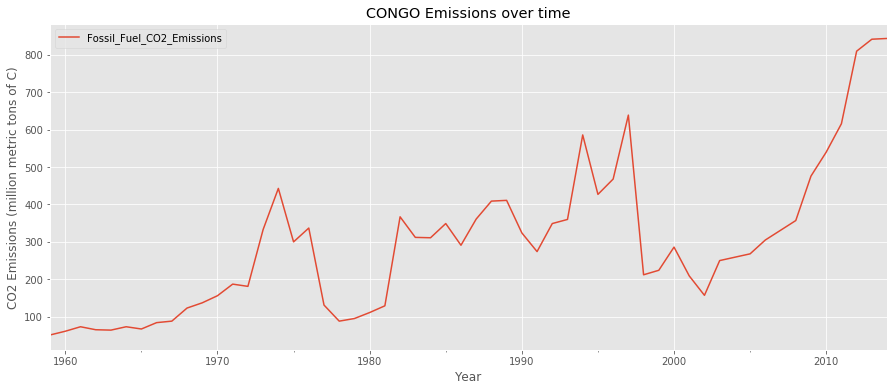

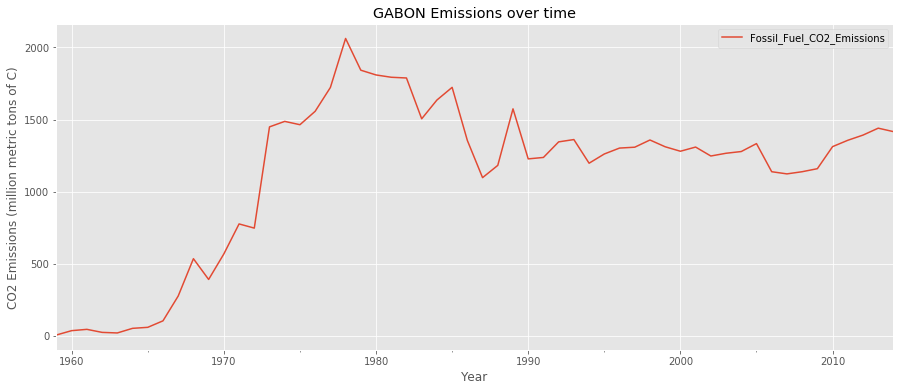

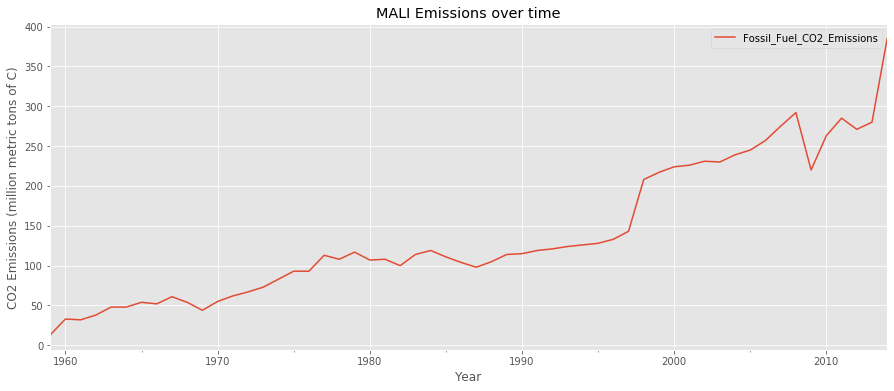

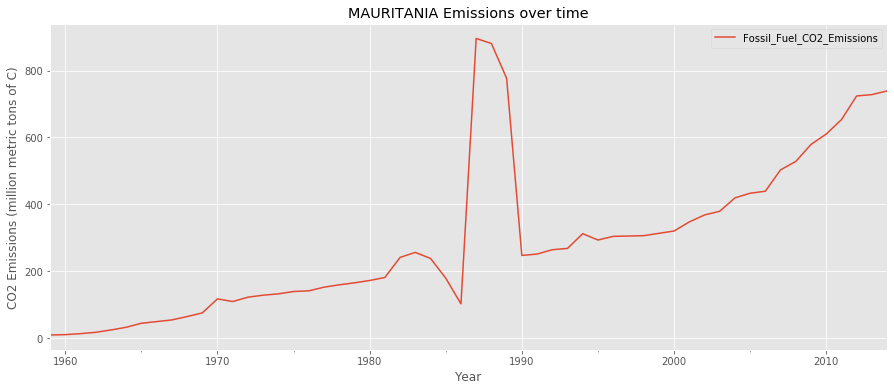

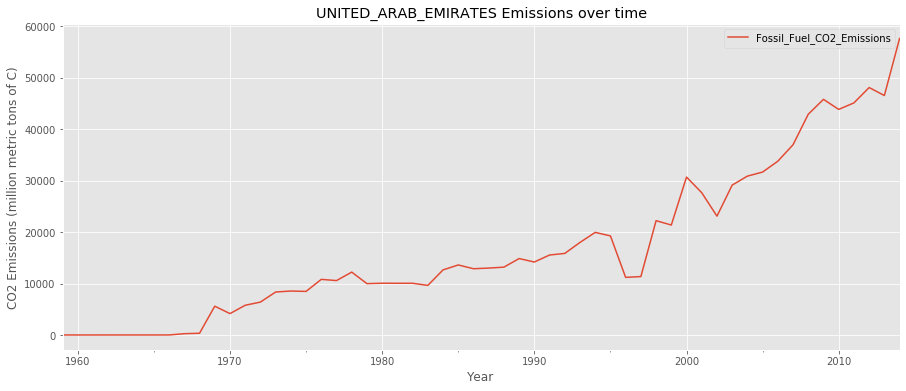

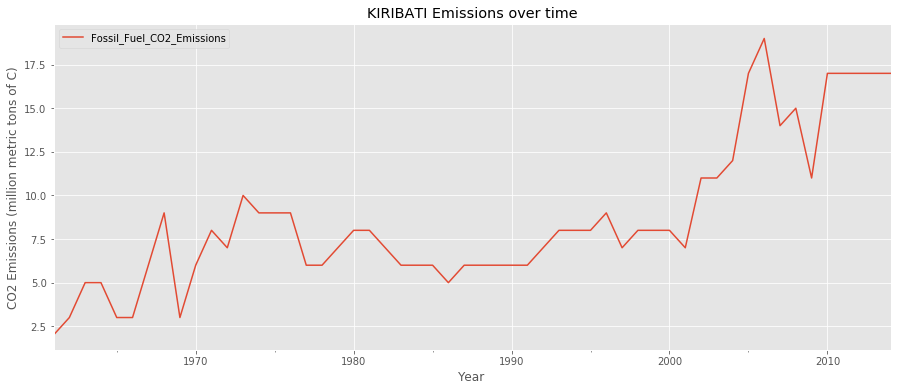

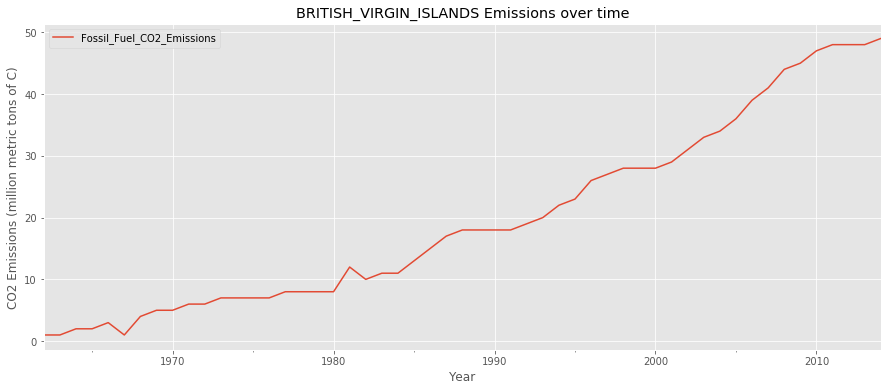

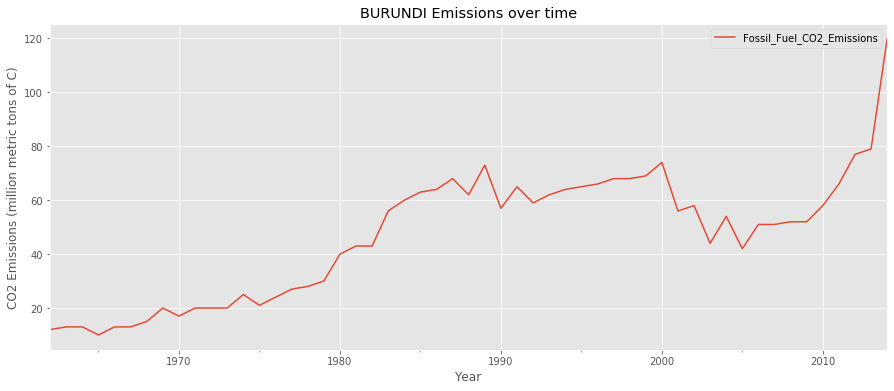

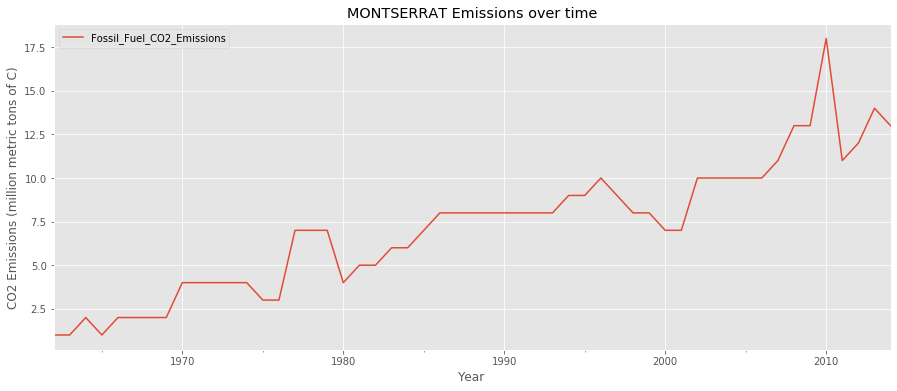

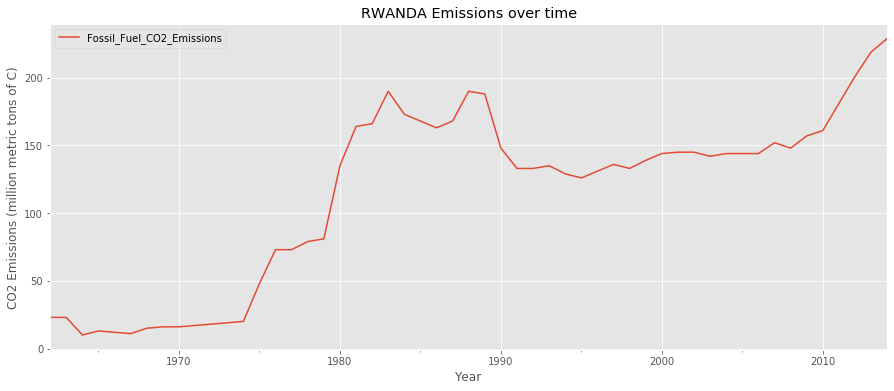

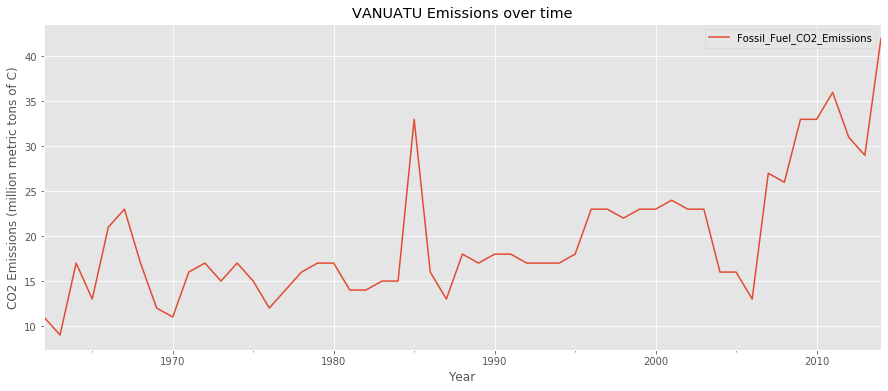

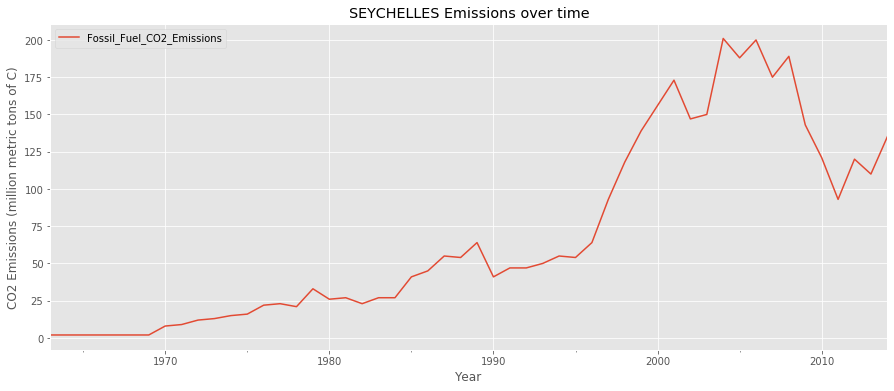

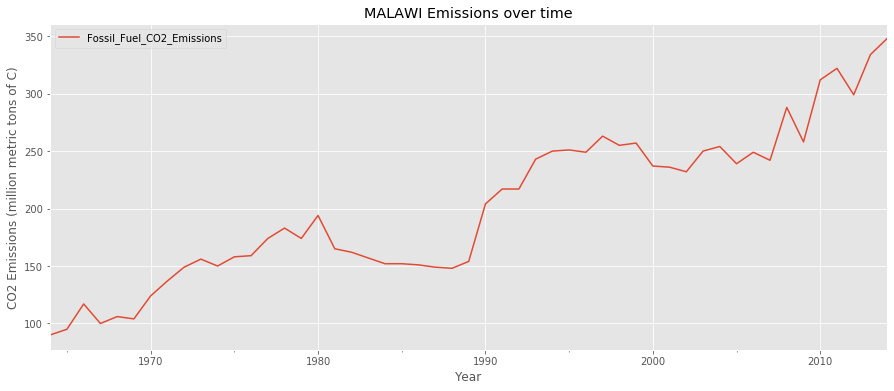

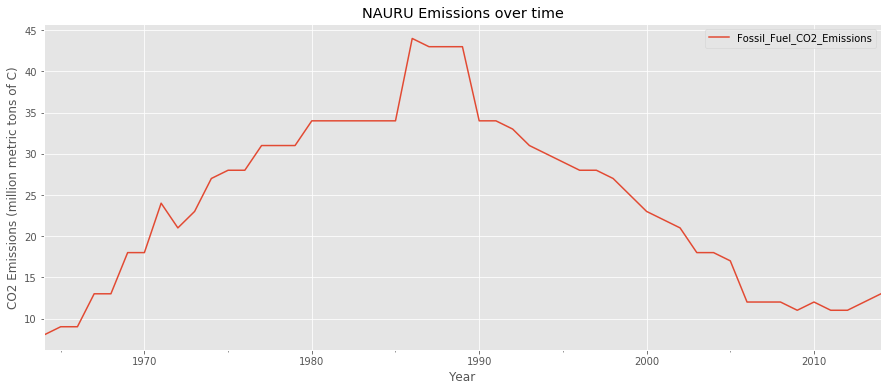

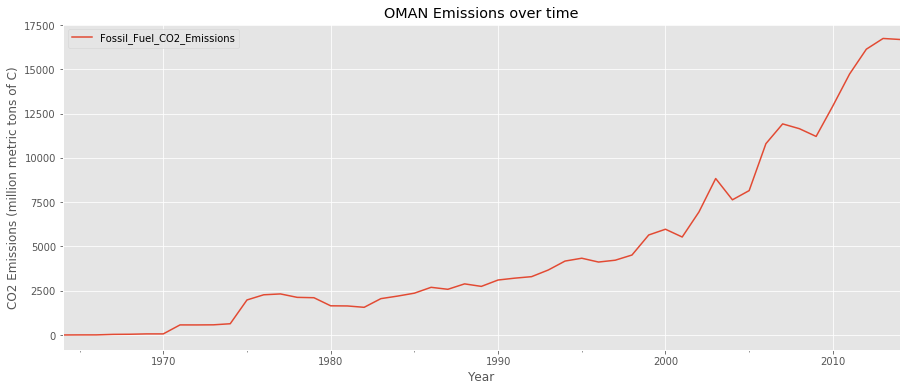

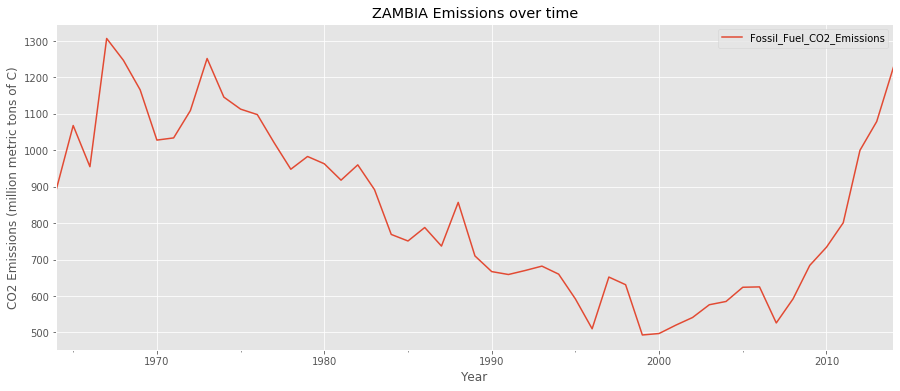

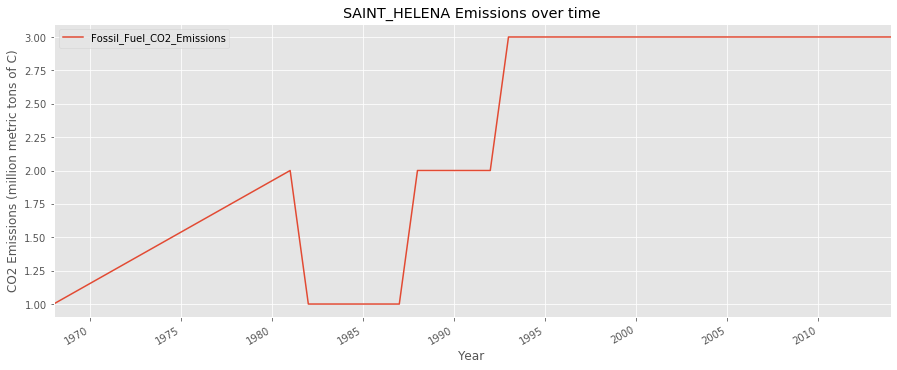

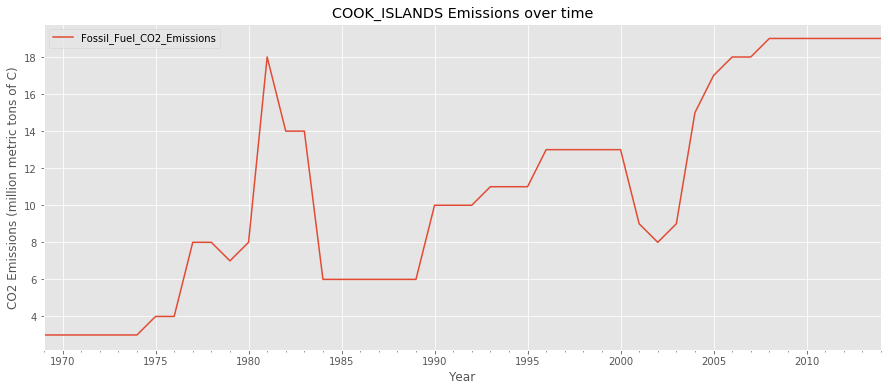

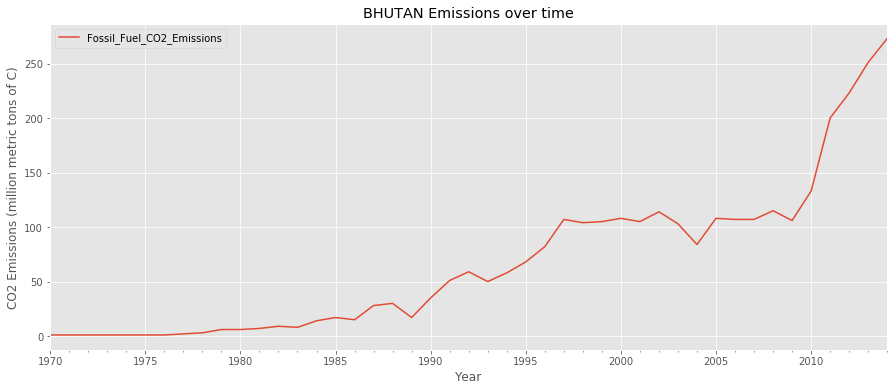

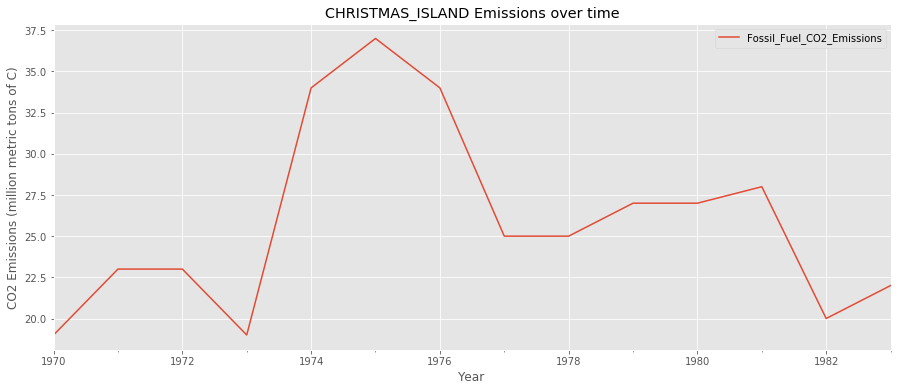

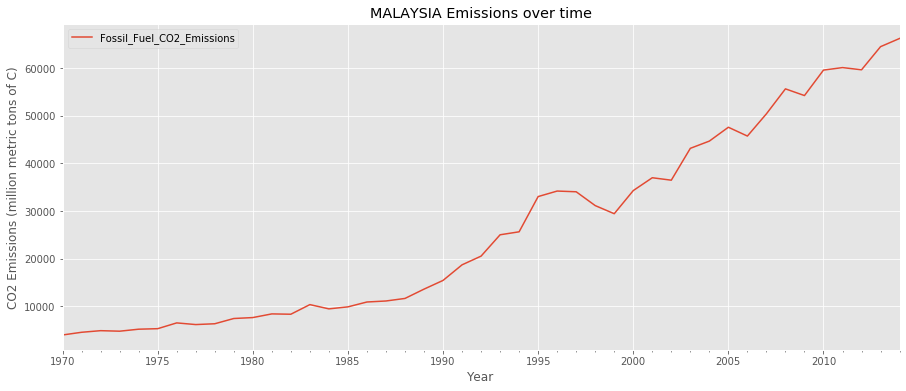

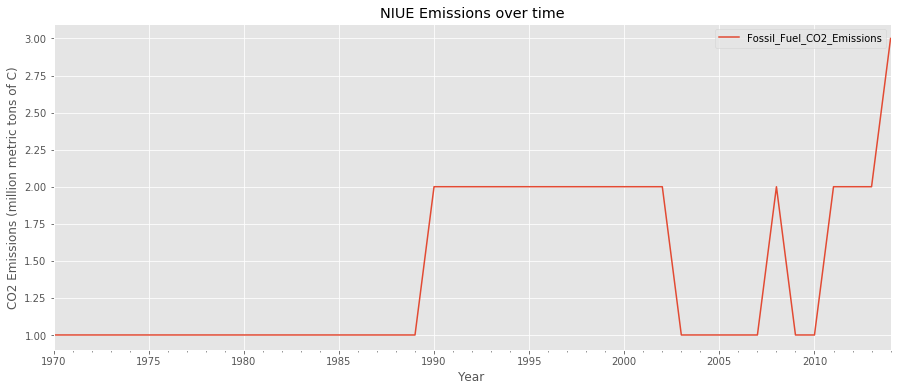

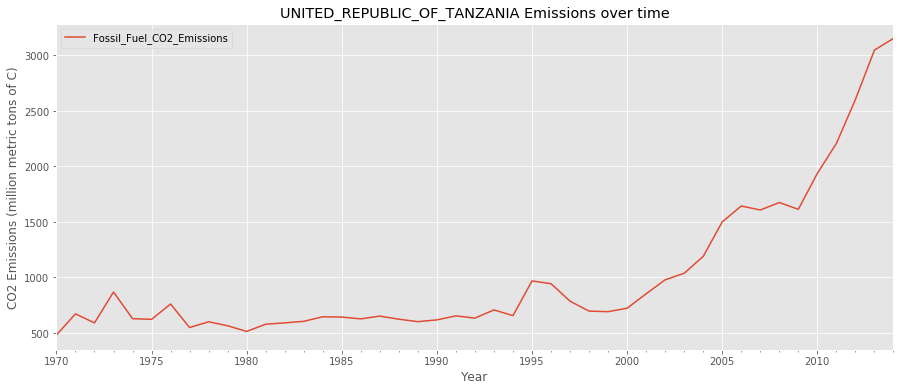

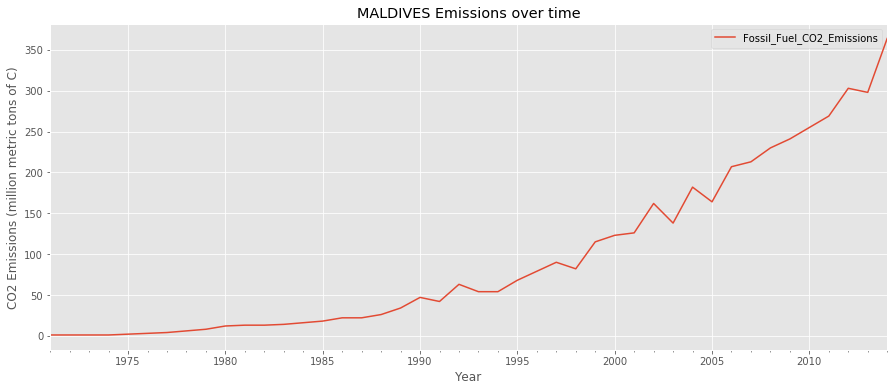

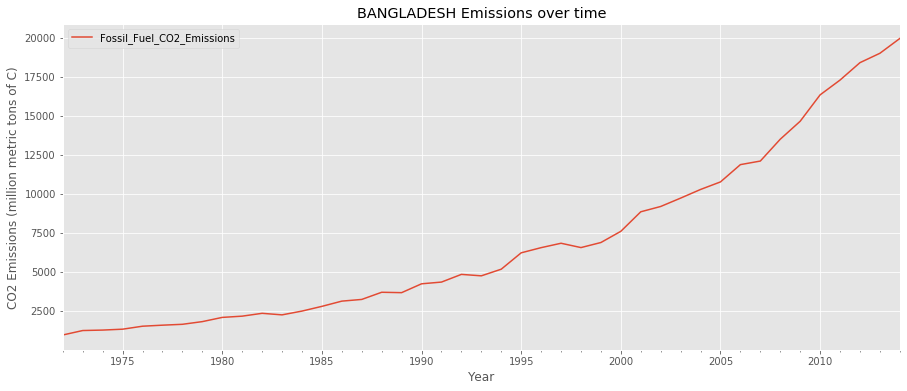

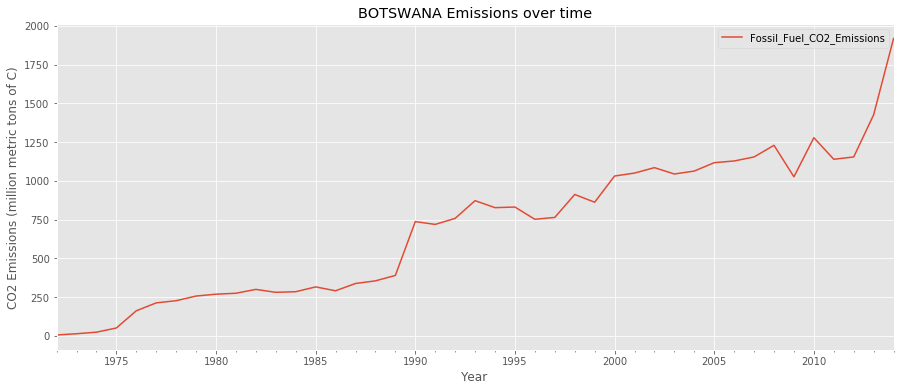

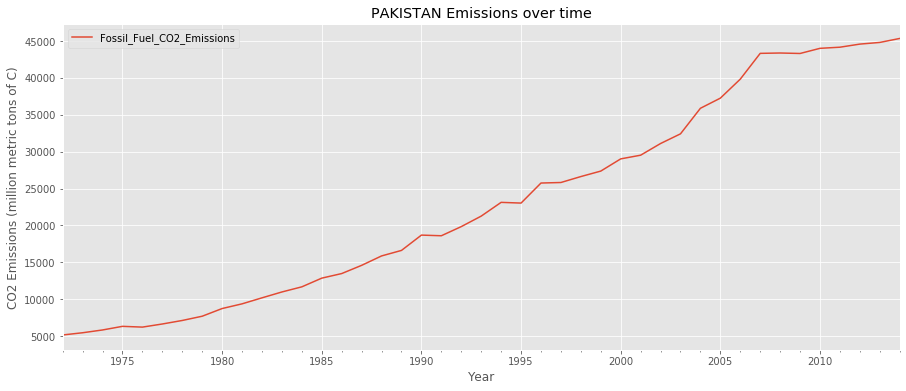

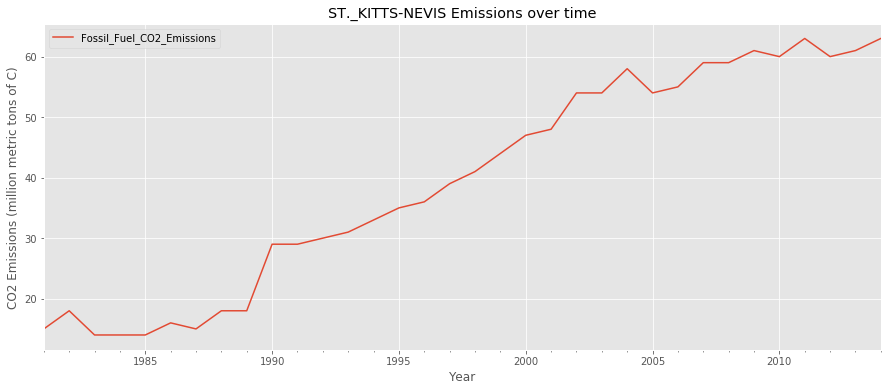

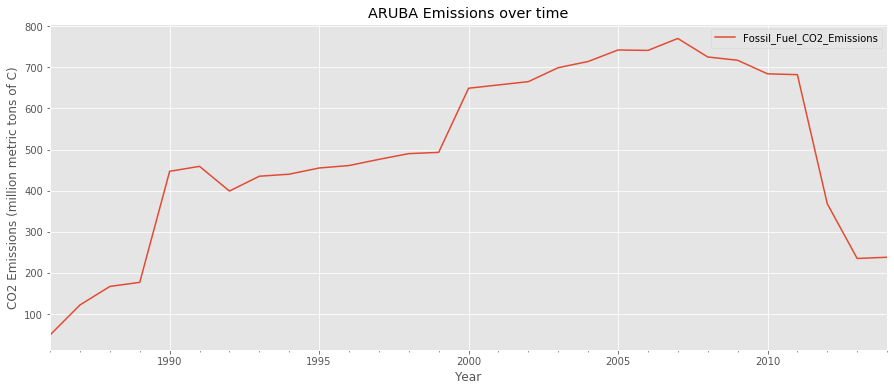

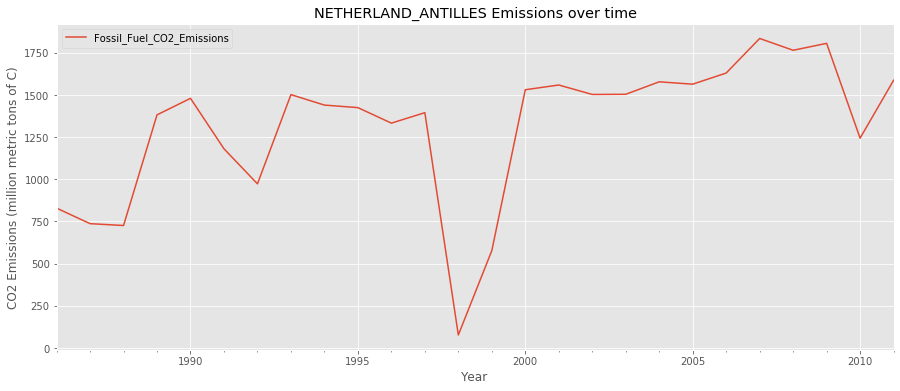

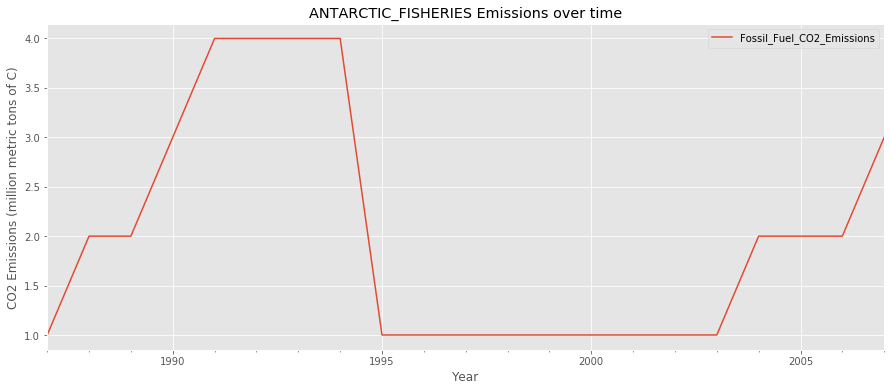

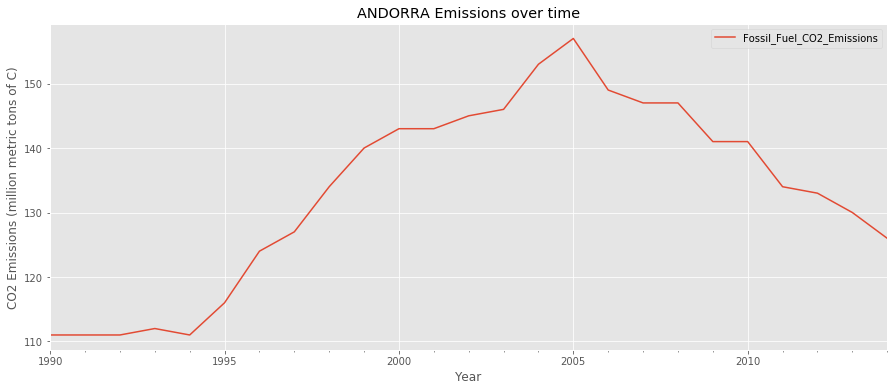

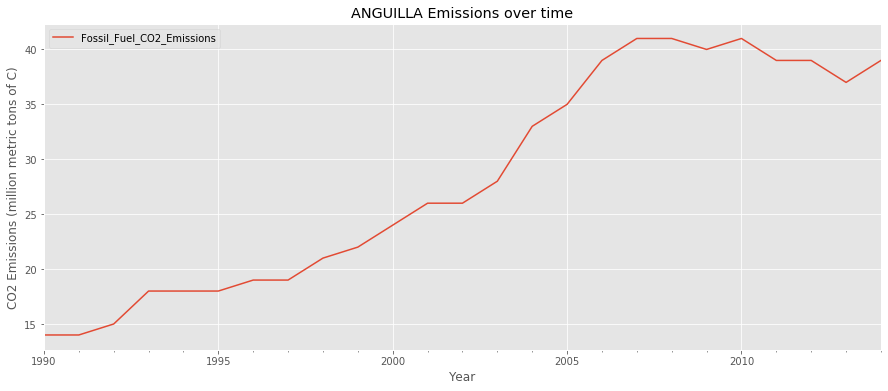

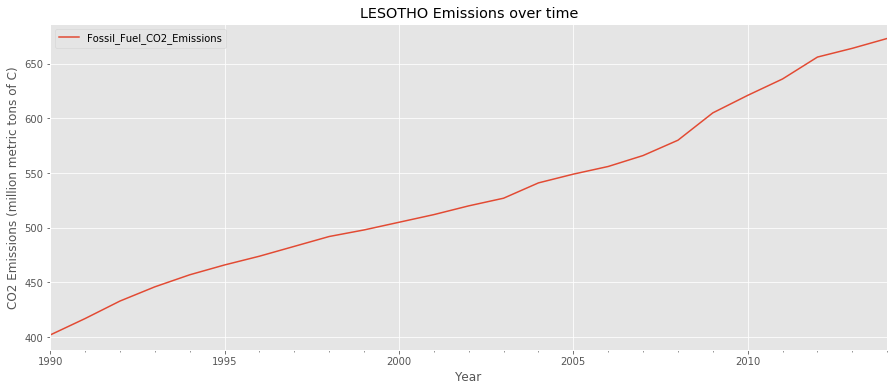

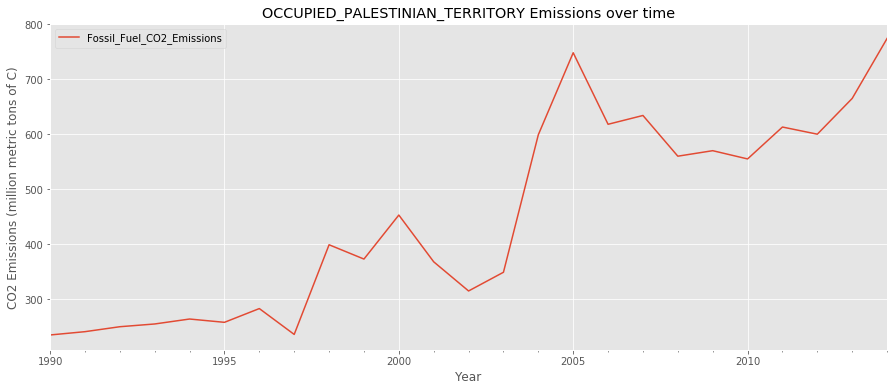

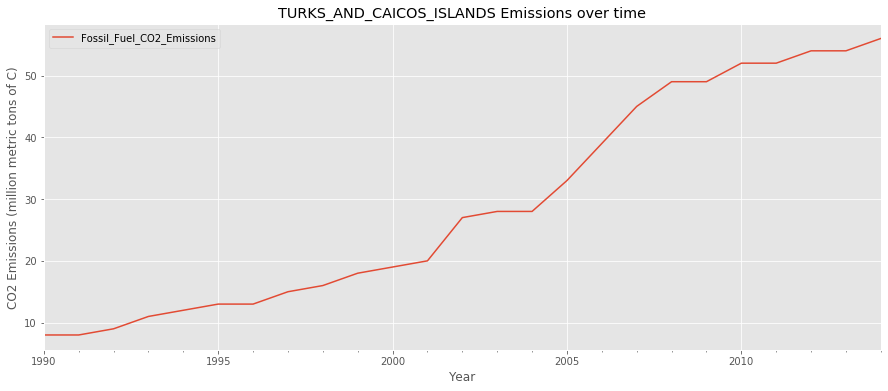

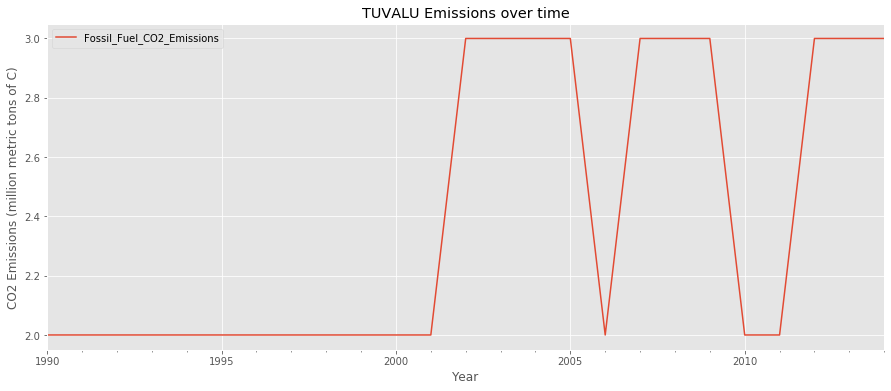

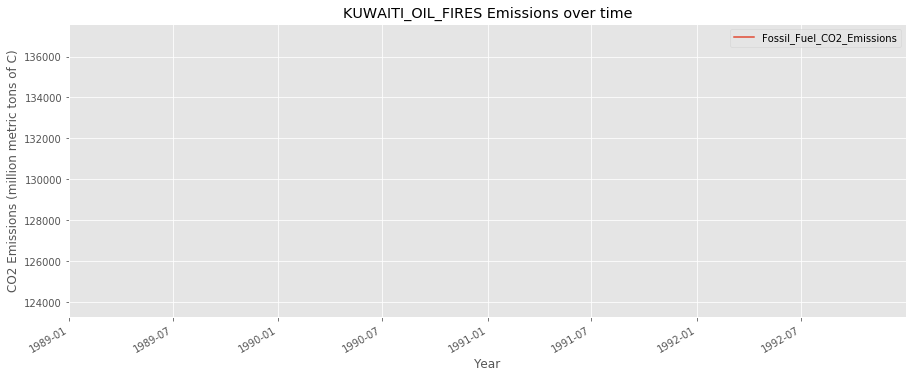

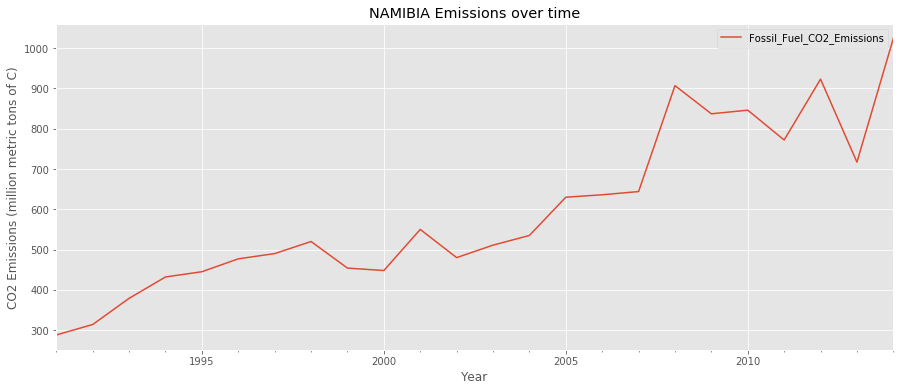

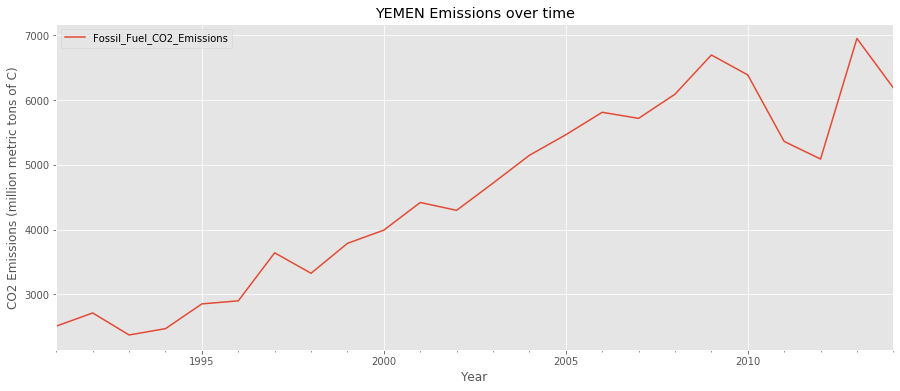

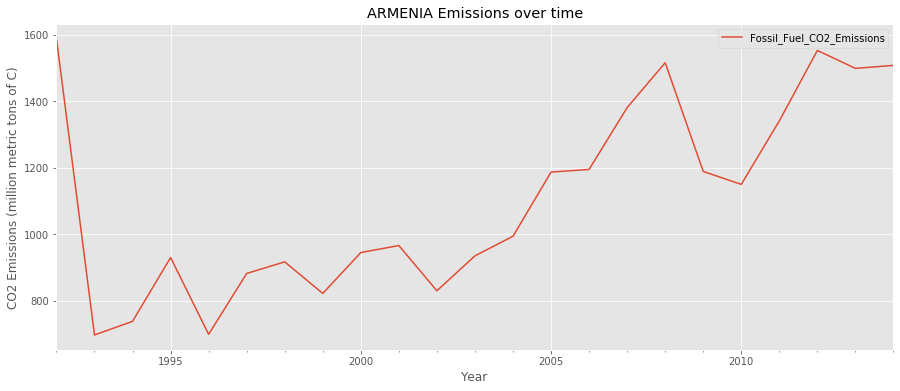

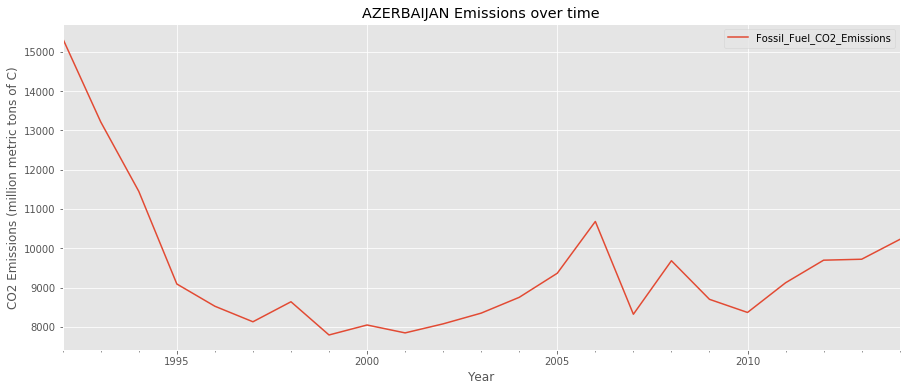

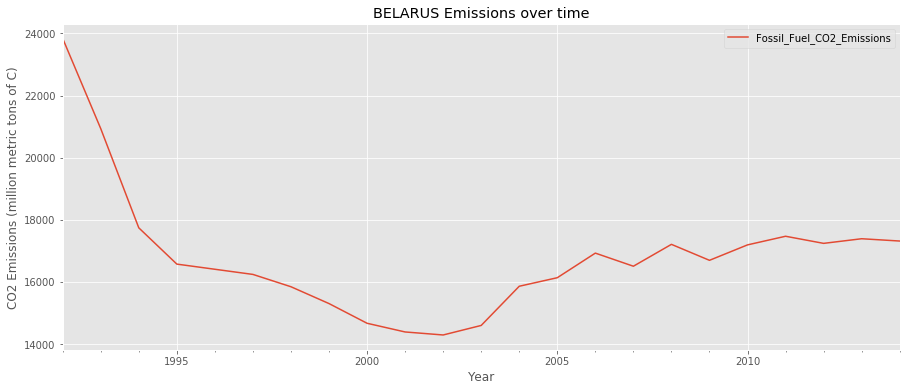

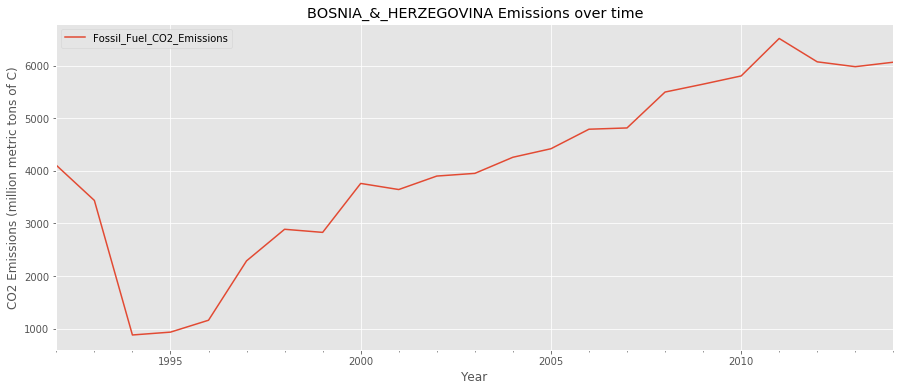

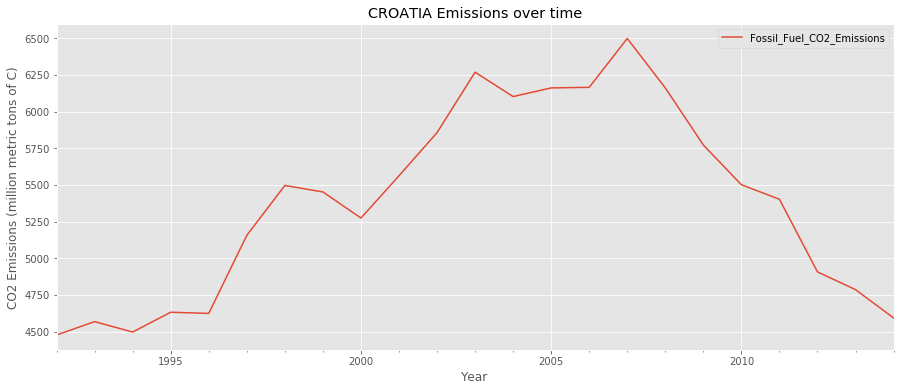

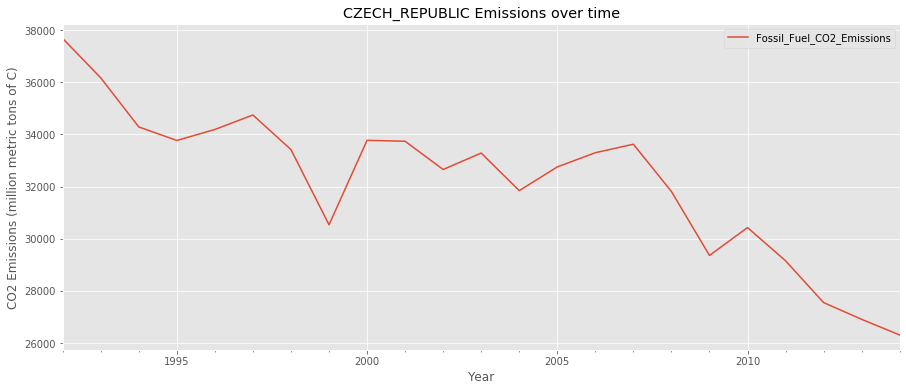

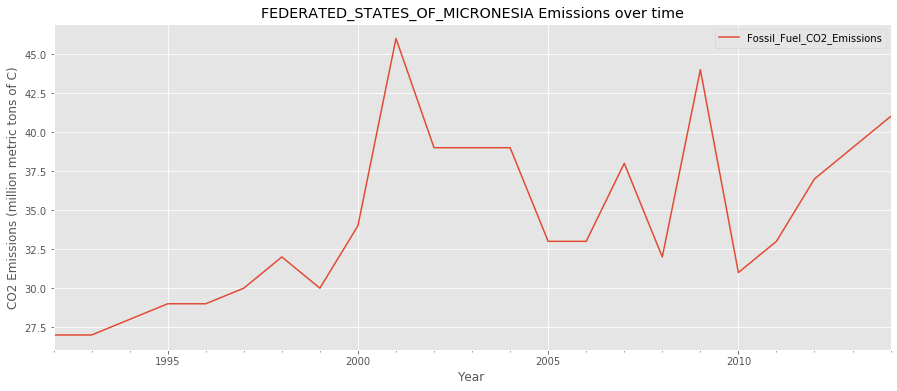

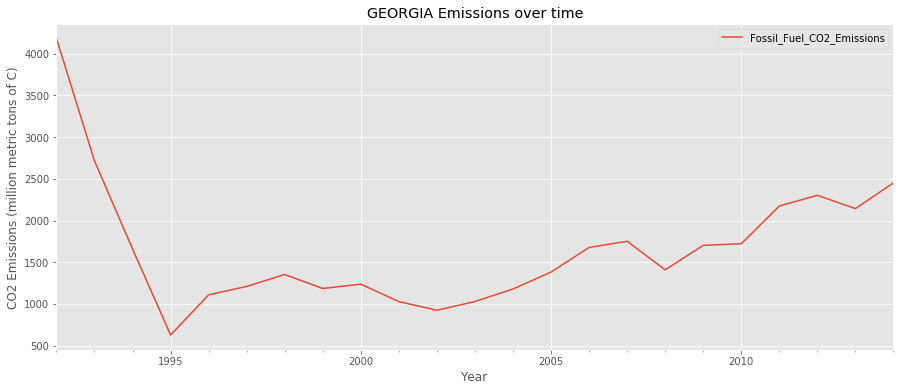

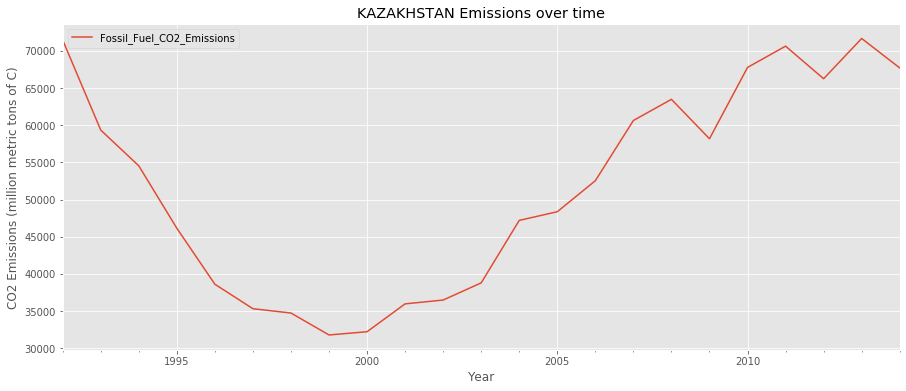

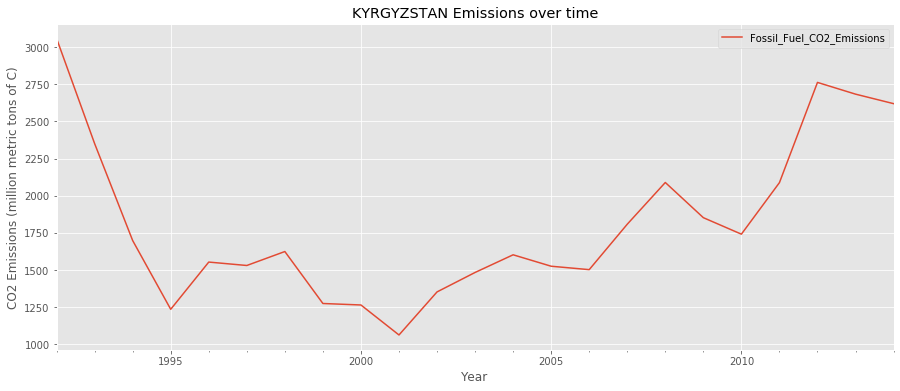

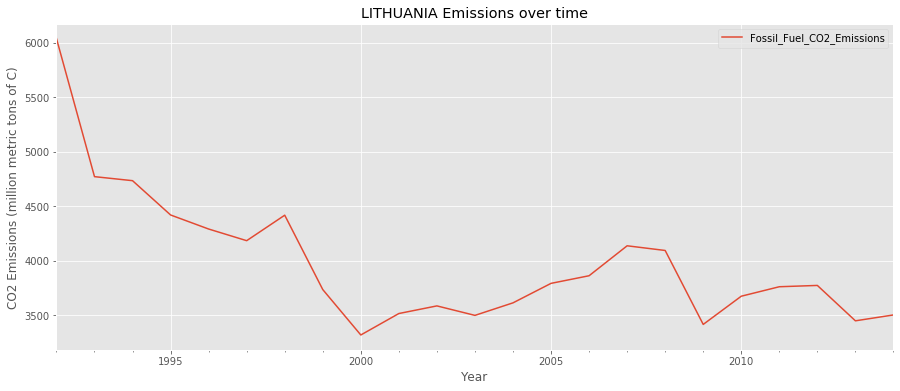

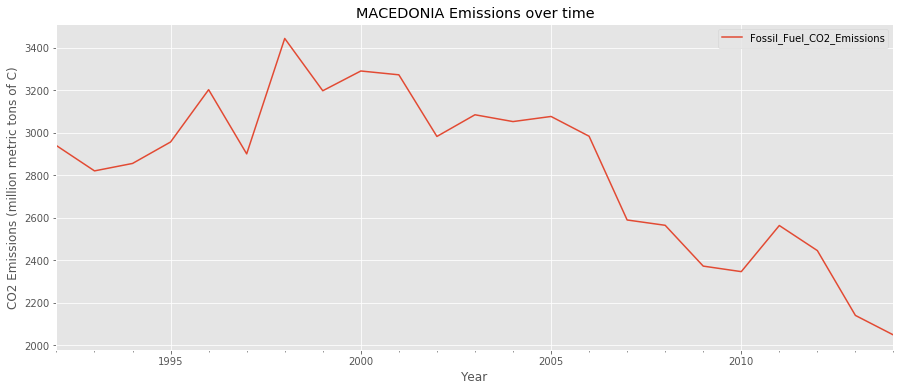

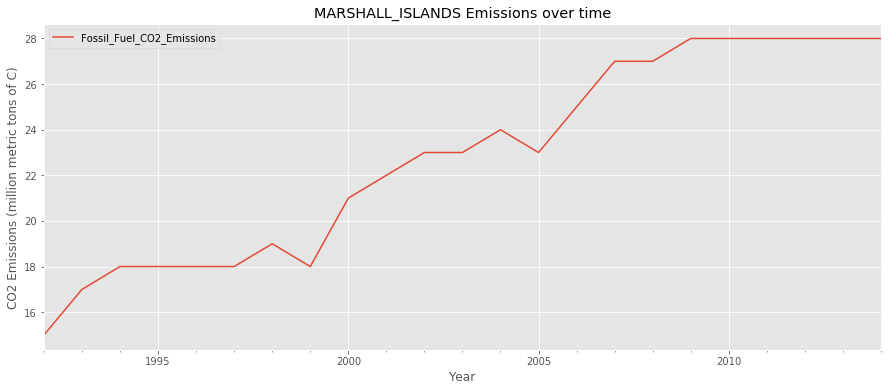

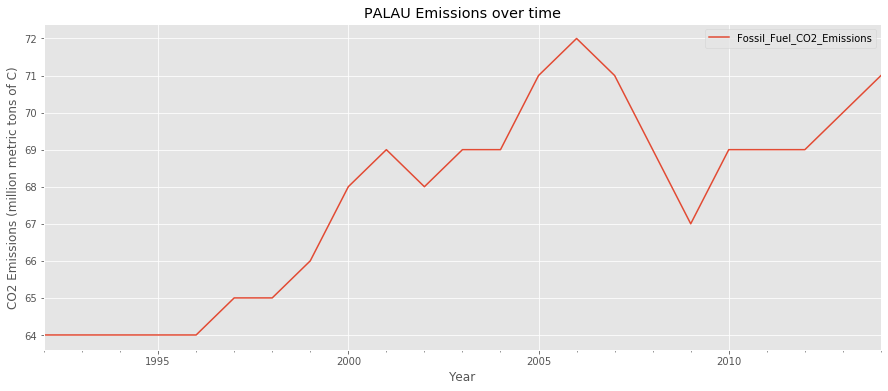

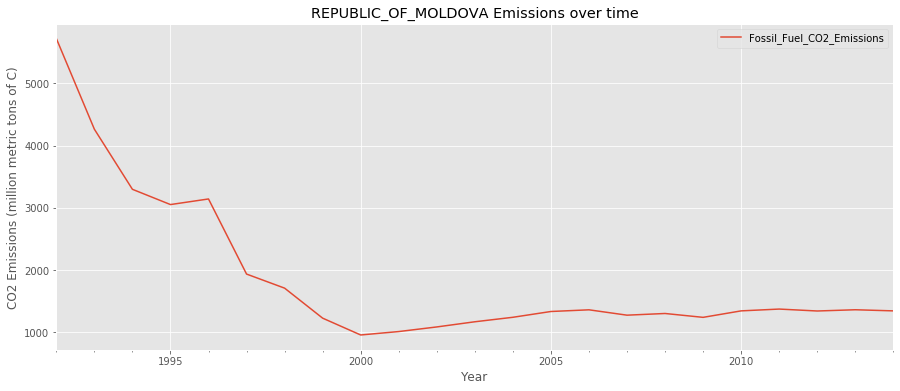

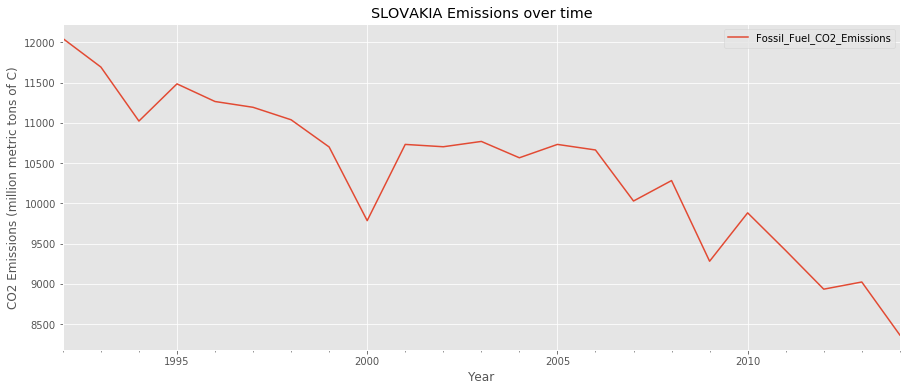

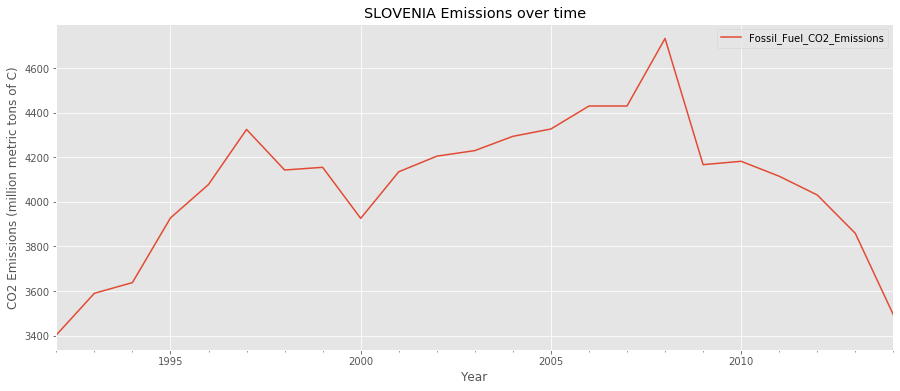

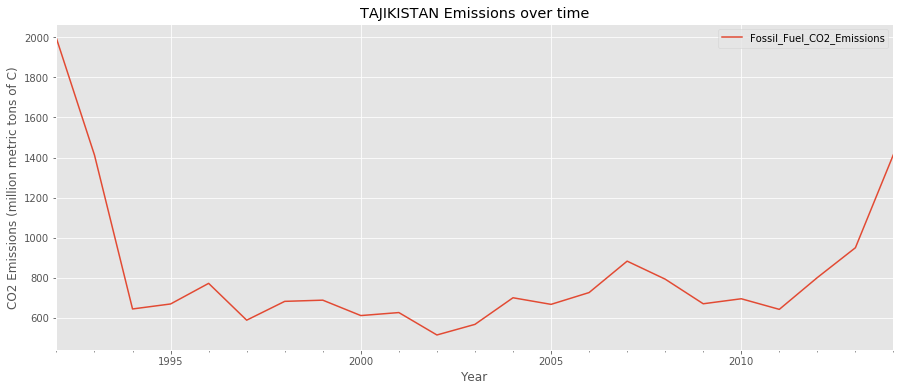

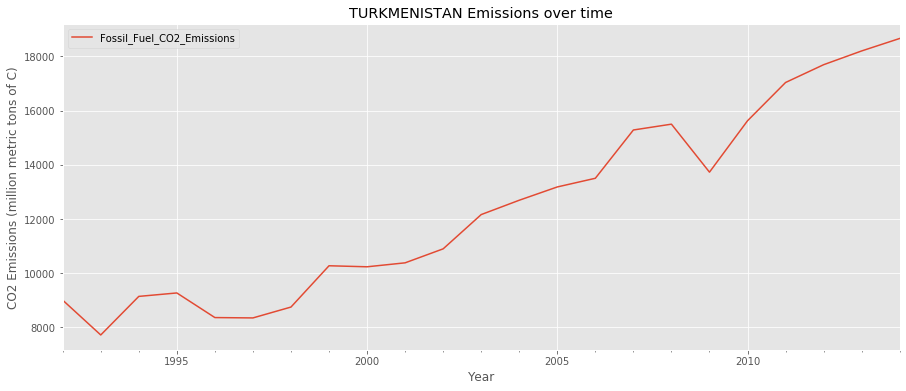

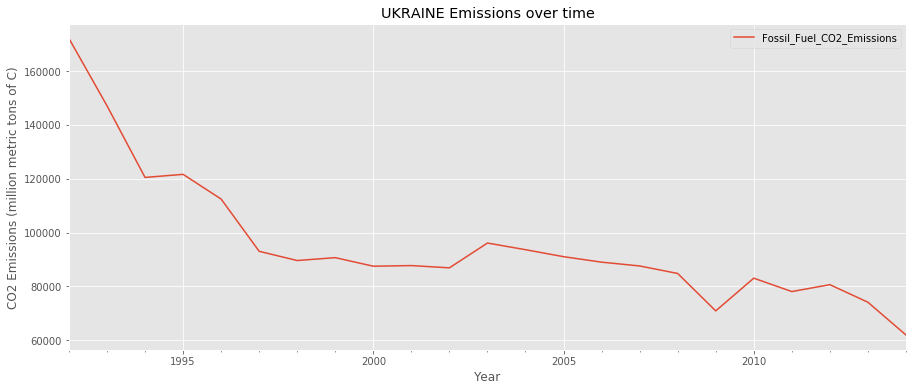

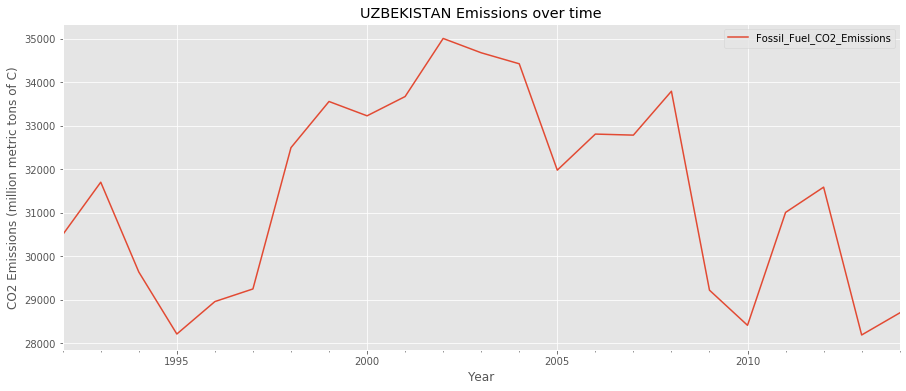

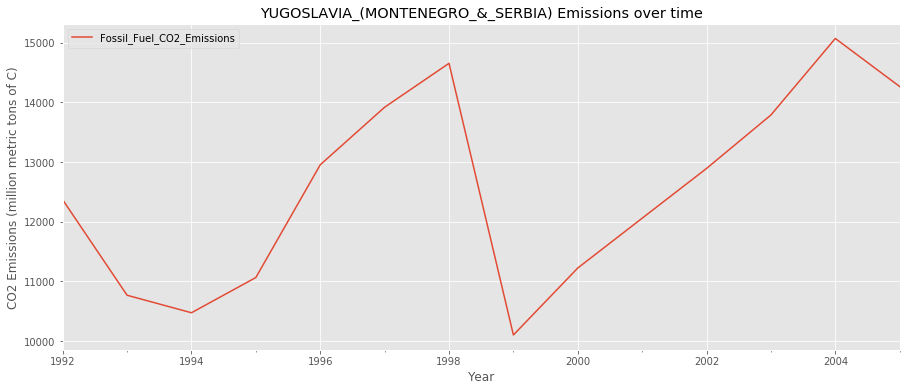

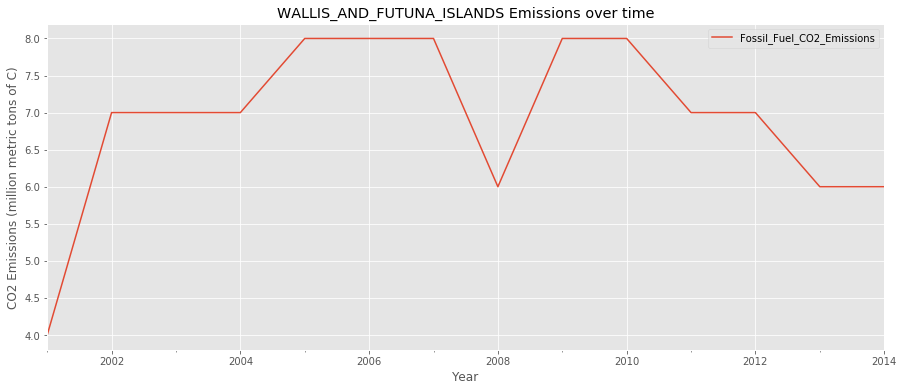

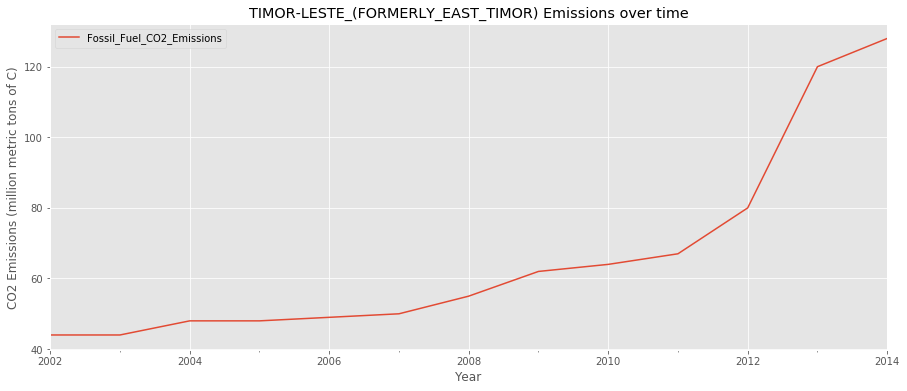

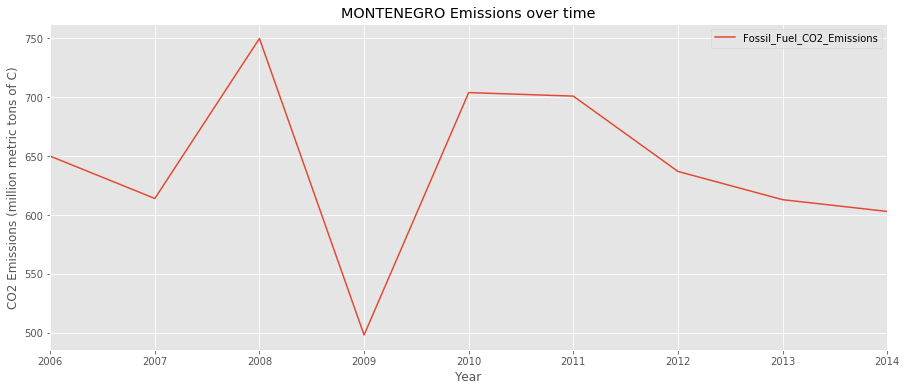

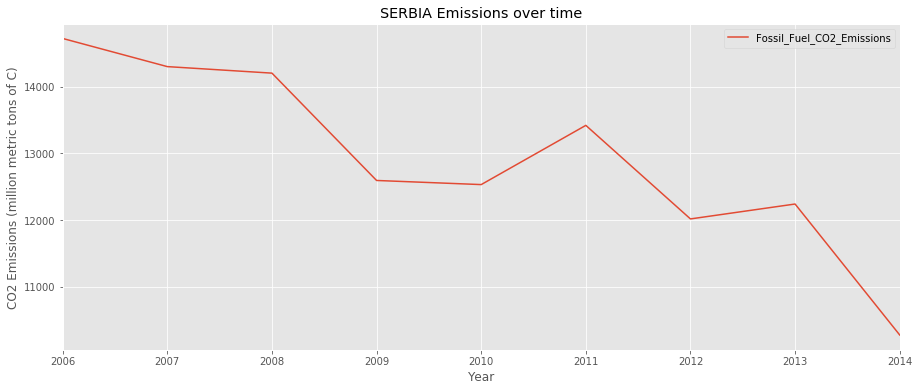

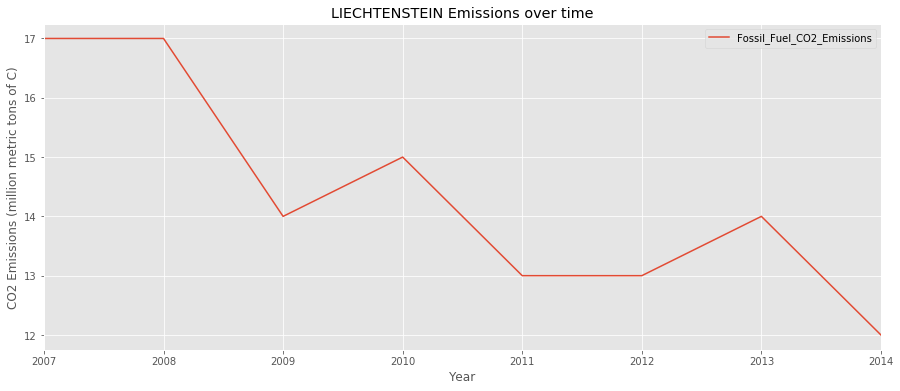

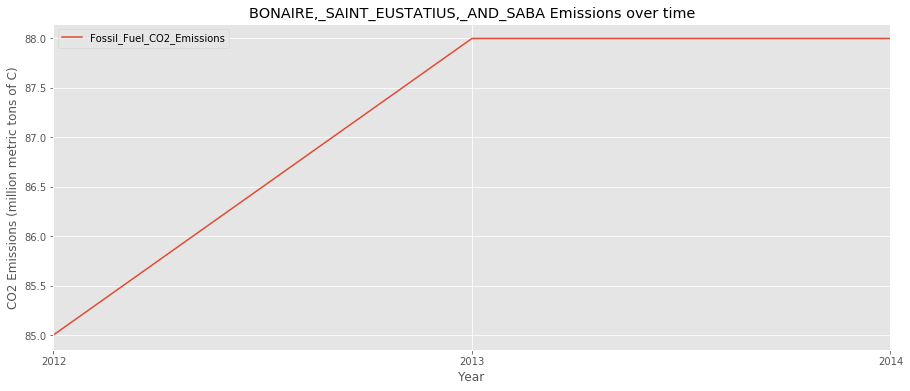

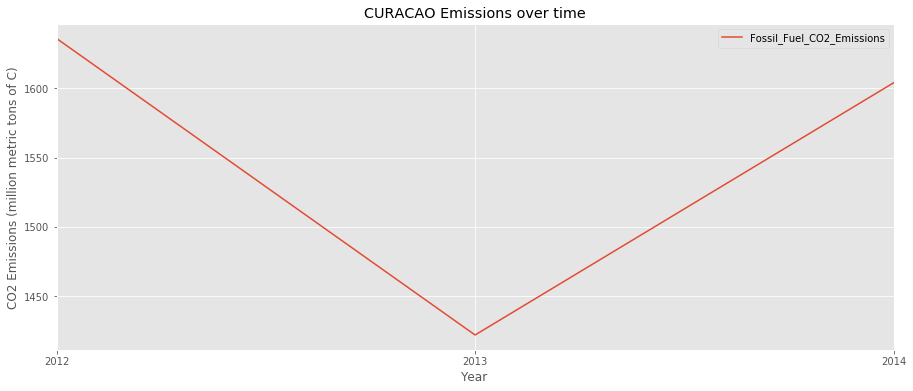

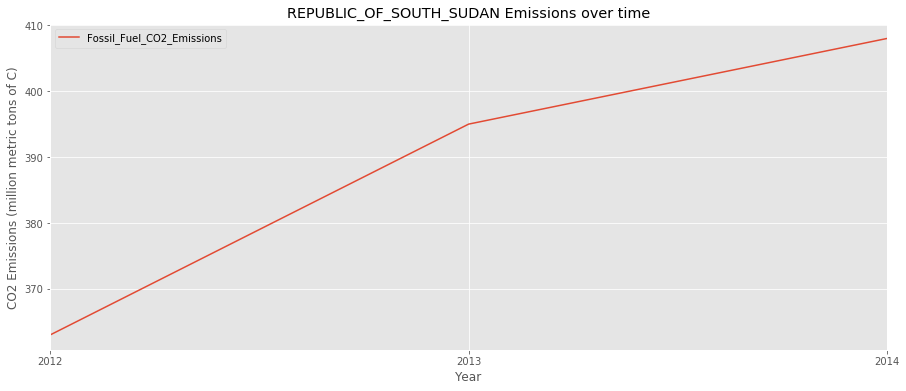

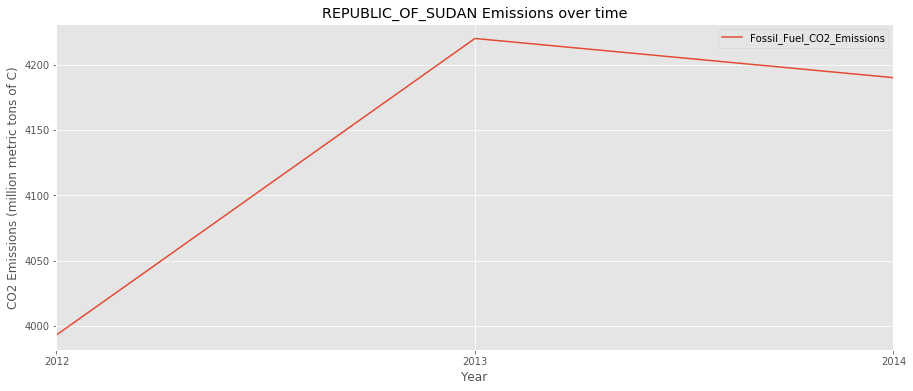

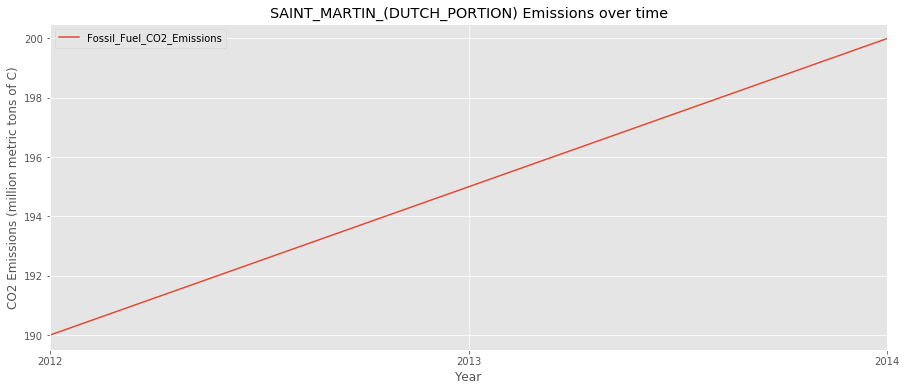

In [15]:
# Visualize Time Series by Country
for key in country_df_dict.keys(): 
    country_df_dict[key].plot(figsize=(15,6))
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions (million metric tons of C)')
    plt.title(f'{key[:-3]} Emissions over time')
    plt.show()

In [ ]:
# Drop countries with less than 50 years of data
country_df_dict2 = {}
for key, value in country_df_dict.items():
    if len(value) < 50:
        continue
    else:
        country_df_dict2[key] = value

In [ ]:
len(country_df_dict2)

In [ ]:
# Dickey-Fuller Tests
dftest_pvalue_dict = {}
for key in country_df_dict2.keys():
    dftest = adfuller(country_df_dict2[key].Fossil_Fuel_CO2_Emissions)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
    dftest_pvalue_dict[key] = dftest[1]
dftest_pvalue_dict
(np.array(list(dftest_pvalue_dict.values())) < .05).sum()

In [ ]:
# 1st Order Differencing
for key in country_df_dict2.keys():
    country_df_dict2[key] = country_df_dict2[key].diff(periods = 1).dropna()

In [ ]:
# Dickey-Fuller Tests on 1st Order Differenced TSs
dftest_pvalue_dict = {}
for key in country_df_dict2.keys():
    dftest = adfuller(country_df_dict2[key].Fossil_Fuel_CO2_Emissions)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
    dftest_pvalue_dict[key] = dftest[1]
dftest_pvalue_dict
print((np.array(list(dftest_pvalue_dict.values())) < .05).sum())
dftest_pvalue_dict

#### Split out data that has Population and GDP Data Years

In [ ]:
emissions_1960on_df = emissions_df[emissions_df.Year >= 1960]

In [ ]:
emissions_1960on_df.head()

### Import Population Data

In [ ]:
pop_df = pd.read_csv('Data_Files/API_SP.POP.TOTL_DS2_en_csv_v2_656875.csv', skiprows = 4)
pop_df.head()

In [ ]:
pop_df.shape

In [ ]:
pop_df.drop(labels = ['Indicator Name', 'Indicator Code', '2015', '2016',
                      '2017', '2018', '2019', 'Unnamed: 64'], axis = 1, inplace = True)

In [ ]:
pop_df.columns

In [ ]:
val_vars = pop_df.columns[2:]

In [ ]:
pop_df = pop_df.melt(id_vars = ['Country Name', 'Country Code'],
                     value_vars = val_vars, var_name = 'Year', value_name = 'Population')

In [ ]:
pop_df.head()

In [ ]:
pop_df.info()

In [ ]:
pop_df.sort_values(by = ['Country Name', 'Year'], inplace = True)

### Import GDP Data

In [ ]:
gdp_df = pd.read_csv('Data_Files/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_656893.csv', skiprows = 4)
gdp_df.head()

In [ ]:
gdp_df.drop(labels = ['Indicator Name', 'Indicator Code', '2015', '2016',
                      '2017', '2018', '2019', 'Unnamed: 64'], axis = 1, inplace = True)

In [ ]:
gdp_df.columns

In [ ]:
val_vars = gdp_df.columns[2:]

In [ ]:
gdp_df = gdp_df.melt(id_vars = ['Country Name', 'Country Code'],
                     value_vars = val_vars, var_name = 'Year', value_name = 'GDP')

In [ ]:
gdp_df.head()

In [ ]:
gdp_df.info()

In [ ]:
gdp_df.sort_values(by = ['Country Name', 'Year'], inplace = True)